# PMU Parquet Dataset

Dataset é um **DownSample** das bases originais em minutos.

In [ ]:
!pip install gdown==4.6.3
!rm *.parquet
!rm *.xlsx

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
rm: cannot remove '*.parquet': No such file or directory
rm: cannot remove '*.xlsx': No such file or directory


In [ ]:
#!gdown --fuzzy https://drive.google.com/file/d/1fdkgRTJkYo_pPZCUI0mHMyBuiisAkmfE/view?usp=share_link -O Database_Parquet.zip
!gdown --fuzzy https://drive.google.com/file/d/1VpU9HgQ2vS7kViTPTto5gmoAMZMMTk7U/view?usp=sharing -O Database_Parquet.zip
!unzip -qq Database_Parquet.zip
!rm Database_Parquet.zip

Downloading...
From: https://drive.google.com/uc?id=1VpU9HgQ2vS7kViTPTto5gmoAMZMMTk7U
To: /content/Database_Parquet.zip
100% 4.14M/4.14M [00:00<00:00, 142MB/s]


In [ ]:
import glob
parquets = glob.glob('*.parquet')
len(parquets), parquets[:5]

(149,
 ['evento 1 - 08-04-2021 - 5060.parquet',
  'evento 1 - 08-04-2021 - 1010.parquet',
  'evento 2 - 28-05-2021 - 2020.parquet',
  'evento 1 - 08-04-2021 - 5071.parquet',
  'evento 1 - 08-04-2021 - 1000.parquet'])

# Eventos de Estudo

In [ ]:
from datetime import datetime

eventos =[
    datetime(2021,4,8,18,34,0),
    datetime(2021,5,28,11,6,0),
    datetime(2021,5,28,11,26,0),
    datetime(2021,5,28,23,28,0),
    ]
eventos

[datetime.datetime(2021, 4, 8, 18, 34),
 datetime.datetime(2021, 5, 28, 11, 6),
 datetime.datetime(2021, 5, 28, 11, 26),
 datetime.datetime(2021, 5, 28, 23, 28)]

## Extraindo bases para eventos

Configurações:

In [ ]:
from datetime import timedelta
import pandas as pd
import warnings

def medidas(arquivos, evento:datetime, tempo_antes=240, tempo_depois=4) -> pd.DataFrame:
  # inicio e fim das medidas do evento
  data_ini = evento - timedelta(minutes=tempo_antes)
  data_fim = evento + timedelta(minutes=tempo_depois)
  tabelas = []
  # lista arquivos com tabelas
  for parquet in arquivos:
    df = pd.read_parquet(parquet)
    mascara = (df['instante'] >= data_ini) & (df['instante'] < data_fim)
    df = df[mascara]
    # ignora resultado zero do filtro de tempo
    if len(df) == 0:
      del df
      continue
    # adiciona apenas tabelas com conteúdo
    tabelas.append(df)
    del df
  # não foi encontrado medidas
  if len(tabelas) == 0:
    return None

  warnings.filterwarnings('ignore')
  # agrupando colunas das tabelas
  pmu = tabelas[0]
  for i, df in enumerate(tabelas[1:]):
    for col in df.columns[1:]:
      if col in pmu.columns:
        new_col = f'{col}_{i+1}'
        pmu[new_col] = df[col].copy()
      else:
        pmu[col] = df[col].copy()
  # elimina colunas nulas
  pmu = pmu.dropna(axis=1)
  # coluna tutor para acertos das anomalias
  antes = 0 #minutos
  depois = 2 #minutos
  pmu['y'] = pmu['instante'].map(lambda x: 1 if x >= evento - timedelta(minutes=antes) and x <= evento + timedelta(minutes=depois) else 0 )
  pmu = pmu.set_index('instante')

  warnings.filterwarnings('default')
  return pmu

medidas(parquets, eventos[0]).head()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

rocof      freq  I_BC5_230kV  I_SOS_230kV  \
instante                                                            
2021-04-08 14:34:00  0.009258  0.048946     0.067521     2.747375   
2021-04-08 14:35:00  0.007303  0.024331     0.056503     2.801086   
2021-04-08 14:36:00  0.009515  0.046551     0.091209     2.902161   
2021-04-08 14:37:00  0.010515  0.054749     0.125198     4.830994   
2021-04-08 14:38:00  0.010098  0.047791     0.119591     4.050110   

                     I_XAN_230kV  V_BARRA_230k   rocof_2    freq_2  \
instante                                                             
2021-04-08 14:34:00     3.332093    122.375000  0.009069  0.048961   
2021-04-08 14:35:00     3.342530    130.687500  0.007478  0.024295   
2021-04-08 14:36:00     3.733520    195.453125  0.009888  0.046485   
2021-04-08 14:37:00     5.086945    173.125000  0.010156  0.054703   
2021-04-08 14:38:00     5.172729    180.921875  0.009855  0.047733   

                     I_CVO_525kV  V_CVO_525kV  ...    freq_79  I_REA_H1_79  \
instante                                       ...                           
2021-04-08 14:34:00     5.405815     631.0000  ...   0.052868     0.579483   
2021-04-08 14:35:00     4.299209     369.0000  ...   0.028217     0.611908   
2021-04-08 14:36:00     5.548149     779.5625  ...   0.049877     0.613479   
2021-04-08 14:37:00     5.804146     726.6875  ...  60.048214   169.200790   
2021-04-08 14:38:00     5.077919     790.9375  ...   0.050938     0.588364   

                     I_TAU_525kV  V_TAU_525kV  I_ARE_230kV  rocof_81  \
instante                                                               
2021-04-08 14:34:00     7.965545     986.0625     2.866257  0.219268   
2021-04-08 14:35:00     6.220489    1002.5625   190.394699  0.206909   
2021-04-08 14:36:00    10.701752    1213.2500     3.785934  0.179673   
2021-04-08 14:37:00   388.418213  549674.0000     3.696549  0.206451   
2021-04-08 14:38:00     7.368072    1301.1250     3.342422  0.144195   

                      freq_81  I_LON2_525kV_81  V_LON2_525kV_81  y  
instante                                                            
2021-04-08 14:34:00  0.052109         7.669243        1026.0625  0  
2021-04-08 14:35:00  0.027450        11.738479         720.1875  0  
2021-04-08 14:36:00  0.048889         7.580978        1183.6875  0  
2021-04-08 14:37:00  0.056522         9.212303        1202.9375  0  
2021-04-08 14:38:00  0.050053         6.197502        1144.2500  0  

[5 rows x 265 columns]

# Detector de Anomalias Clássicos (SkLean)

In [ ]:
from matplotlib.font_manager import X11FontDirectories
from sklearn import preprocessing, decomposition
from sklearn.pipeline import make_pipeline

from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem

import matplotlib.pyplot as plt

contaminantes = 0.05

detectores = [
    OneClassSVM(nu=contaminantes, kernel="rbf", gamma=0.1),
    EllipticEnvelope(contamination=contaminantes),
    make_pipeline(
        Nystroem(gamma=0.1, random_state=42, n_components=150),
        SGDOneClassSVM(nu=contaminantes, shuffle=True, fit_intercept=True, random_state=42, tol=1e-6),
    ),
    IsolationForest(contamination=contaminantes, random_state=42),
    LocalOutlierFactor(n_neighbors=35, contamination=contaminantes),
]

saida = {}

for evento in eventos[:1]:

  df = medidas(parquets, evento)
  X = df[df.columns[:-1]].values
  y_true = df[df.columns[-1]].values

  saida['instante'] = df.index.values

  for x in df.columns:
    if 'rocof' in x:
      saida[x] = df[x].values

  for det in detectores:
    nome = det.__class__.__name__
    # converte anomalia -1 => 1 e normal 1 => 0
    y_pred = -(det.fit_predict(X)-1) // 2
    #print(det.__class__.__name__, y_pred)

    saida[f'{nome}-{evento}'] = y_pred

dfs = pd.DataFrame(data=saida)
dfs

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

instante     rocof   rocof_2   rocof_3   rocof_4   rocof_8  \
0   2021-04-08 14:34:00  0.009258  0.009069  0.010611  0.012488  0.173951   
1   2021-04-08 14:35:00  0.007303  0.007478  0.008597  0.009486  0.161820   
2   2021-04-08 14:36:00  0.009515  0.009888  0.010302  0.012329  0.155182   
3   2021-04-08 14:37:00  0.010515  0.010156  0.008881  0.011253  0.152665   
4   2021-04-08 14:38:00  0.010098  0.009855  0.008717  0.011958  0.169602   
..                  ...       ...       ...       ...       ...       ...   
239 2021-04-08 18:33:00  0.039391  0.039899  0.009286  0.039944  0.325470   
240 2021-04-08 18:34:00  0.038076  0.038776  0.046421  0.037334  0.173722   
241 2021-04-08 18:35:00  0.009785  0.011928  0.012664  0.011398  0.186768   
242 2021-04-08 18:36:00  0.013940  0.013784  0.014417  0.013443  0.181503   
243 2021-04-08 18:37:00  0.017470  0.018577  0.019132  0.018488  0.166397   

      rocof_9  rocof_10  rocof_11  rocof_16  ...  rocof_75  rocof_77  \
0    0.009904  0.011727  0.009999  0.164566  ...  0.010172  0.148773   
1    0.007941  0.007443  0.009058  0.182648  ...  0.007833  0.125656   
2    0.010737  0.010321  0.010812  0.184021  ...  0.010632  0.151062   
3    0.009418  0.009641  0.009727  0.144424  ...  0.009740  0.130233   
4    0.008949  0.008295  0.009482  0.145339  ...  0.009196  0.098877   
..        ...       ...       ...       ...  ...       ...       ...   
239  0.037690  0.039254  0.038880  0.383148  ...  0.038351  0.411530   
240  0.036833  0.038616  0.038321  0.191803  ...  0.037258  0.120392   
241  0.012379  0.009625  0.020432  0.192260  ...  0.012588  0.167771   
242  0.014192  0.014502  0.013616  0.182419  ...  0.014273  0.129090   
243  0.018035  0.019666  0.017741  0.160675  ...  0.018342  0.176239   

     rocof_78  rocof_79  rocof_81  OneClassSVM-2021-04-08 18:34:00  \
0    0.009924  0.368500  0.219268                                0   
1    0.008931  0.258865  0.206909                                0   
2    0.009817  0.359803  0.179673                                0   
3    0.011411  0.247879  0.206451                                0   
4    0.007987  0.249481  0.144195                                0   
..        ...       ...       ...                              ...   
239  0.037212  0.956040  0.532837                                1   
240  0.038111  0.198898  0.157242                                1   
241  0.010054  0.338974  0.215149                                1   
242  0.013639  0.264130  0.162506                                1   
243  0.017646  0.384521  0.185852                                1   

     EllipticEnvelope-2021-04-08 18:34:00  Pipeline-2021-04-08 18:34:00  \
0                                       0                             0   
1                                       0                             0   
2                                       0                             0   
3                                       0                             0   
4                                       0                             0   
..                                    ...                           ...   
239                                     0                             0   
240                                     0                             0   
241                                     1                             0   
242                                     0                             0   
243                                     0                             0   

     IsolationForest-2021-04-08 18:34:00  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   
..                                   ...   
239                                    1   
240                                    1   
241                                    1   
242                                    0   

In [ ]:
#previsoes_arima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dfs.to_excel('PMU_Anomalias.xlsx')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


## Métricas de Avaliação

In [ ]:
from joblib.externals.cloudpickle.cloudpickle import instance
from sklearn import metrics
from sklearn import preprocessing, decomposition
from sklearn.pipeline import make_pipeline

from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch

import time

outliers_fraction = 0.05 #contaminantes

detectores = [
      EllipticEnvelope(contamination=outliers_fraction,random_state=42),
      EllipticEnvelope(contamination=outliers_fraction,assume_centered=True,random_state=42),
      EllipticEnvelope(contamination=outliers_fraction,store_precision=False,random_state=42),
      OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma='auto'),
      OneClassSVM(nu=outliers_fraction, kernel='sigmoid', gamma='auto'),
      OneClassSVM(nu=outliers_fraction, kernel='poly', gamma='auto'),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=20),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-6)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=100),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-6)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=20),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-2)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=100),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-2)),
      IsolationForest(contamination=outliers_fraction, random_state=42),
      IsolationForest(contamination=outliers_fraction, random_state=42, bootstrap=True),
      IsolationForest(contamination=outliers_fraction, random_state=42, n_estimators=20),
      IsolationForest(contamination=outliers_fraction, random_state=42, n_estimators=20, bootstrap=True),
      LocalOutlierFactor(n_neighbors=20, contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=60, contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=20, metric='braycurtis', contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=60, metric='braycurtis', contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=20, metric='jaccard', contamination=outliers_fraction,novelty=False ),
      LocalOutlierFactor(n_neighbors=60, metric='jaccard', contamination=outliers_fraction,novelty=False ),
      DBSCAN(eps=0.5, min_samples=5),
      KMeans(n_clusters=2),
      AgglomerativeClustering(n_clusters=2),
      #Birch(threshold=outliers_fraction),
      #KNeighborsClassifier(n_neighbors=5),
      #ExtraTreesRegressor(n_estimators=100, random_state=42),
      #RandomForestClassifier(n_estimators=100, random_state=42),
      #GradientBoostingClassifier(n_estimators=100, random_state=42)
]

saida = {}

metricas = []

for evento in eventos:

  df = medidas(parquets, evento)

  # faixa de tempo do evento para avaliação
  faixa = df.index.to_series().between(evento-timedelta(minutes=30),evento+timedelta(minutes=30))

  X = df[df.columns[:-1]].values
  # somente tutor na faixa de tempo
  y_true = df[df.columns[-1]][faixa].values

  saida['instante'] = df.index.values

  for x in df.columns:
    if 'rocof' in x:
      saida[x] = df[x].values

  for det in detectores:
    nome = det.__class__.__name__
    inicio_treino = time.time()
    # converte anomalia -1 => 1 e normal 1 => 0
    if isinstance(det, RandomForestClassifier) or isinstance(det, GradientBoostingClassifier):
      det.fit(X, y_true)
      y_anom = det.predict(X)
    else:
      y_anom = -(det.fit_predict(X)-1) // 2
    #print(det.__class__.__name__, y_pred)

    saida[f'{nome}-{evento}'] = y_anom
    # somente valores preditos de anomalia na faixa de tempo
    y_pred = y_anom[faixa]

    fim_treino = time.time()
    tempo_treino = fim_treino - inicio_treino

    # Avaliação por métricas
    bac = metrics.balanced_accuracy_score(y_true,y_pred)
    f1s = metrics.f1_score(y_true,y_pred)
    fms = metrics.fowlkes_mallows_score(y_true,y_pred)
    mis = metrics.adjusted_mutual_info_score(y_true,y_pred)
    cps = metrics.completeness_score(y_true,y_pred)
    hgs = metrics.homogeneity_score(y_true,y_pred)

    prc = metrics.precision_score(y_true, y_pred)
    rec = metrics.recall_score(y_true, y_pred)

    # resultado
    dn = {'Evento':evento,'Detector': nome,
          'Acurárica Balanceada':round(bac*100,2),
          'F1':round(f1s*100,2),
          'Precisão':round(prc*100,2),
          'Recall':round(rec*100,2),
          'FMS':round(fms*100,2),
          'MIS':round(mis*100,2),
          'cps':round(cps*100,2),
          'hgs':round(hgs*100,2),
          'Tempo treino (s)':round(tempo_treino,4),
          'y_true':y_true,
          'y_pred':y_pred,
          }
    metricas.append(dn)

dfm = pd.DataFrame(data=metricas)
dfm

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

Evento                 Detector  Acurárica Balanceada     F1  \
0  2021-04-08 18:34:00         EllipticEnvelope                 65.05  40.00   
1  2021-04-08 18:34:00         EllipticEnvelope                 65.05  40.00   
2  2021-04-08 18:34:00         EllipticEnvelope                 65.05  40.00   
3  2021-04-08 18:34:00              OneClassSVM                 50.00  16.22   
4  2021-04-08 18:34:00              OneClassSVM                 50.00  16.22   
..                 ...                      ...                   ...    ...   
87 2021-05-28 23:28:00       LocalOutlierFactor                100.00   0.00   
88 2021-05-28 23:28:00       LocalOutlierFactor                100.00   0.00   
89 2021-05-28 23:28:00                   DBSCAN                  0.00   0.00   
90 2021-05-28 23:28:00                   KMeans                100.00   0.00   
91 2021-05-28 23:28:00  AgglomerativeClustering                100.00   0.00   

    Precisão  Recall     FMS     MIS     cps     hgs  Tempo treino (s)  \
0      50.00   33.33   90.40   10.37   16.82   12.61            2.1820   
1      50.00   33.33   90.40   10.37   16.82   12.61            3.3911   
2      50.00   33.33   90.40   10.37   16.82   12.61            1.6979   
3       8.82  100.00   91.34    0.00  100.00    0.00            0.0735   
4       8.82  100.00   91.34    0.00  100.00    0.00            0.0022   
..       ...     ...     ...     ...     ...     ...               ...   
87      0.00    0.00  100.00  100.00  100.00  100.00            0.0073   
88      0.00    0.00  100.00  100.00  100.00  100.00            0.0094   
89      0.00    0.00  100.00  100.00  100.00  100.00            0.0024   
90      0.00    0.00  100.00  100.00  100.00  100.00            0.0246   
91      0.00    0.00  100.00  100.00  100.00  100.00            0.0045   

                                               y_true  \
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                ...   
87                                             [0, 0]   
88                                             [0, 0]   
89                                             [0, 0]   
90                                             [0, 0]   
91                                             [0, 0]   

                                               y_pred  
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
3   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
..                                                ...  
87                                             [0, 0]  
88                                             [0, 0]  
89                                             [1, 1]  
90                                             [0, 0]  
91                                             [0, 0]  

[92 rows x 13 columns]

In [ ]:
dfm.to_excel('metricas_anomalias_sklearning.xlsx')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


# Detector de Outliers (PyOD)

https://pyod.readthedocs.io/en/latest/index.html

In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190292 sha256=ead54db7f3827ed86350b370d9f0922382851187938152130aec3a66172cf110
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:85: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/pyod-1.1.2.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
import warnings
warnings.simplefilter("ignore")

from sklearn import metrics

from pyod.models.ecod import ECOD
from pyod.models.abod import ABOD
#from pyod.models.alad import ALAD #GAN!
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF
from pyod.models.copod import COPOD
from pyod.models.kde import KDE
from pyod.models.hbos import HBOS
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sod import SOD
import time


contaminantes = 0.05

detectores = [
    ECOD(contamination=contaminantes),
    ABOD(contamination=contaminantes),
    CBLOF(contamination=contaminantes),
    COF(contamination=contaminantes),
    COPOD(contamination=contaminantes),
    KDE(contamination=contaminantes),
    HBOS(contamination=contaminantes),
    LOF(contamination=contaminantes),
    OCSVM(contamination=contaminantes),
    PCA(contamination=contaminantes),
    SOD(contamination=contaminantes),
]

saida = {}

metricas = []

for evento in eventos:

  df = medidas(parquets, evento)

  # faixa de tempo do evento para avaliação
  faixa = df.index.to_series().between(evento-timedelta(minutes=30),evento+timedelta(minutes=30))

  X = df[df.columns[:-1]].values
  # somente tutor na faixa de tempo
  y_true = df[df.columns[-1]][faixa].values

  saida['instante'] = df.index.values

  for x in df.columns:
    if 'rocof' in x:
      saida[x] = df[x].values

  for det in detectores:
    if len(x) == 0: continue

    nome = det.__class__.__name__
    inicio_treino = time.time()
    # converte anomalia -1 => 1 e normal 1 => 0
    try:
      y_anom = -(det.fit_predict(X)-1) // 2
    except:
      continue
    #print(det.__class__.__name__, y_pred)

    #saida[f'{nome}-{evento}'] = y_anom
    # somente valores preditos de anomalia na faixa de tempo
    y_pred = y_anom[faixa]

    fim_treino = time.time()
    tempo_treino = fim_treino - inicio_treino

    # Avaliação por métricas
    bac = metrics.balanced_accuracy_score(y_true,y_pred)
    f1s = metrics.f1_score(y_true,y_pred)
    fms = metrics.fowlkes_mallows_score(y_true,y_pred)
    mis = metrics.adjusted_mutual_info_score(y_true,y_pred)
    cps = metrics.completeness_score(y_true,y_pred)
    hgs = metrics.homogeneity_score(y_true,y_pred)

    prc = metrics.precision_score(y_true, y_pred)
    rec = metrics.recall_score(y_true, y_pred)

    # resultado
    dn = {'Evento':evento,'Detector': nome,
          'Acurárica Balanceada':round(bac*100,2),
          'F1':round(f1s*100,2),
          'Precisão':round(prc*100,2),
          'Recall':round(rec*100,2),
          'FMS':round(fms*100,2),
          'MIS':round(mis*100,2),
          'cps':round(cps*100,2),
          'hgs':round(hgs*100,2),
          'Tempo treino(s)':round(tempo_treino,4),
          'y_true':y_true,
          'y_pred':y_pred,
          }
    metricas.append(dn)

warnings.simplefilter("default")
#dfs = pd.DataFrame(data=saida)
dfm = pd.DataFrame(data=metricas)
dfm

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not foun

Evento Detector  Acurárica Balanceada   F1  Precisão  Recall  \
0  2021-04-08 18:34:00     ECOD                  50.0  0.0       0.0     0.0   
1  2021-04-08 18:34:00     ABOD                  50.0  0.0       0.0     0.0   
2  2021-04-08 18:34:00    CBLOF                  50.0  0.0       0.0     0.0   
3  2021-04-08 18:34:00      COF                  50.0  0.0       0.0     0.0   
4  2021-04-08 18:34:00    COPOD                  50.0  0.0       0.0     0.0   
5  2021-04-08 18:34:00      KDE                  50.0  0.0       0.0     0.0   
6  2021-04-08 18:34:00     HBOS                  50.0  0.0       0.0     0.0   
7  2021-04-08 18:34:00      LOF                  50.0  0.0       0.0     0.0   
8  2021-04-08 18:34:00    OCSVM                  50.0  0.0       0.0     0.0   
9  2021-04-08 18:34:00      PCA                  50.0  0.0       0.0     0.0   
10 2021-04-08 18:34:00      SOD                  50.0  0.0       0.0     0.0   
11 2021-05-28 11:06:00     ABOD                  50.0  0.0       0.0     0.0   
12 2021-05-28 11:06:00    CBLOF                  50.0  0.0       0.0     0.0   
13 2021-05-28 11:06:00      COF                  50.0  0.0       0.0     0.0   
14 2021-05-28 11:06:00      KDE                  50.0  0.0       0.0     0.0   
15 2021-05-28 11:06:00     HBOS                  50.0  0.0       0.0     0.0   
16 2021-05-28 11:06:00      LOF                  50.0  0.0       0.0     0.0   
17 2021-05-28 11:06:00    OCSVM                  50.0  0.0       0.0     0.0   
18 2021-05-28 11:06:00      PCA                  50.0  0.0       0.0     0.0   
19 2021-05-28 11:06:00      SOD                  50.0  0.0       0.0     0.0   
20 2021-05-28 11:26:00     ABOD                  50.0  0.0       0.0     0.0   
21 2021-05-28 11:26:00    CBLOF                  50.0  0.0       0.0     0.0   
22 2021-05-28 11:26:00      COF                  50.0  0.0       0.0     0.0   
23 2021-05-28 11:26:00      KDE                  50.0  0.0       0.0     0.0   
24 2021-05-28 11:26:00     HBOS                  50.0  0.0       0.0     0.0   
25 2021-05-28 11:26:00      LOF                  50.0  0.0       0.0     0.0   
26 2021-05-28 11:26:00    OCSVM                  50.0  0.0       0.0     0.0   
27 2021-05-28 11:26:00      PCA                  50.0  0.0       0.0     0.0   
28 2021-05-28 11:26:00      SOD                  50.0  0.0       0.0     0.0   
29 2021-05-28 23:28:00     ABOD                 100.0  0.0       0.0     0.0   
30 2021-05-28 23:28:00    CBLOF                 100.0  0.0       0.0     0.0   
31 2021-05-28 23:28:00      COF                 100.0  0.0       0.0     0.0   
32 2021-05-28 23:28:00      KDE                 100.0  0.0       0.0     0.0   
33 2021-05-28 23:28:00     HBOS                 100.0  0.0       0.0     0.0   
34 2021-05-28 23:28:00      LOF                 100.0  0.0       0.0     0.0   
35 2021-05-28 23:28:00    OCSVM                 100.0  0.0       0.0     0.0   
36 2021-05-28 23:28:00      PCA                 100.0  0.0       0.0     0.0   
37 2021-05-28 23:28:00      SOD                 100.0  0.0       0.0     0.0   

       FMS    MIS    cps    hgs  Tempo treino(s)  \
0    91.34    0.0  100.0    0.0           2.7562   
1    91.34    0.0  100.0    0.0           3.8900   
2    91.34    0.0  100.0    0.0           4.6300   
3    91.34    0.0  100.0    0.0           0.3608   
4    91.34    0.0  100.0    0.0           0.0375   
5    91.34    0.0  100.0    0.0           0.0450   
6    91.34    0.0  100.0    0.0           6.3473   
7    91.34    0.0  100.0    0.0           0.0139   
8    91.34    0.0  100.0    0.0           0.0480   
9    91.34    0.0  100.0    0.0           0.1122   
10   91.34    0.0  100.0    0.0           8.3458   
11   91.34    0.0  100.0    0.0           0.0694   
12   91.34    0.0  100.0    0.0           0.1507   
13   91.34    0.0  100.0    0.0           0.1608   
14   91.34    0.0  100.0    0.0           0.0315   
15   91.34    0.0  100.0    0.0           0.0506   
16   91.34 

In [ ]:
dfm.to_excel('metricas_anomalias_pyod.xlsx')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


# Anomaly Detection Tookkit (ADTK)

Utilizando biblioteca Anomaly Detection Tookkit (ADTK) <https://adtk.readthedocs.io/en/stable/>

In [ ]:
!pip install adtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 871.4 kB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:85: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/adtk-0.6.2.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


2021-04-08 18:34:00 DF Size (1080, 129)
rocof freq I_BC5_230kV I_SOS_230kV I_XAN_230kV V_BARRA_230k freq_1 I_BTA1_230kV I_BTA2_230kV I_BTA3_230kV I_CIC_230kV I_GRL_230kV I_PIL_230kV I_SQT_230kV V_BARRA1_230 rocof_3 

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


I_JGI_230kV I_PGS_230kV freq_11 I_BTA_230kV I_CCO_230kV_11 I_CTN_230kV I_SMC_230kV V_BARRA_230k_11 rocof_18 freq_18 I_TF1_138kV I_TF1_13kV I_TF1_230kV I_TF3_138kV I_TF3_13kV I_TF3_230kV V_BARRA_138k rocof_23 freq_23 I_CHV_230kV I_JGI_230kV_23 I_MUA_230kV V_BARRA_230k_23 rocof_25 freq_25 I_CTL_230kV I_DJP_230kV I_UMB1_230kV I_UMB2_230kV V_BARRA1_230_25 rocof_28 freq_28 I_CVO1_230kV I_CVO2_230kV I_CVO3_230kV I_FOC_230kV I_SOS_230kV_28 V_BARRA_230k_28 rocof_39 freq_39 I_CEL1_230kV I_CEL2_230kV I_CEL3_230kV I_GUA_230kV V_BARRA_230k_39 rocof_46 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


I_ARE_525kV rocof_48 freq_48 I_CMO_230kV I_LON1_230kV_48 I_SDI_230kV V_BARRA_230k_48 rocof_52 freq_52 I_ARE_525kV_52 I_SSA_525kV_52 V_ARE_525kV_52 V_SSA_525kV_52 rocof_53 freq_53 I_GPS_230kV_53 I_PIL_230kV_53 V_BARRA_230k_53 freq_55 I_REP_230kV I_UMB_230kV_55 V_BARRA_230k_55 rocof_56 freq_56 I_IVP_500kV I_SCX_500kV I_STFI_500kV V_SCX_500kV V_STFI_500kV rocof_66 freq_66 I_BC3_230kV I_BTA_230kV_66 I_FRA_230kV_66 I_MUA_230kV_66 V_BARRA_P_23 I_FRA_230kV_67 I_JGI_230kV_67 I_KCL_230kV_67 V_FRA_230kV_67 V_JGI_230kV V_KCL_230kV I_CBA1_230kV I_CBA2_230kV I_CIC_230kV_82 I_CSO_230kV_82 I_GRL_230kV_82 I_SGI_230kV I_SQT_230kV_82 I_UBR1_230kV_82 I_UBR2_230kV_82 V_BARRA1_230_82 y 
Anomalias= 691


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


2021-05-28 11:06:00 DF Size (1021, 74)
I_FRA_230kV I_JGI_230kV I_KCL_230kV V_FRA_230kV V_JGI_230kV V_KCL_230kV rocof_9 freq_9 I_CCO_230kV I_CTN_230kV I_SMC_230kV V_BARRA_230k_9 I-GER1 I-GER1-AT rocof_18 freq_18 I_CCO_230kV_18 I_REP_230kV I_UMB_230kV_18 V_BARRA_230k_18 rocof_29 I_BC3_230kV I_BTA_230kV_29 I_FRA_230kV_29 I_MUA_230kV rocof_41 I_GPS_230kV_41 I_PIL_230kV rocof_51 I_JGI_230kV_51 I_CBA1_230kV I_CBA2_230kV I_CIC_230kV I_CSO_230kV I_GRL_230kV_55 I_SGI_230kV I_SQT_230kV I_UBR1_230kV_55 I_UBR2_230kV_55 V_BARRA1_230_55 rocof_58 I_CBA_525kV rocof_59 I_ARE_525kV_59 I_SSA_525kV rocof_63 freq_63 I_CSO_230kV_63 I_UBR_230kV V_BARRA_230k_63 y 
Anomalias= 606
2021-05-28 11:26:00 DF Size (1021, 74)
I_FRA_230kV I_JGI_230kV I_KCL_230kV V_FRA_230kV V_JGI_230kV V_KCL_230kV rocof_9 freq_9 I_CCO_230kV I_CTN_230kV I_SMC_230kV V_BARRA_230k_9 I-GER1 I-GER1-AT rocof_18 freq_18 I_CCO_230kV_18 I_REP_230kV I_UMB_230kV_18 V_BARRA_230k_18 rocof_29 I_BC3_230kV I_BTA_230kV_29 I_FRA_230kV_29 I_MUA_230kV roco

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falli

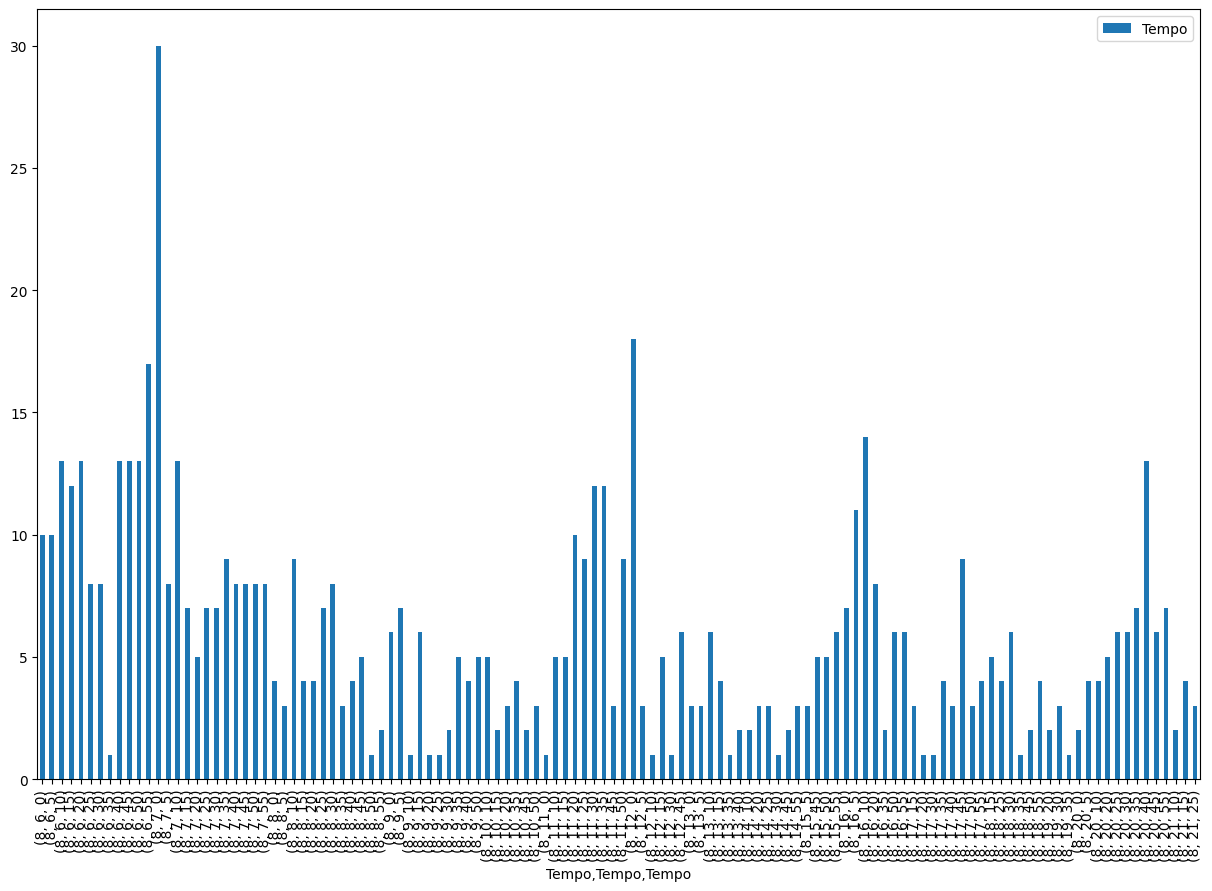

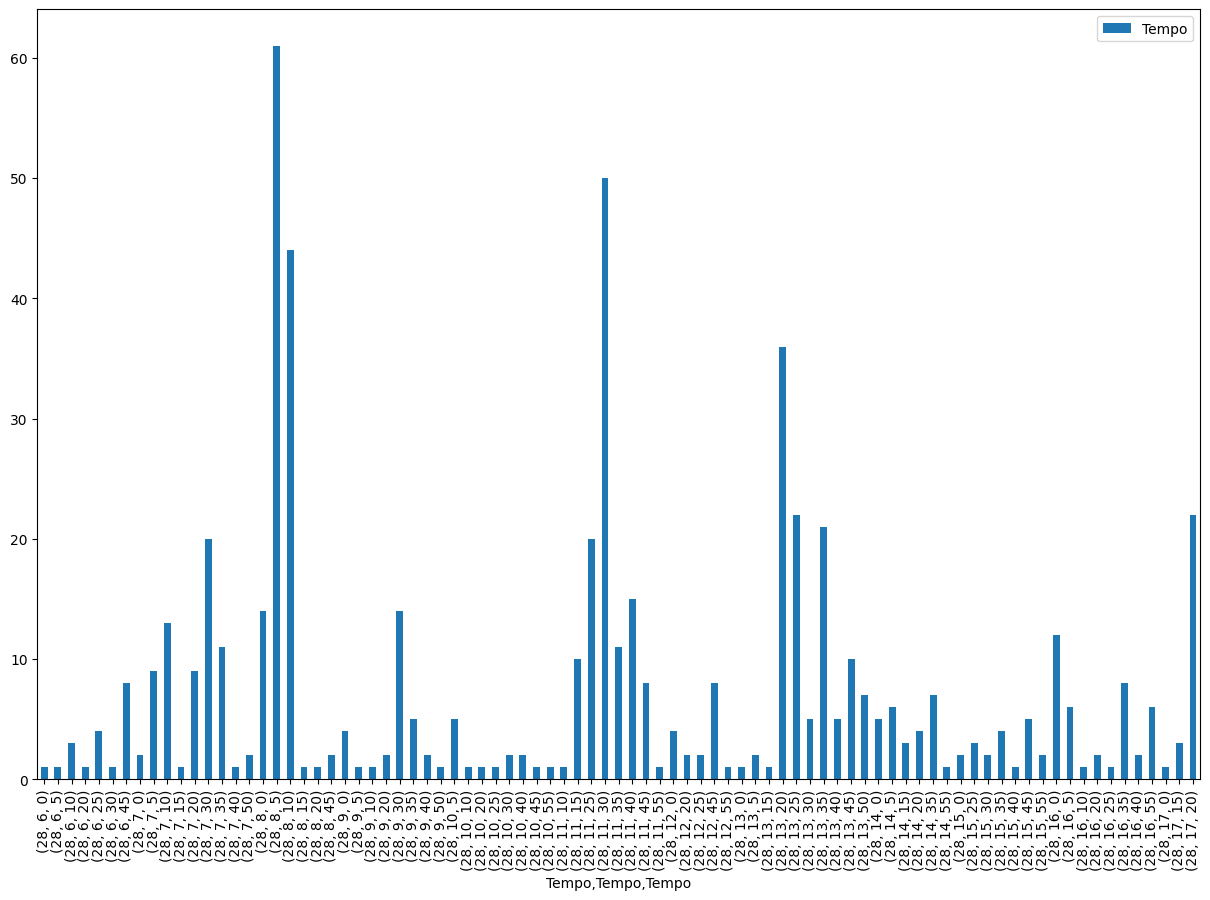

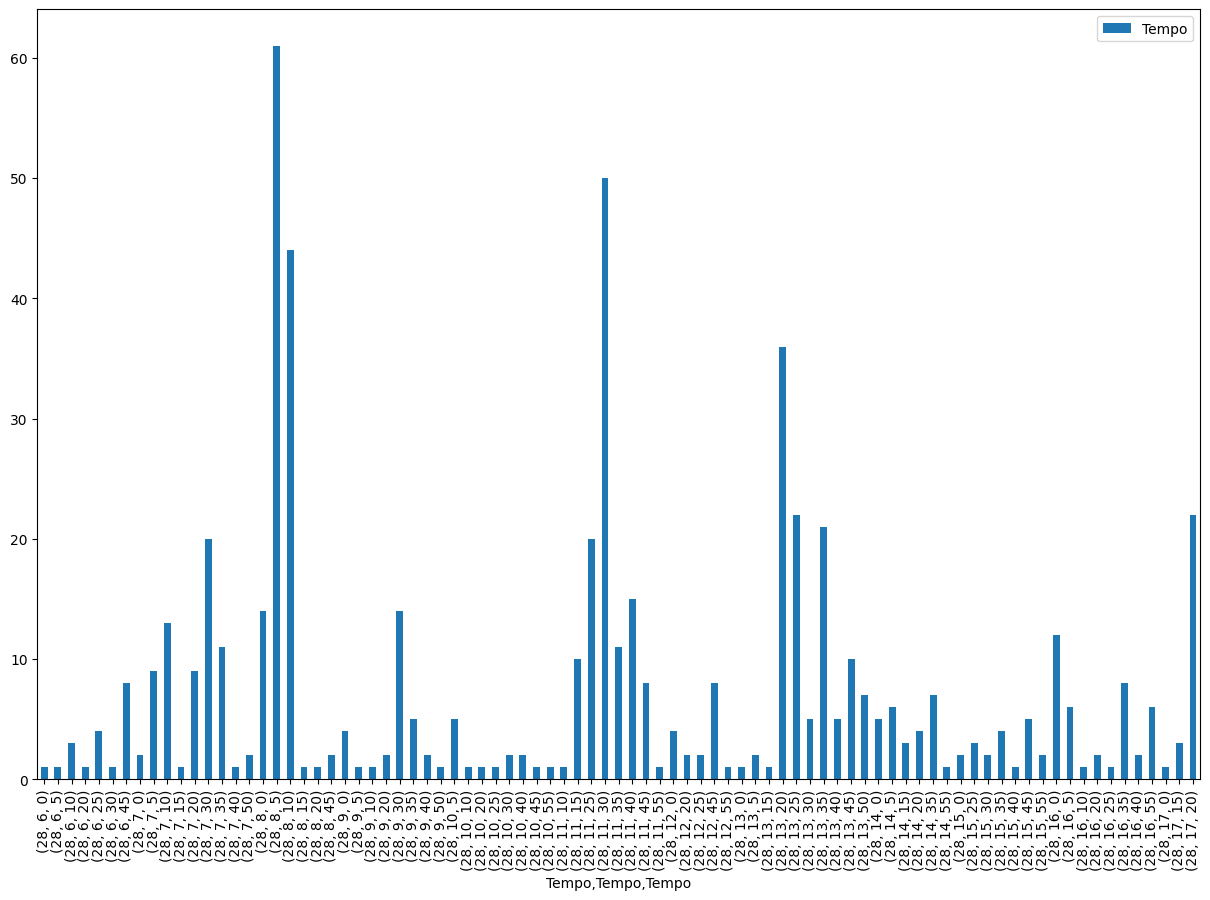

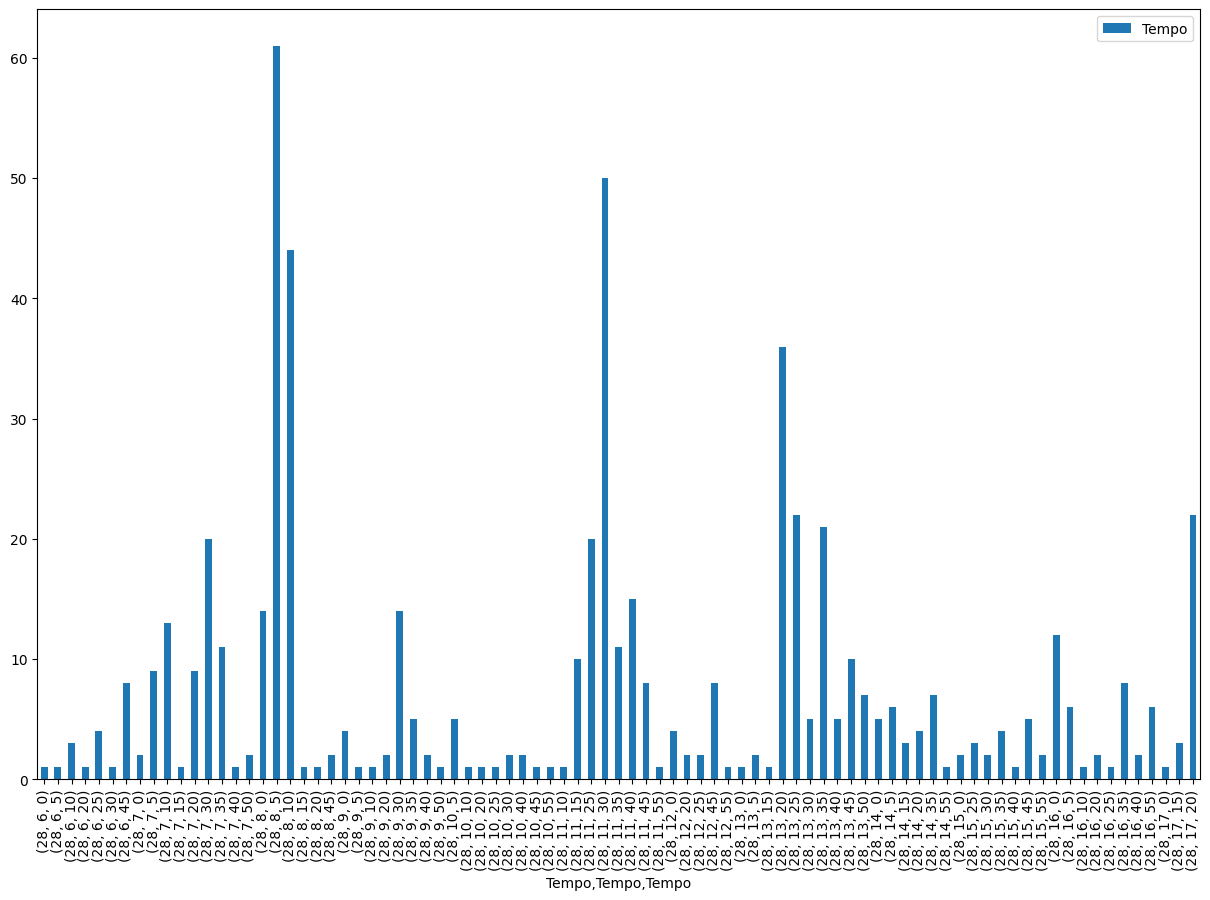

In [ ]:
from adtk.detector import SeasonalAD
from adtk.data import validate_series

import warnings
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)

# warnings.simplefilter("ignore")

contaminantes = 0.05

detectores = [
    SeasonalAD()
]

#sair = False
for evento in eventos:

  df = medidas(parquets, evento,1440,1440)
  print(evento,'DF Size',df.shape)
  # faixa de tempo do evento para avaliação
  #faixa = df.index.to_series().between(evento-timedelta(minutes=30),evento+timedelta(minutes=30))

  anomalias = []

  for col in df.columns:
    #if 'rocof' not in col: continue
    #print('COLUNA:',col)

    serie = df[col]#[faixa]
    #print('DF_SERIE:',serie)

    #Tratando a serie definindo explicitamente a frequência da série temporal antes de utilizar. .asfreq('T') converte a série temporal para uma frequência específica (minuto)
    #.dropna retirando os NaN da série.
    v_serie = validate_series(serie)
    v_serie = serie.asfreq('T').dropna()
    #print('ADTK_SERIE:',v_serie)

    for det in detectores:
      nome = det.__class__.__name__
      try:

        y_anom = det.fit_detect(v_serie)

        anom_mask = pd.Series(y_anom, index=v_serie.index).fillna(False)
        anom_mask = anom_mask.reindex(df.index, fill_value=False)
        #anomalias.extend(list(df[y_anom].index))
        anomalias.extend(list(df[anom_mask].index))

      except Exception as e:
        #print('Erro: ', e)
        #print('serie: ', v_serie)
        #print('-----')
        #print(v_serie)
        #print('-----')
        print(col, end=' ')
        #break
    #break
  #break
  print('')
  print('Anomalias=',len(anomalias))
  if len(anomalias) > 0:
    ano = pd.DataFrame({'Tempo':anomalias})
    ano.groupby([ano['Tempo'].dt.day,ano['Tempo'].dt.hour,(ano['Tempo'].dt.minute//5)*5]).count().plot(kind="bar")

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
ano.groupby([ano['Tempo'].dt.hour,(ano['Tempo'].dt.minute//5)*5]).count().plot(kind="bar")

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
ano.groupby([ano['Tempo'].dt.hour,(ano['Tempo'].dt.minute//5)*5]).count().plot(kind="bar")

## Estudo nos detectores (SeasonalAD, QuantileAD, OutlierDetector, dentre outros)

Nome detector: SeasonalAD 
Evento: 2021-04-08 18:34:00
Nome detector: QuantileAD 
Evento: 2021-04-08 18:34:00
Nome detector: OutlierDetector 
Evento: 2021-04-08 18:34:00
Nome detector: GeneralizedESDTestAD 
Evento: 2021-04-08 18:34:00
Nome detector: MinClusterDetector 
Evento: 2021-04-08 18:34:00
Nome detector: PcaAD 
Evento: 2021-04-08 18:34:00
Nome detector: SeasonalAD 
Evento: 2021-05-28 11:06:00
Nome detector: QuantileAD 
Evento: 2021-05-28 11:06:00
Nome detector: OutlierDetector 
Evento: 2021-05-28 11:06:00
Nome detector: GeneralizedESDTestAD 
Evento: 2021-05-28 11:06:00
Nome detector: MinClusterDetector 
Evento: 2021-05-28 11:06:00
Nome detector: PcaAD 
Evento: 2021-05-28 11:06:00
Nome detector: SeasonalAD 
Evento: 2021-05-28 11:26:00
Nome detector: QuantileAD 
Evento: 2021-05-28 11:26:00
Nome detector: OutlierDetector 
Evento: 2021-05-28 11:26:00
Nome detector: GeneralizedESDTestAD 
Evento: 2021-05-28 11:26:00
Nome detector: MinClusterDetector 
Evento: 2021-05-28 11:26:00
Nome d

ValueError: Number of rows must be a positive integer, not 0

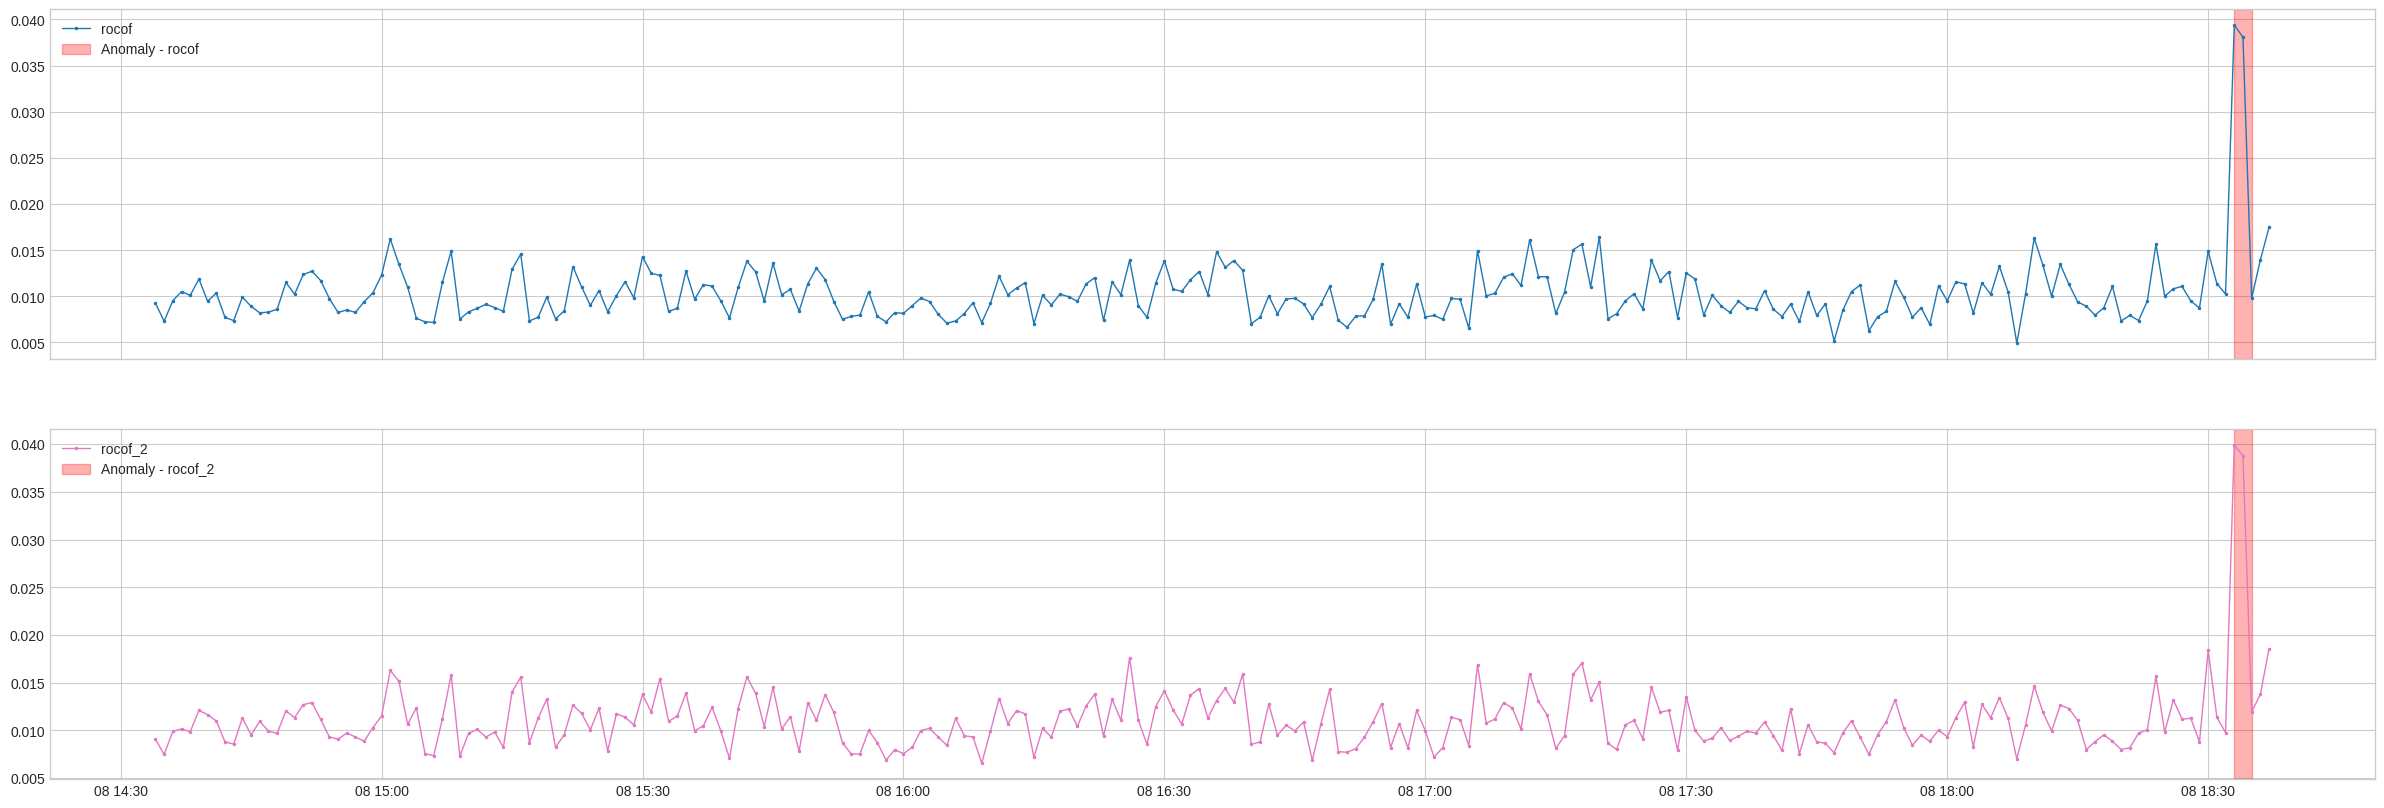

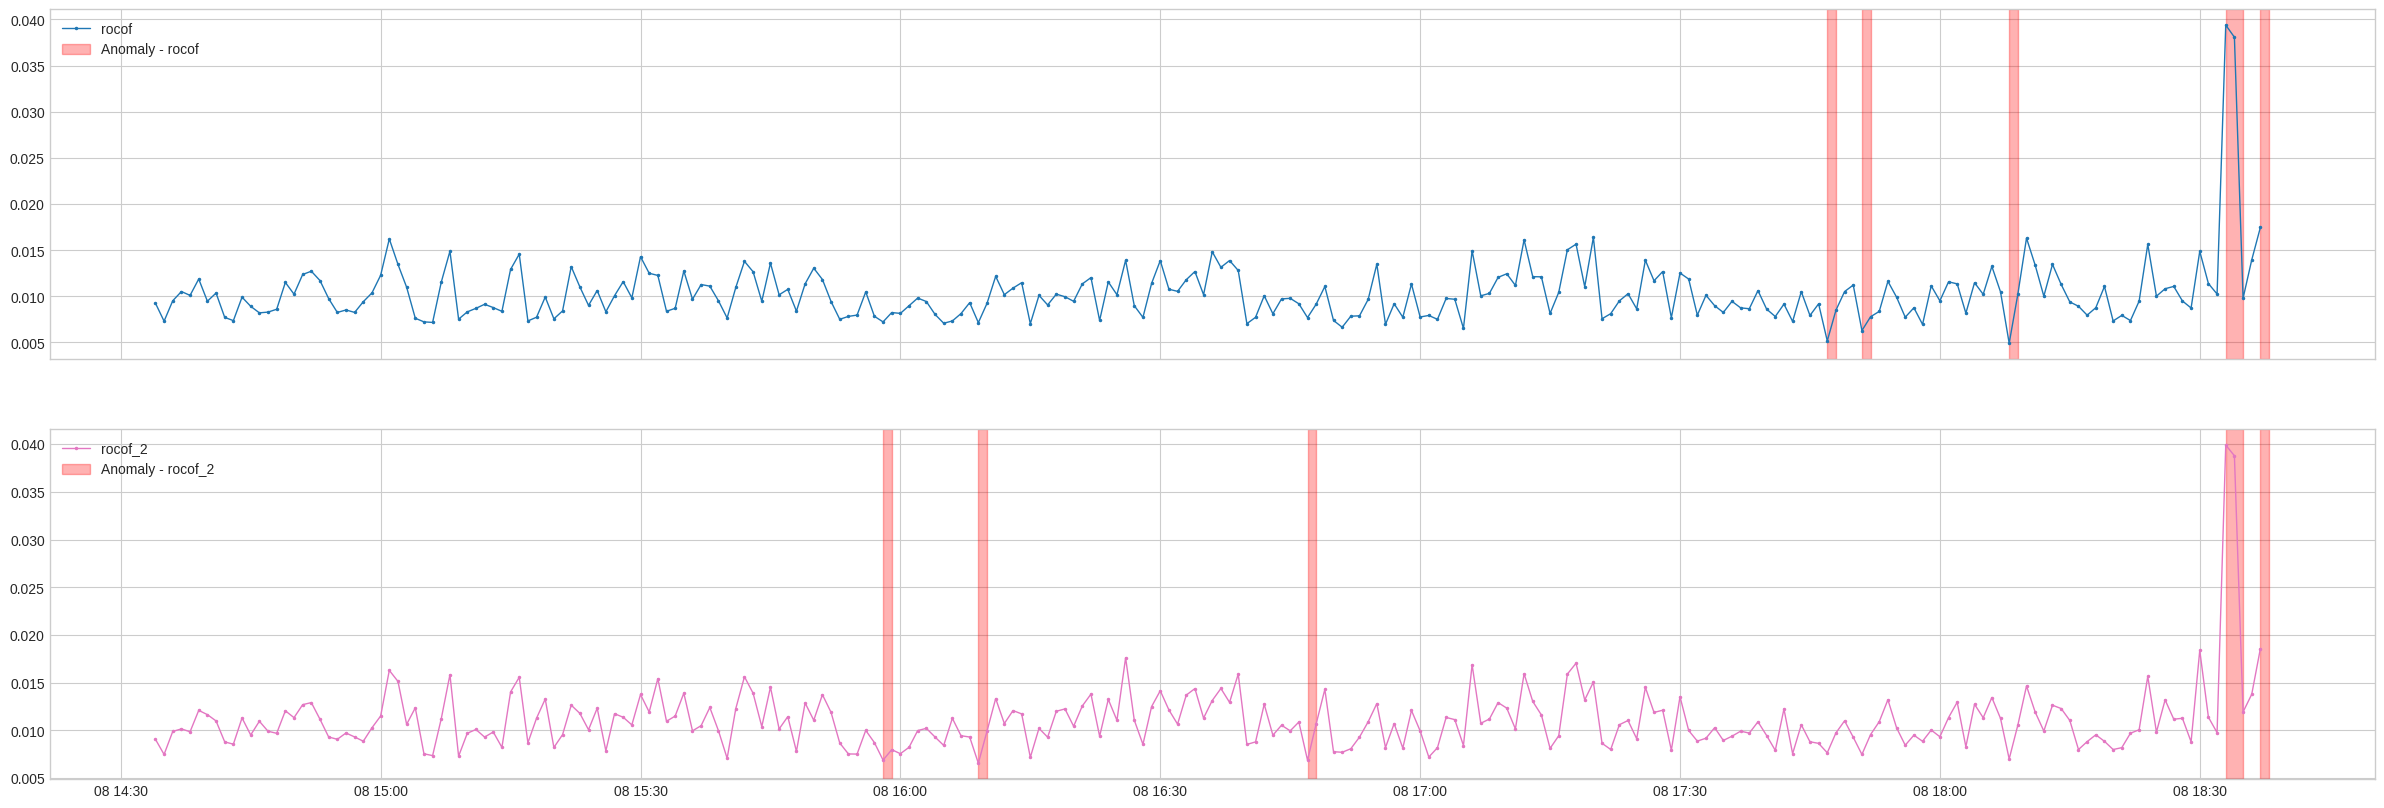

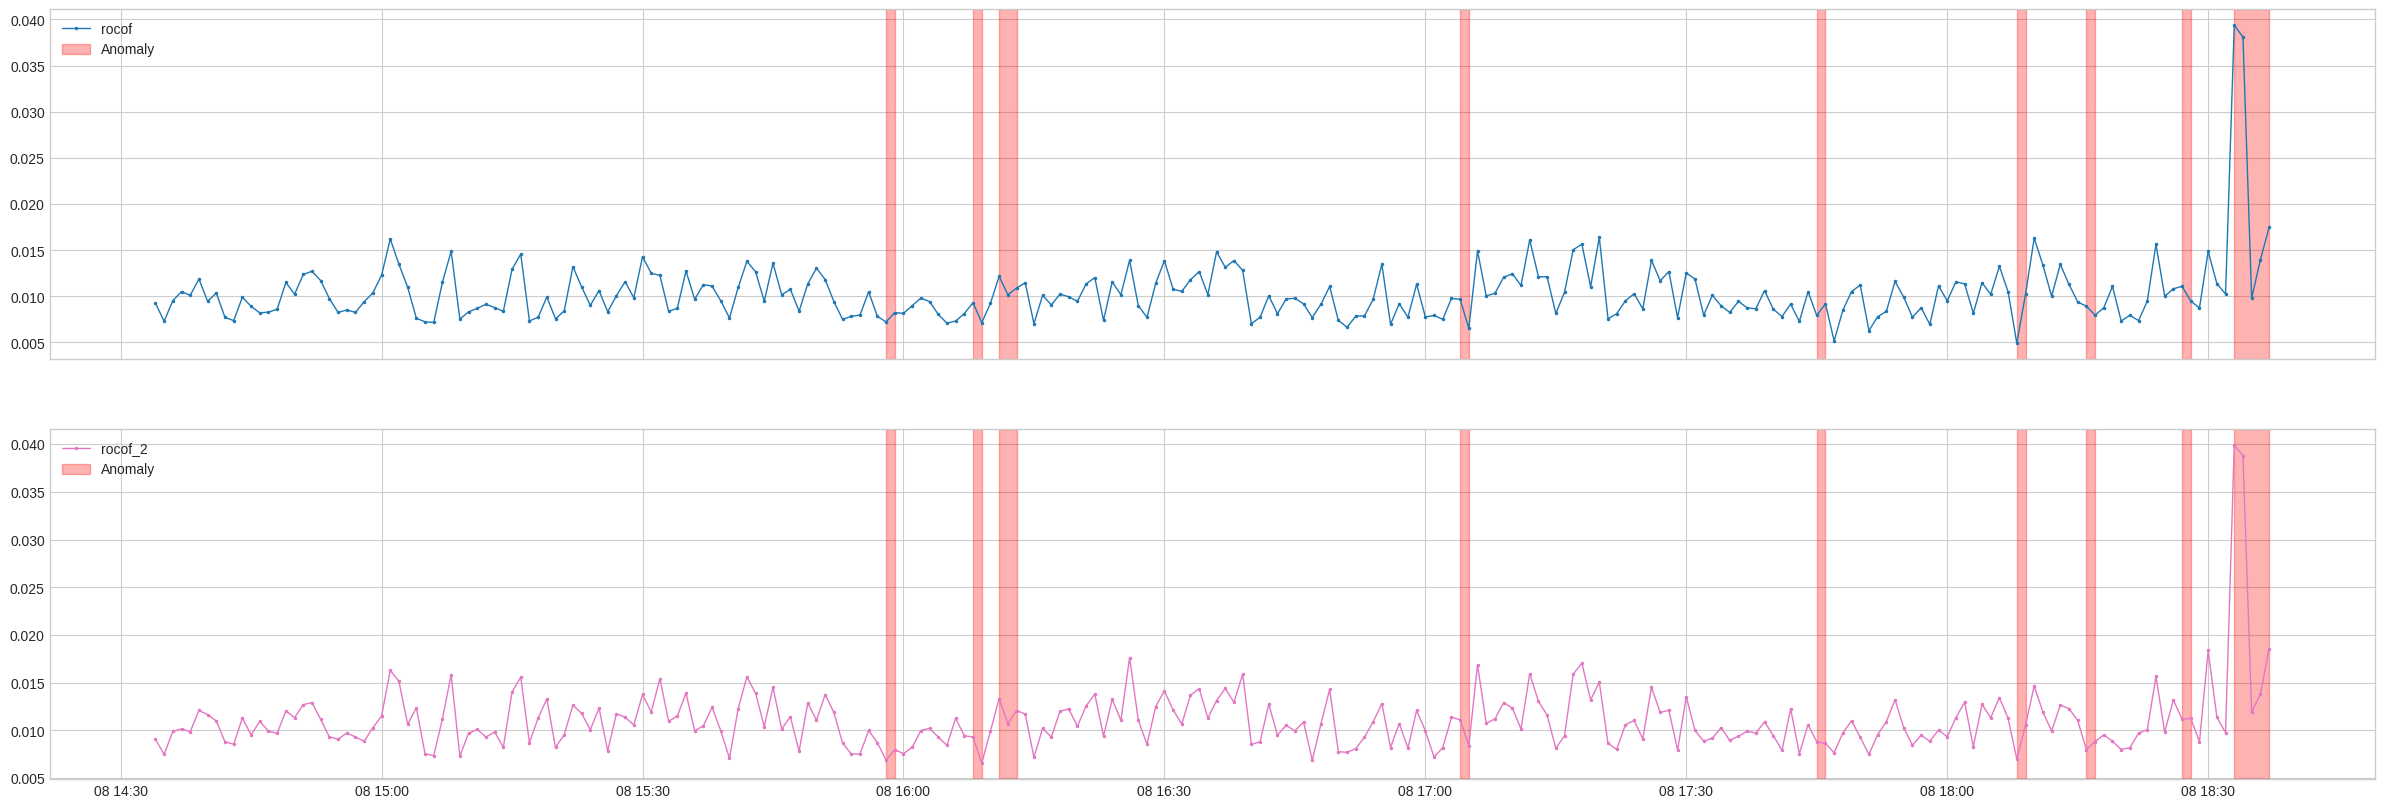

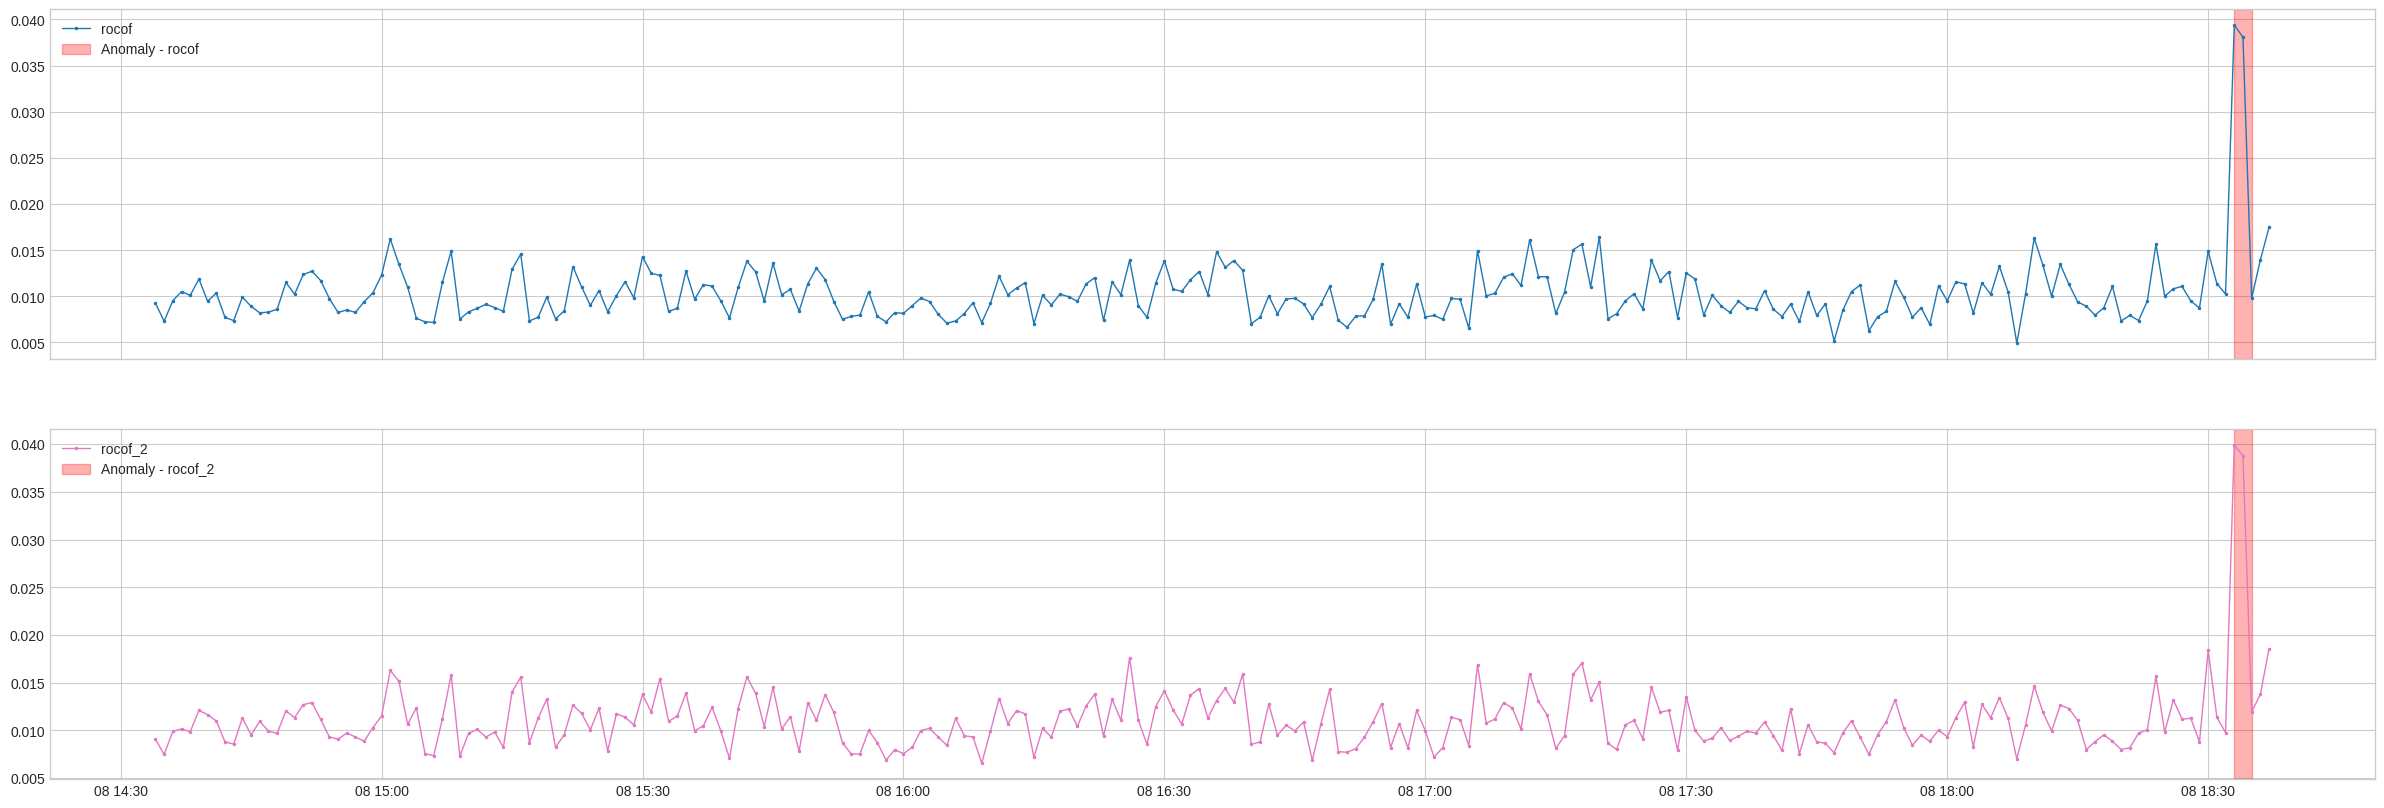

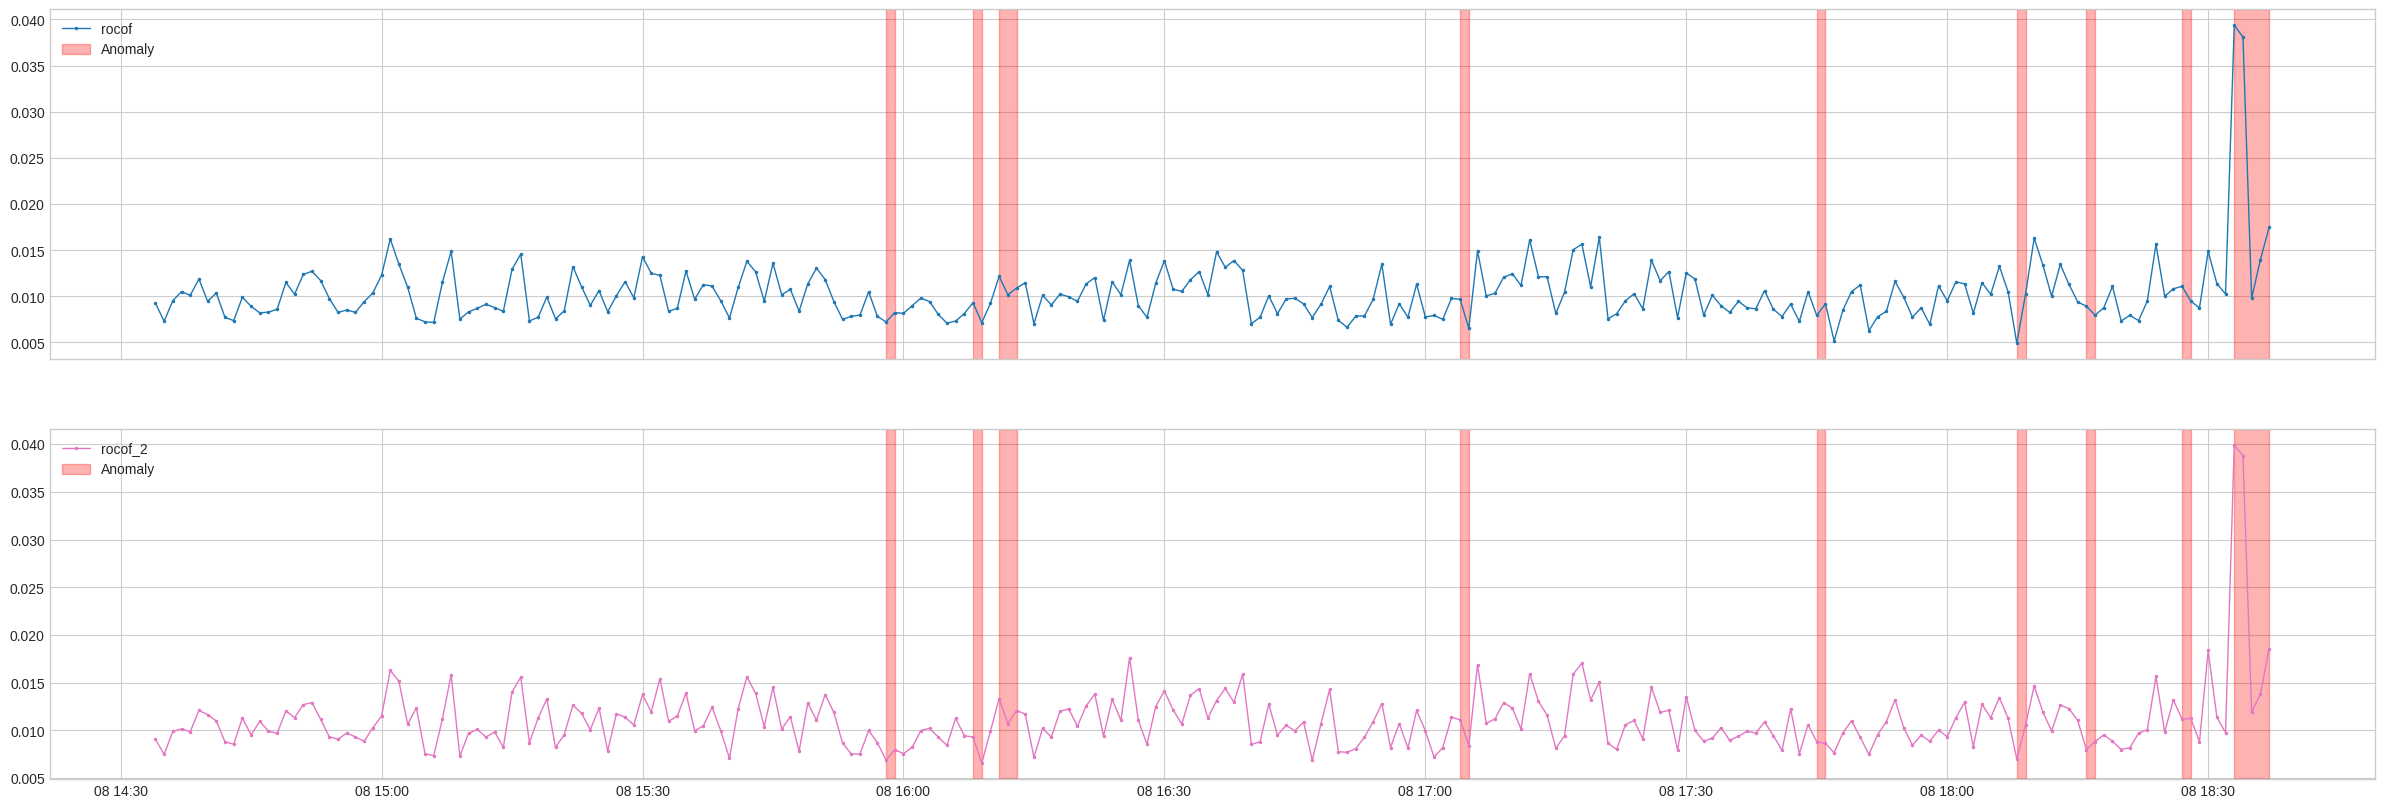

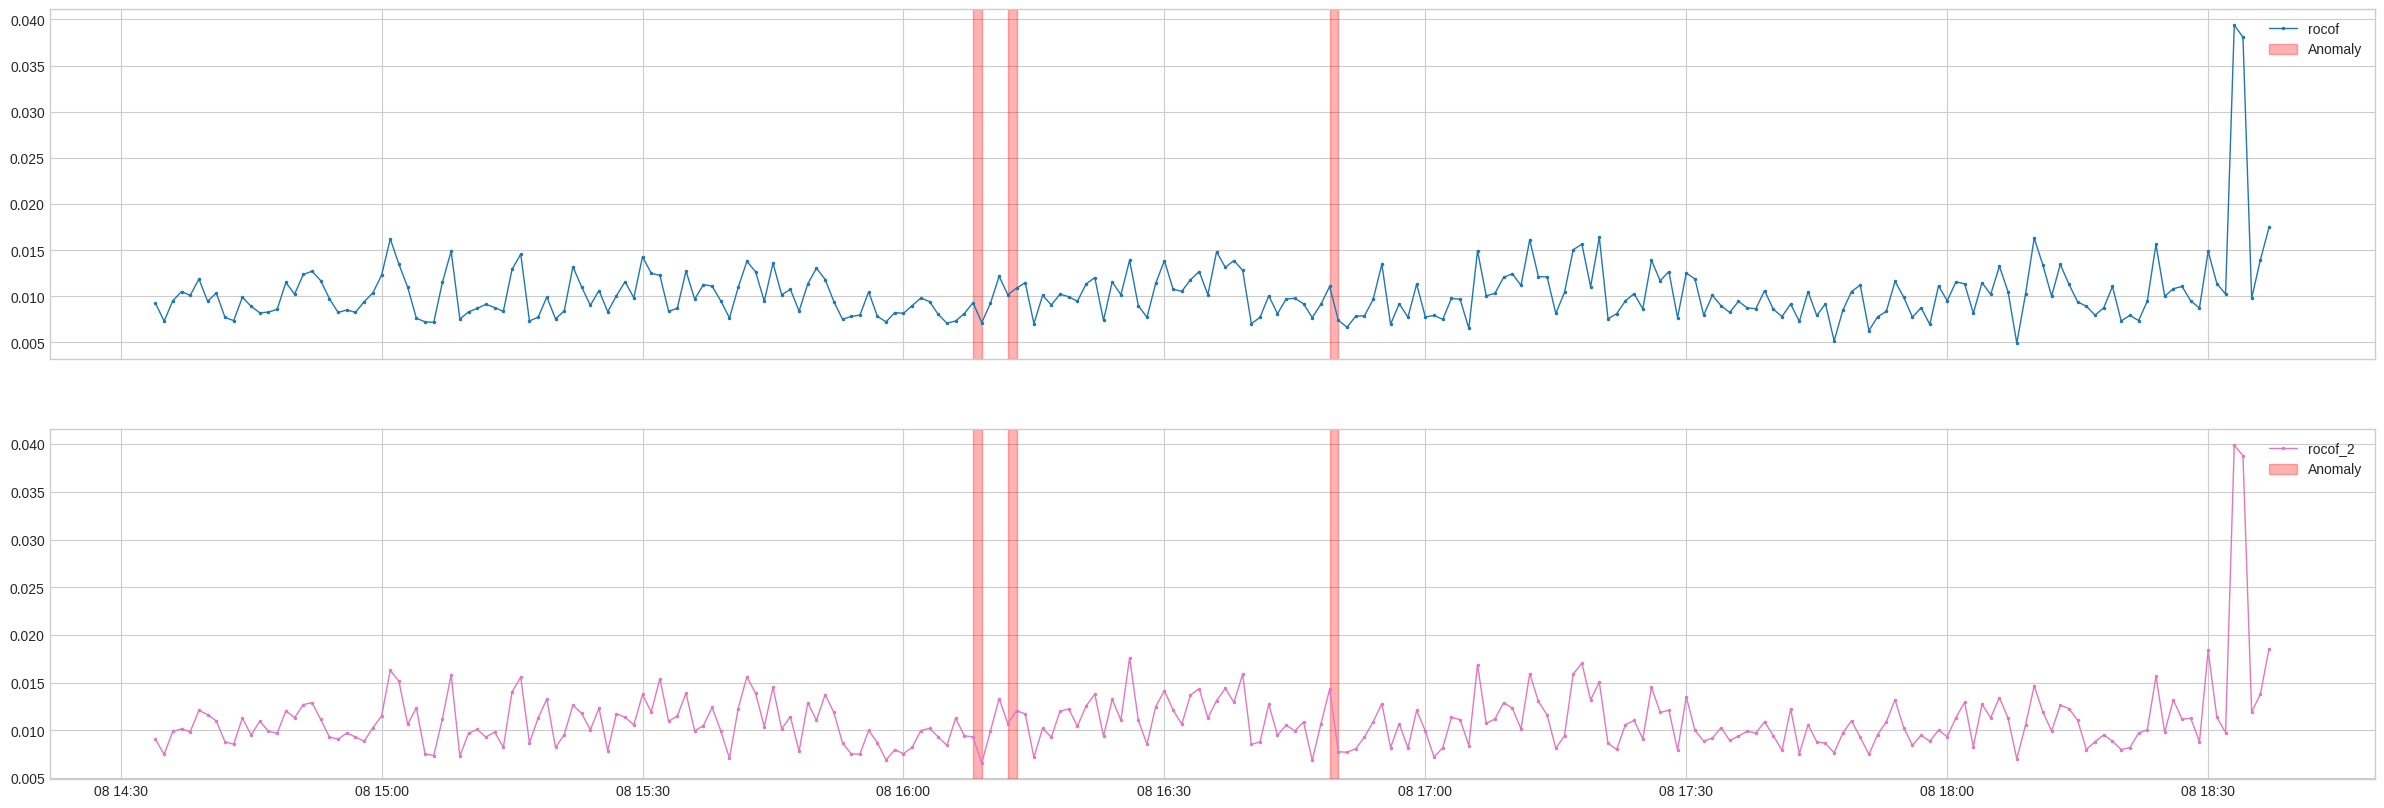

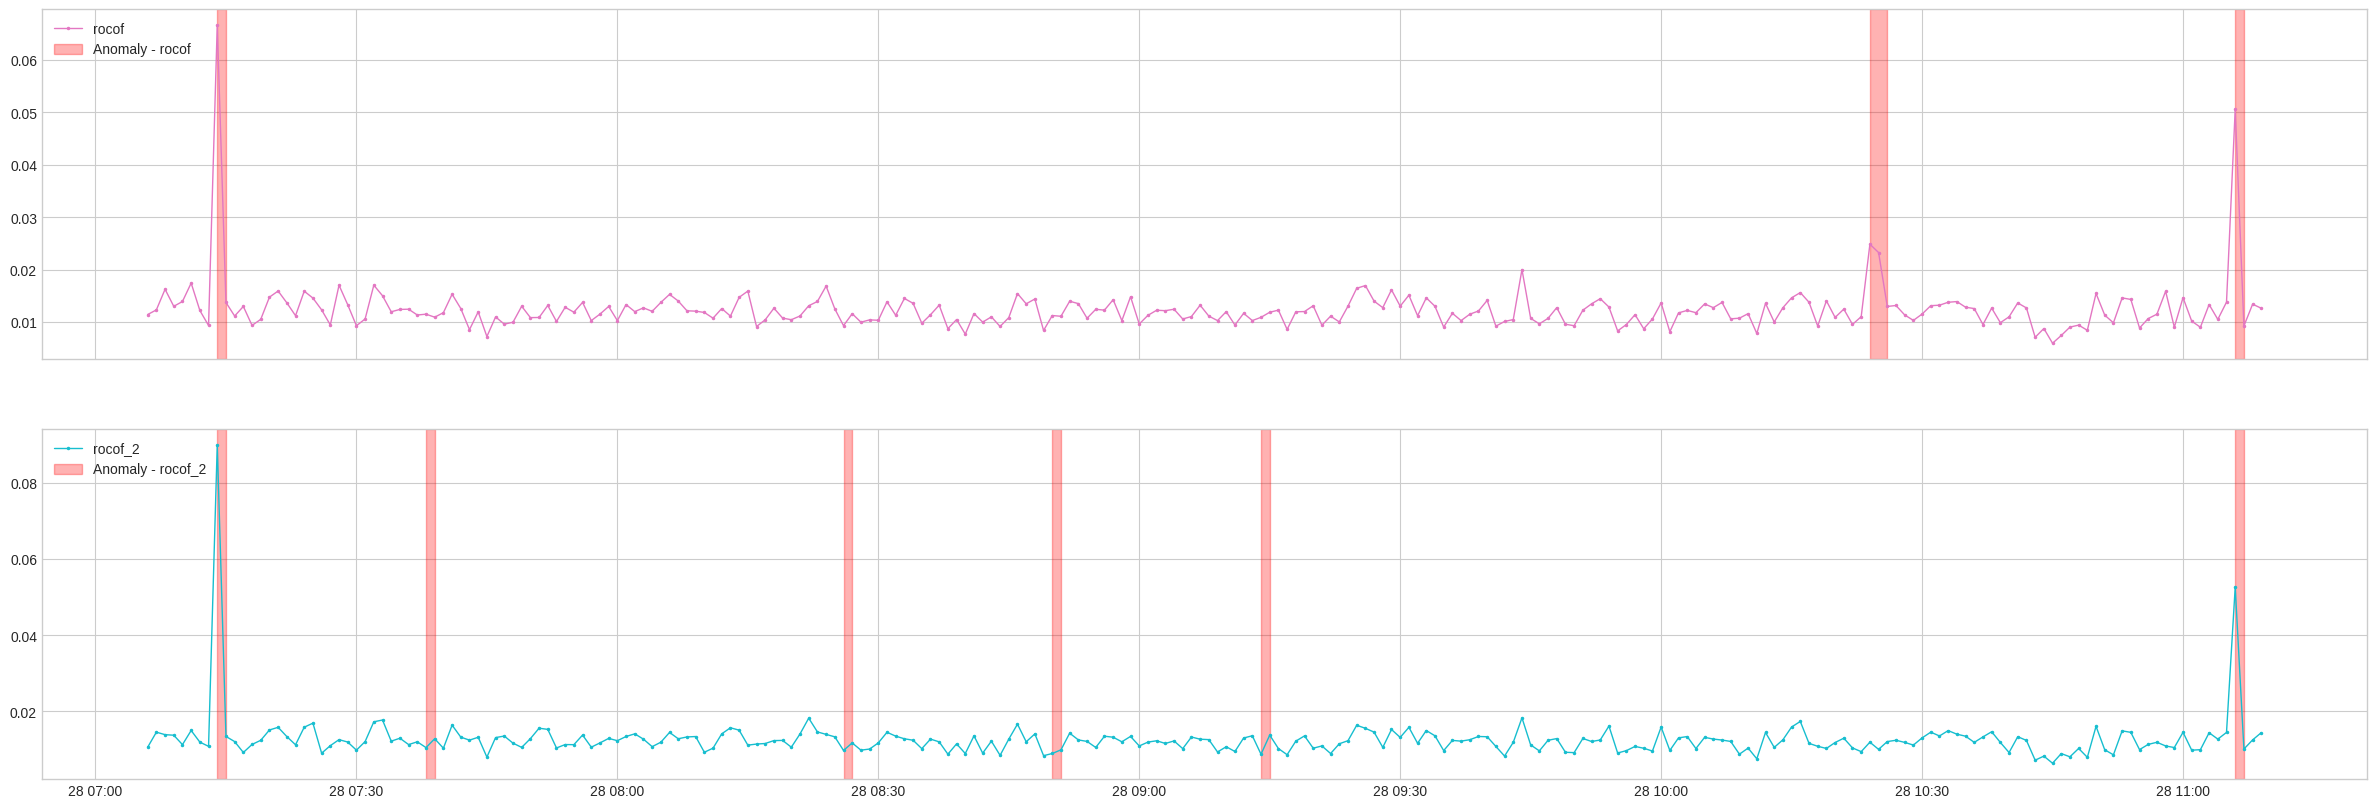

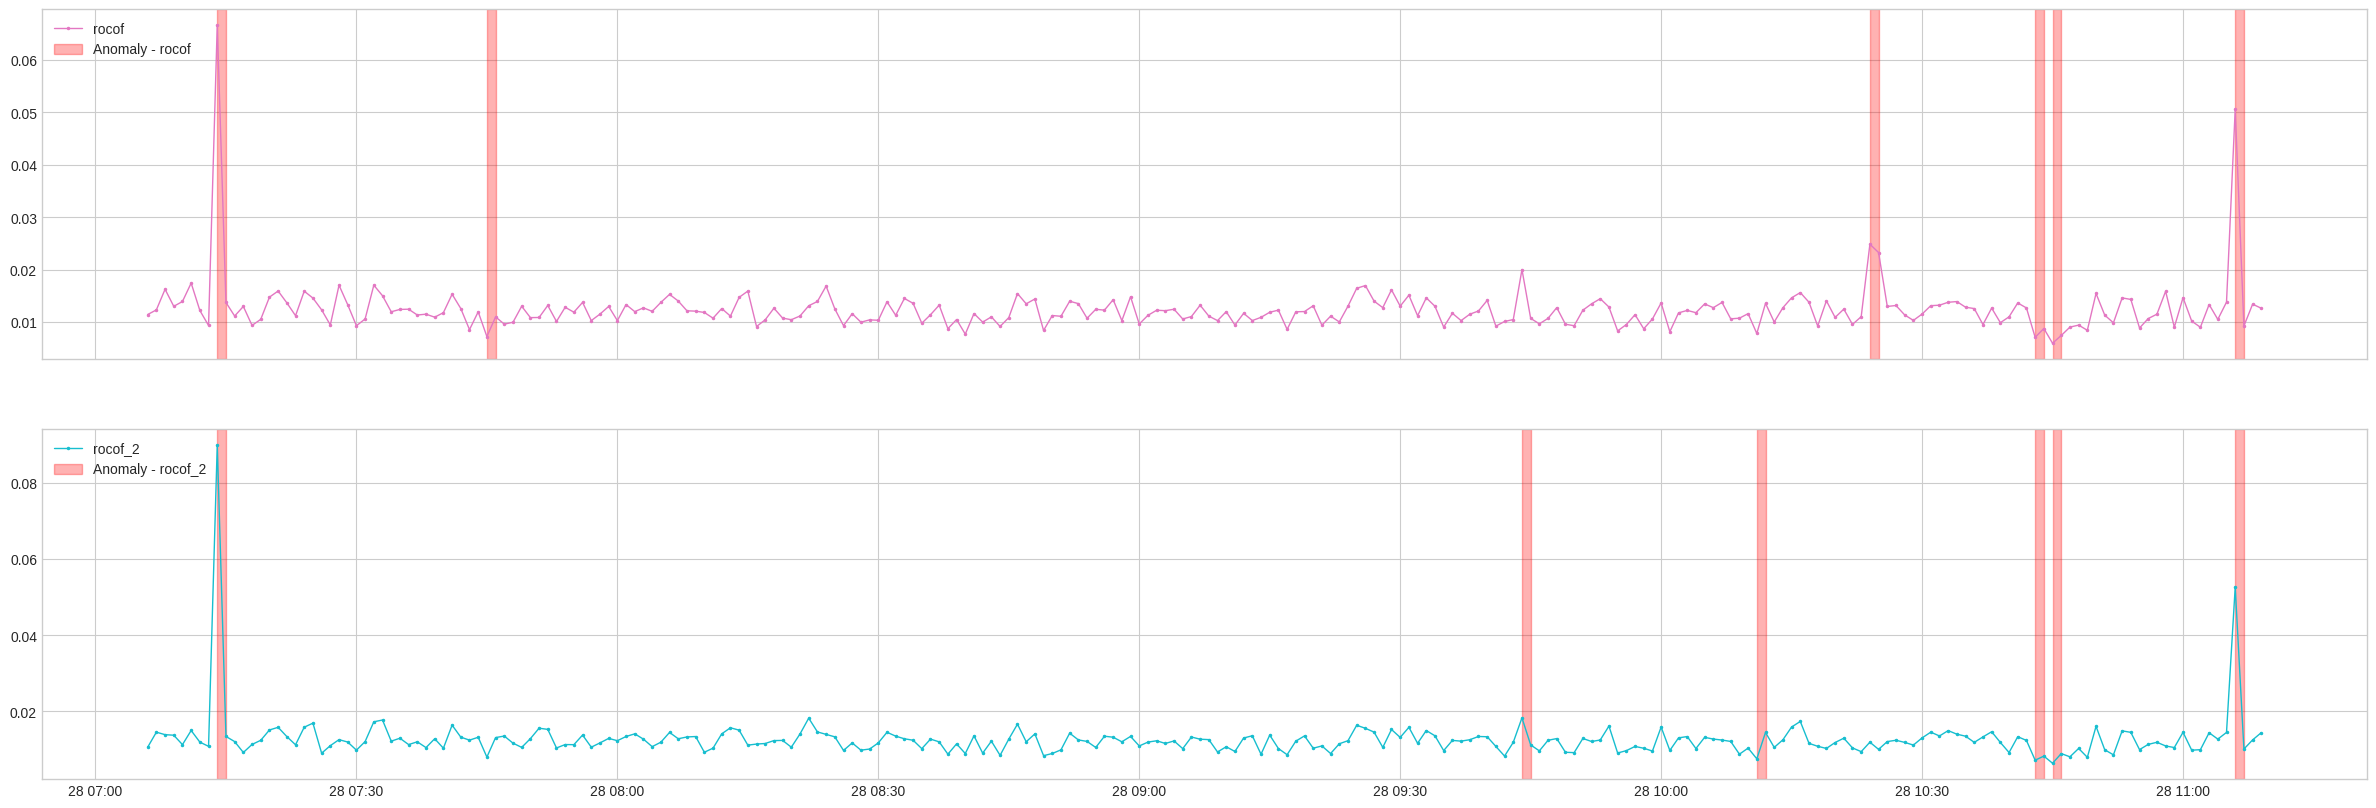

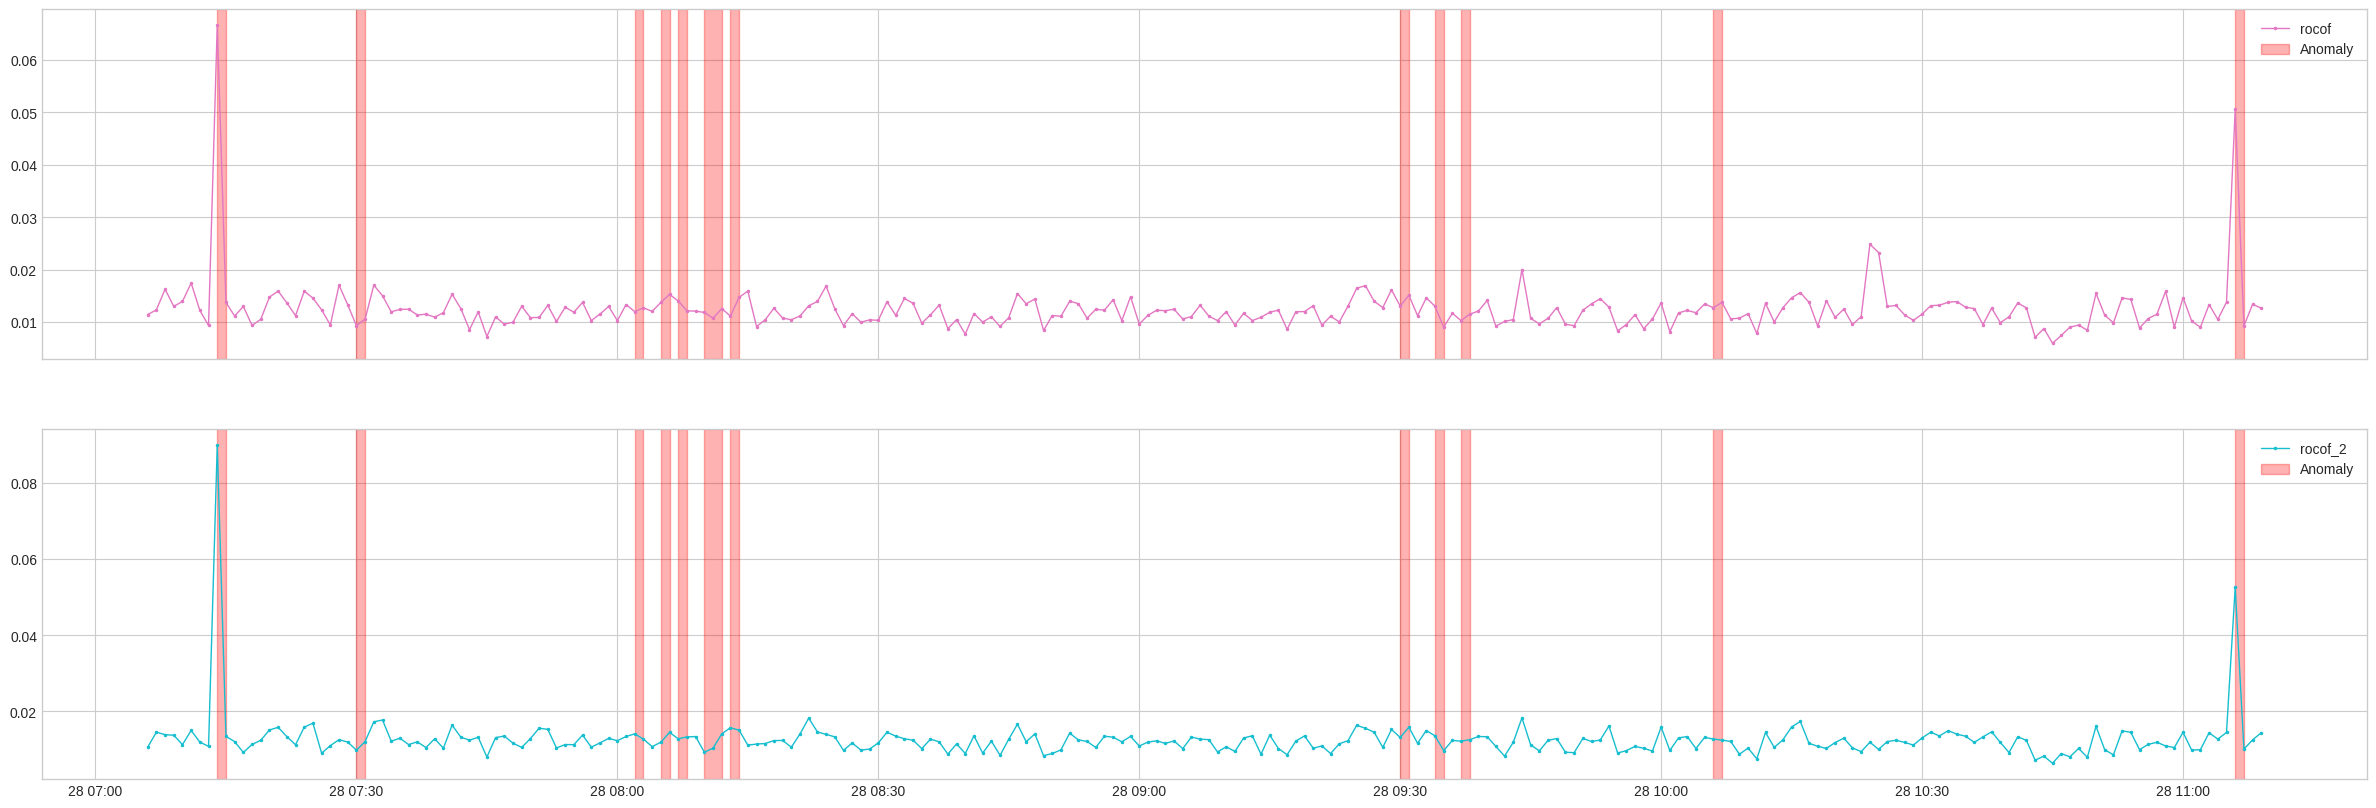

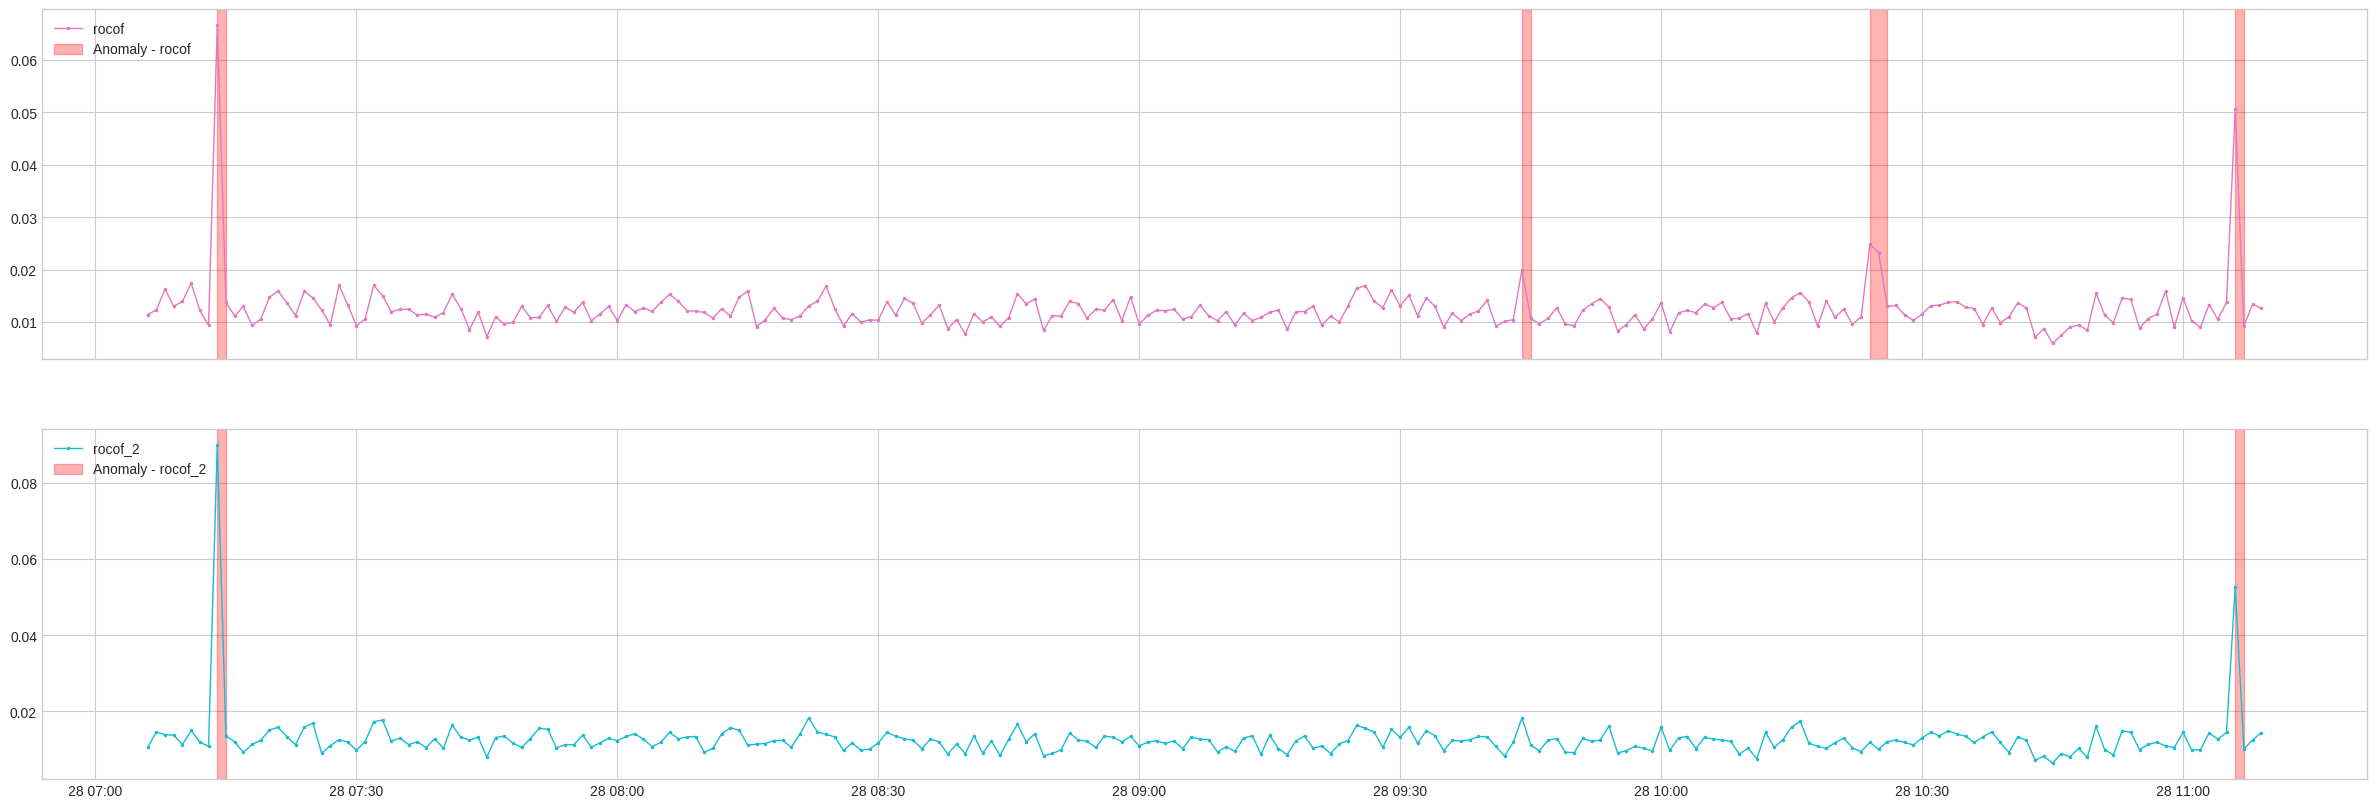

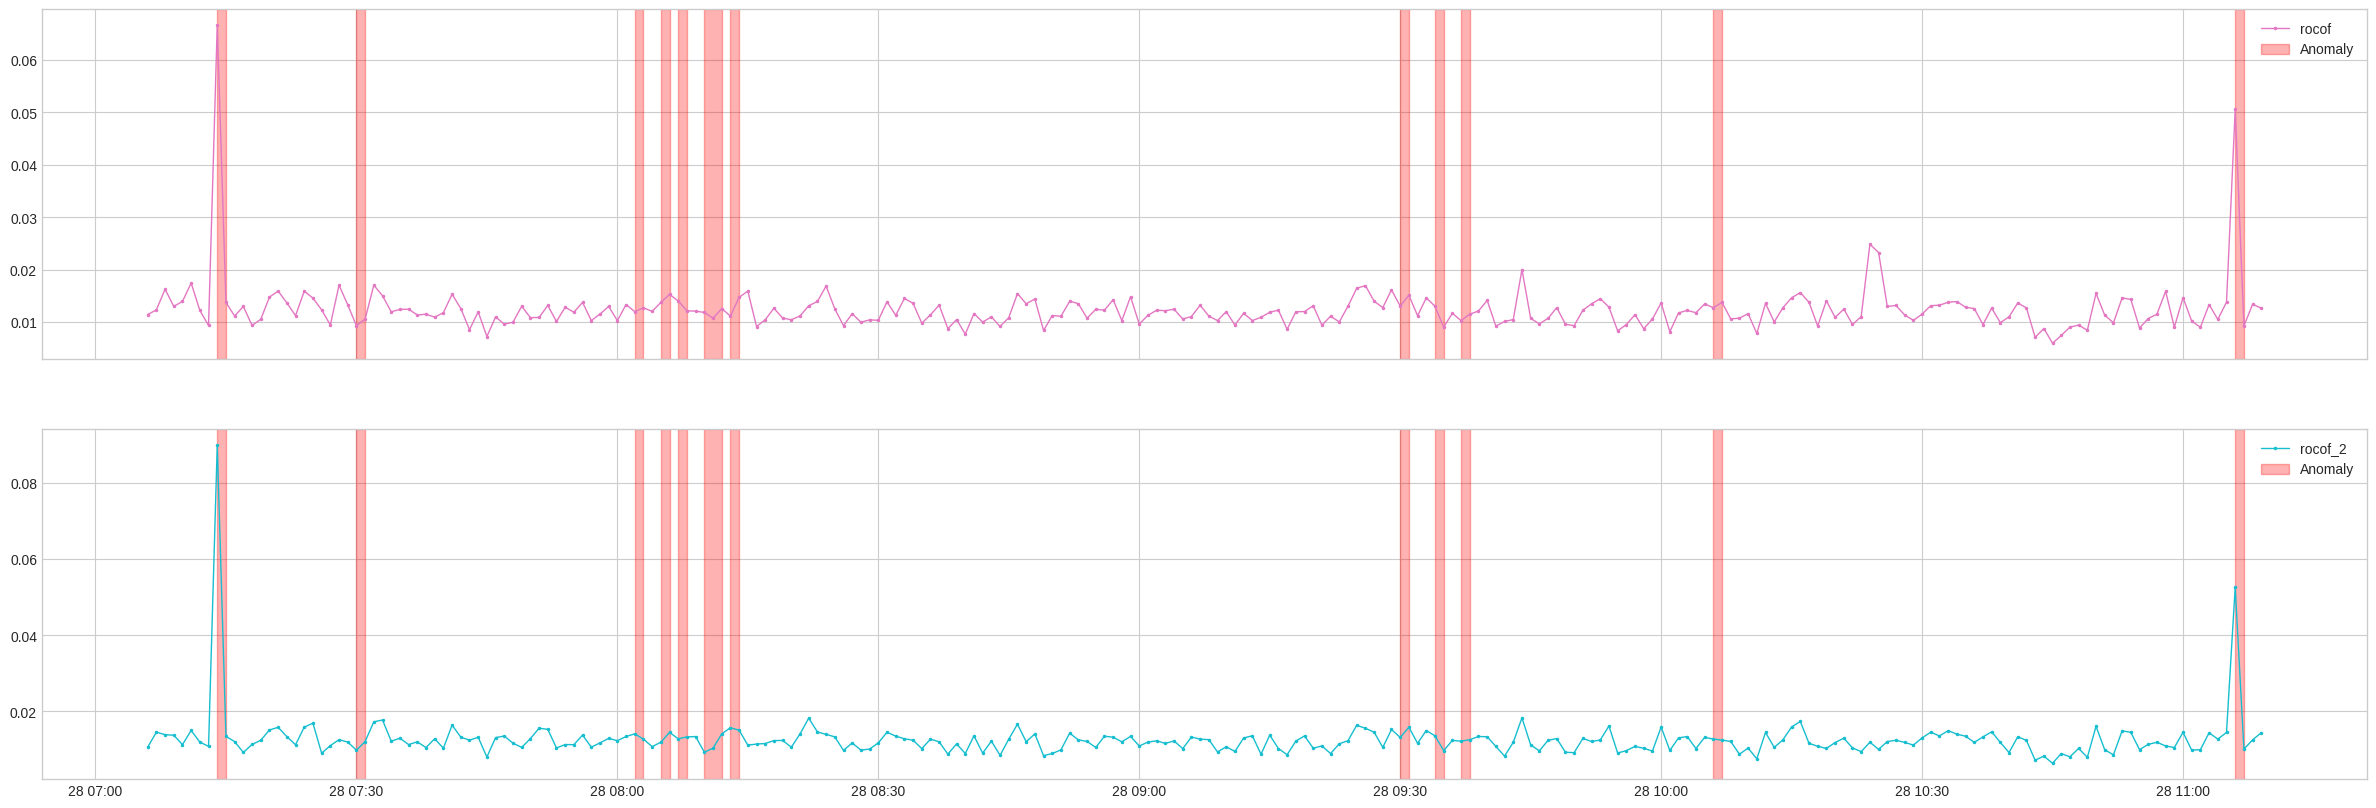

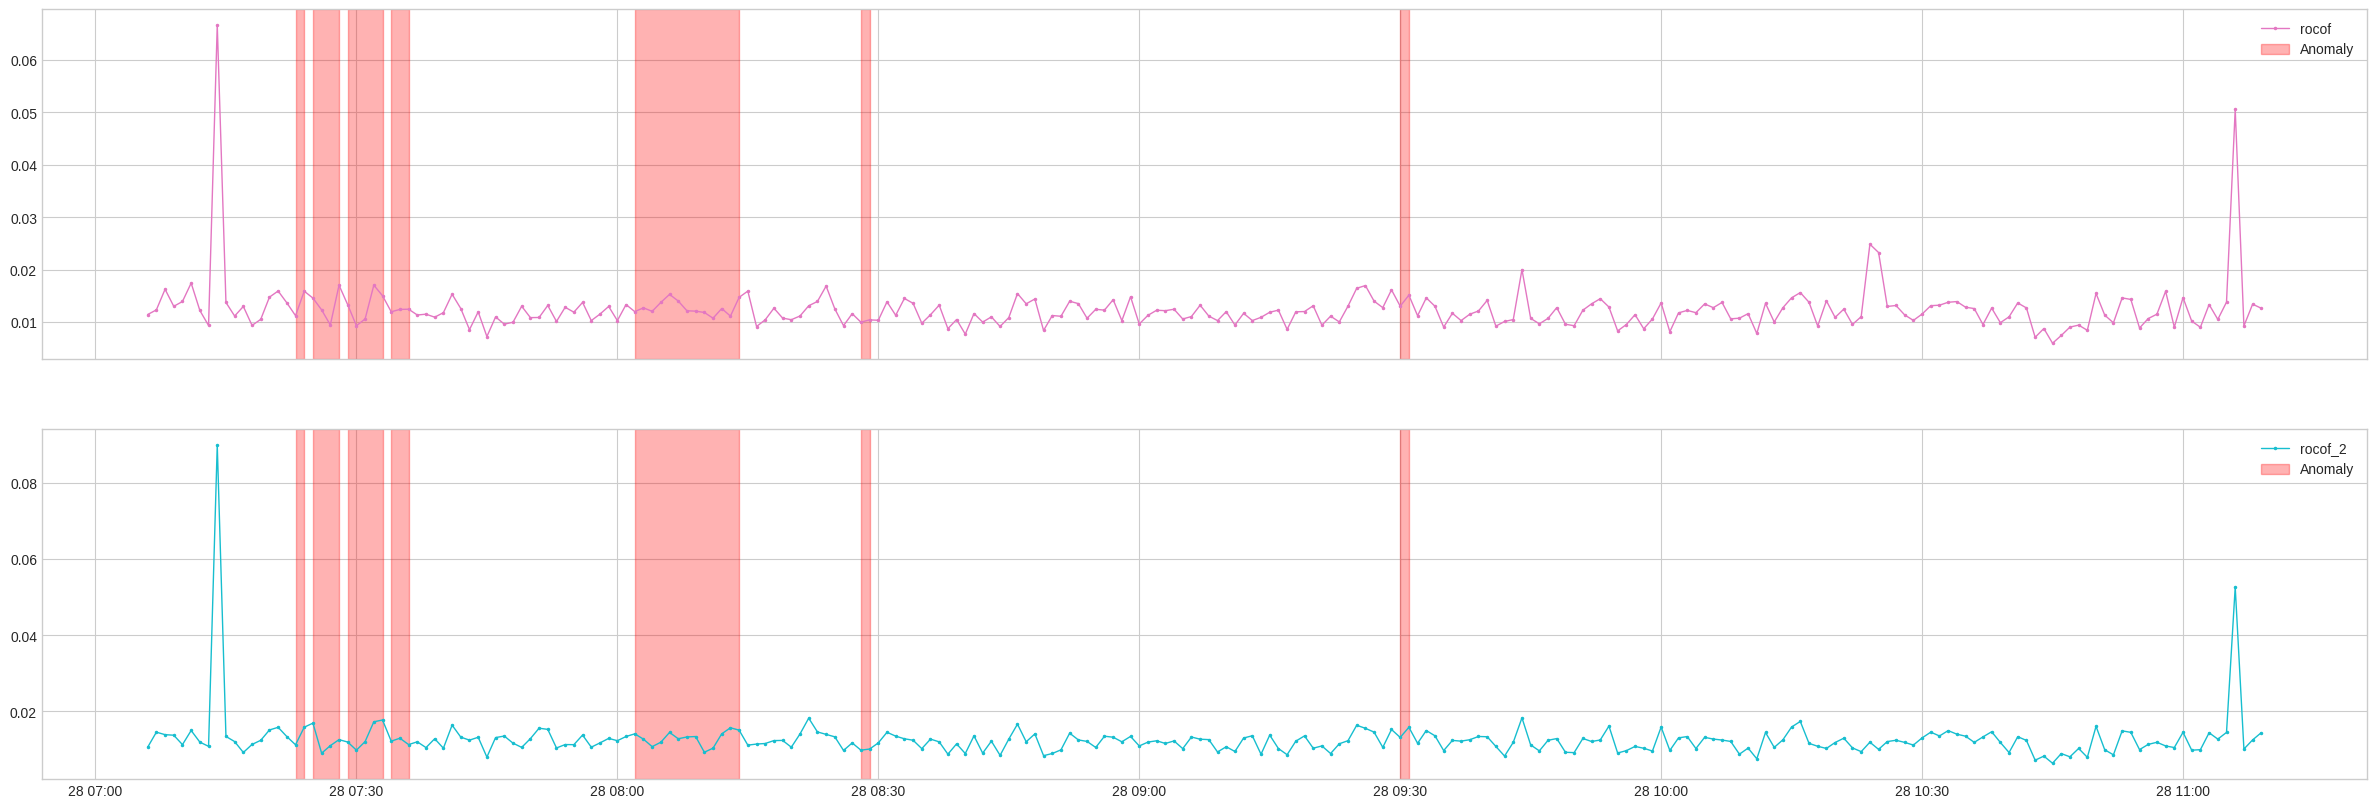

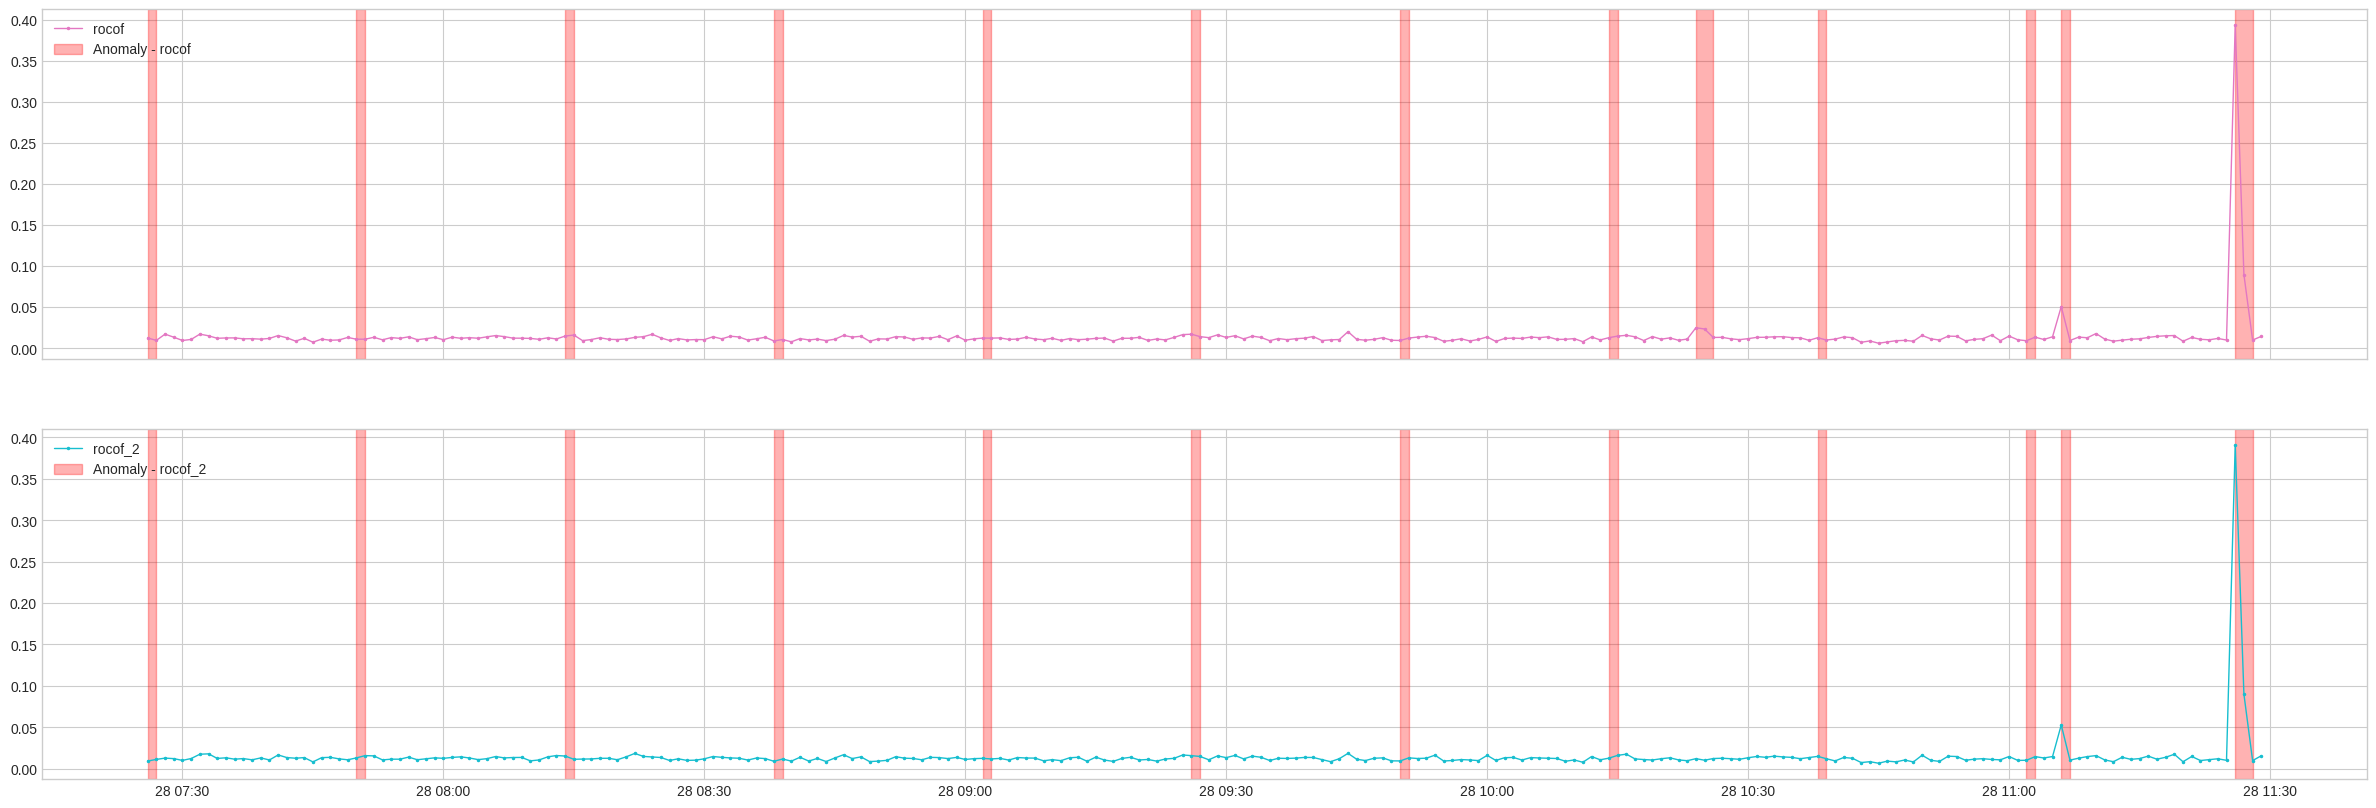

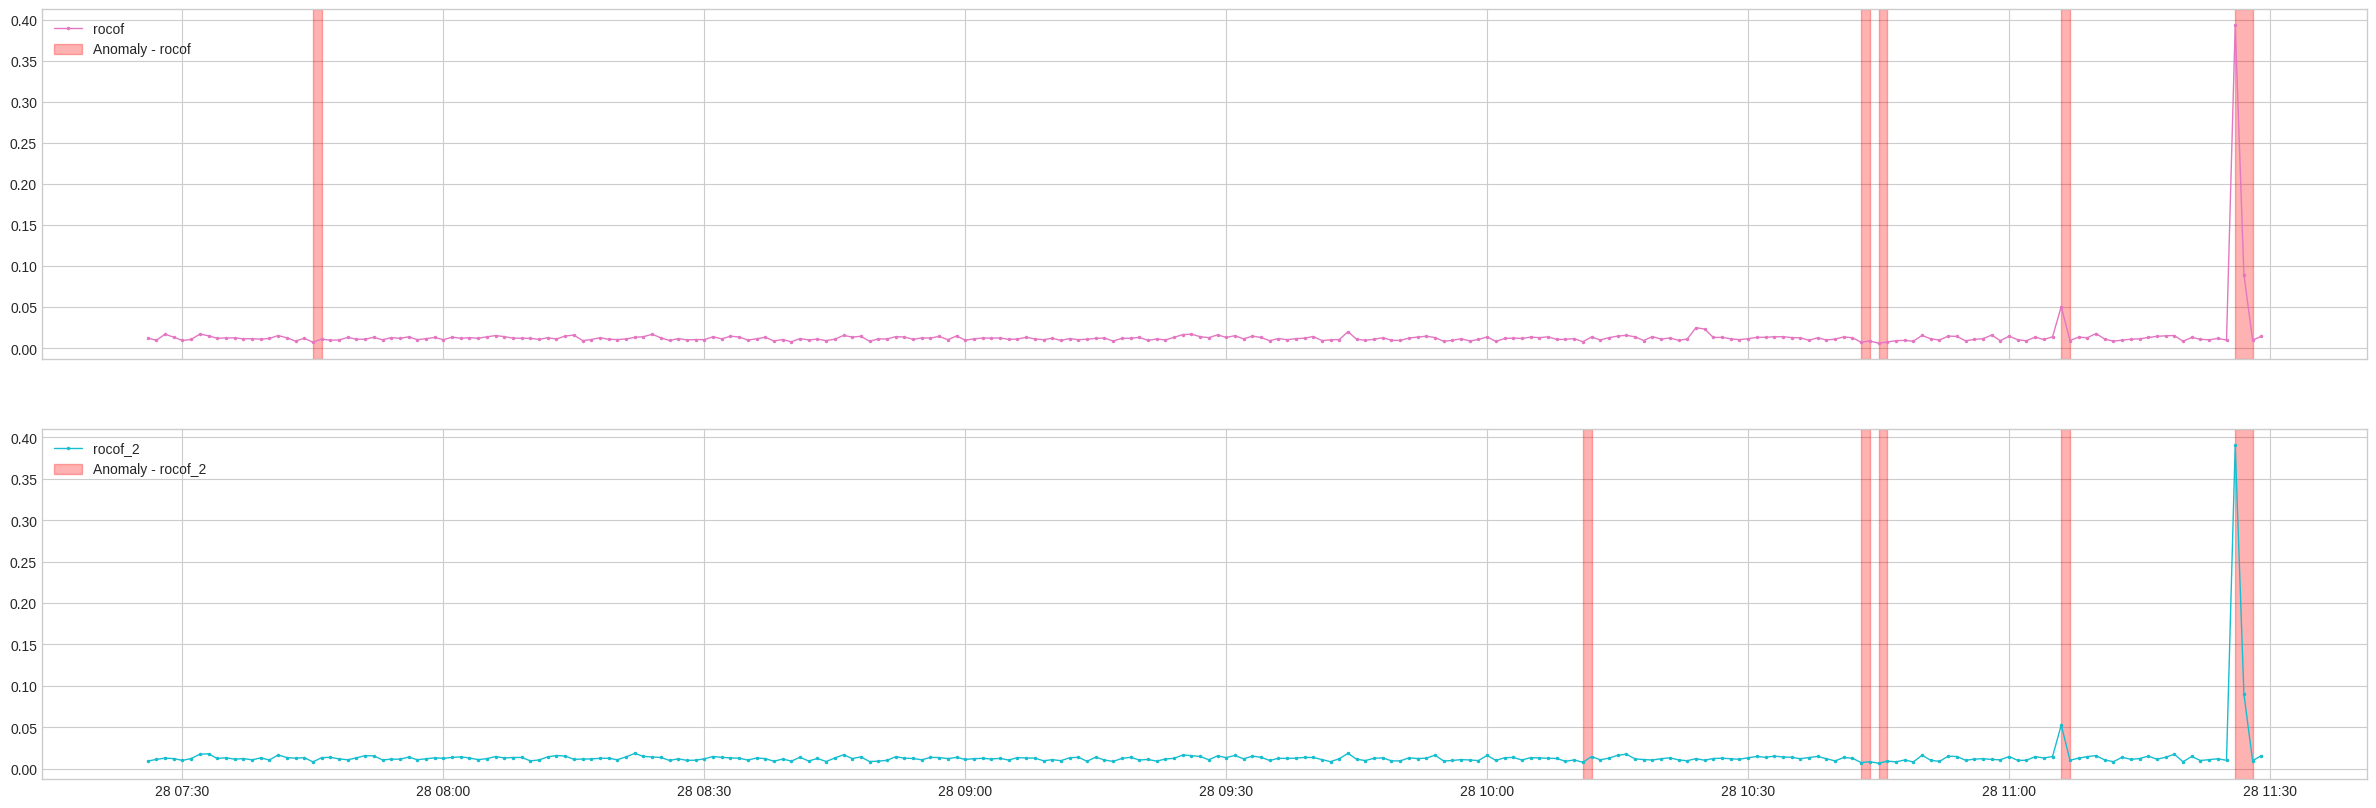

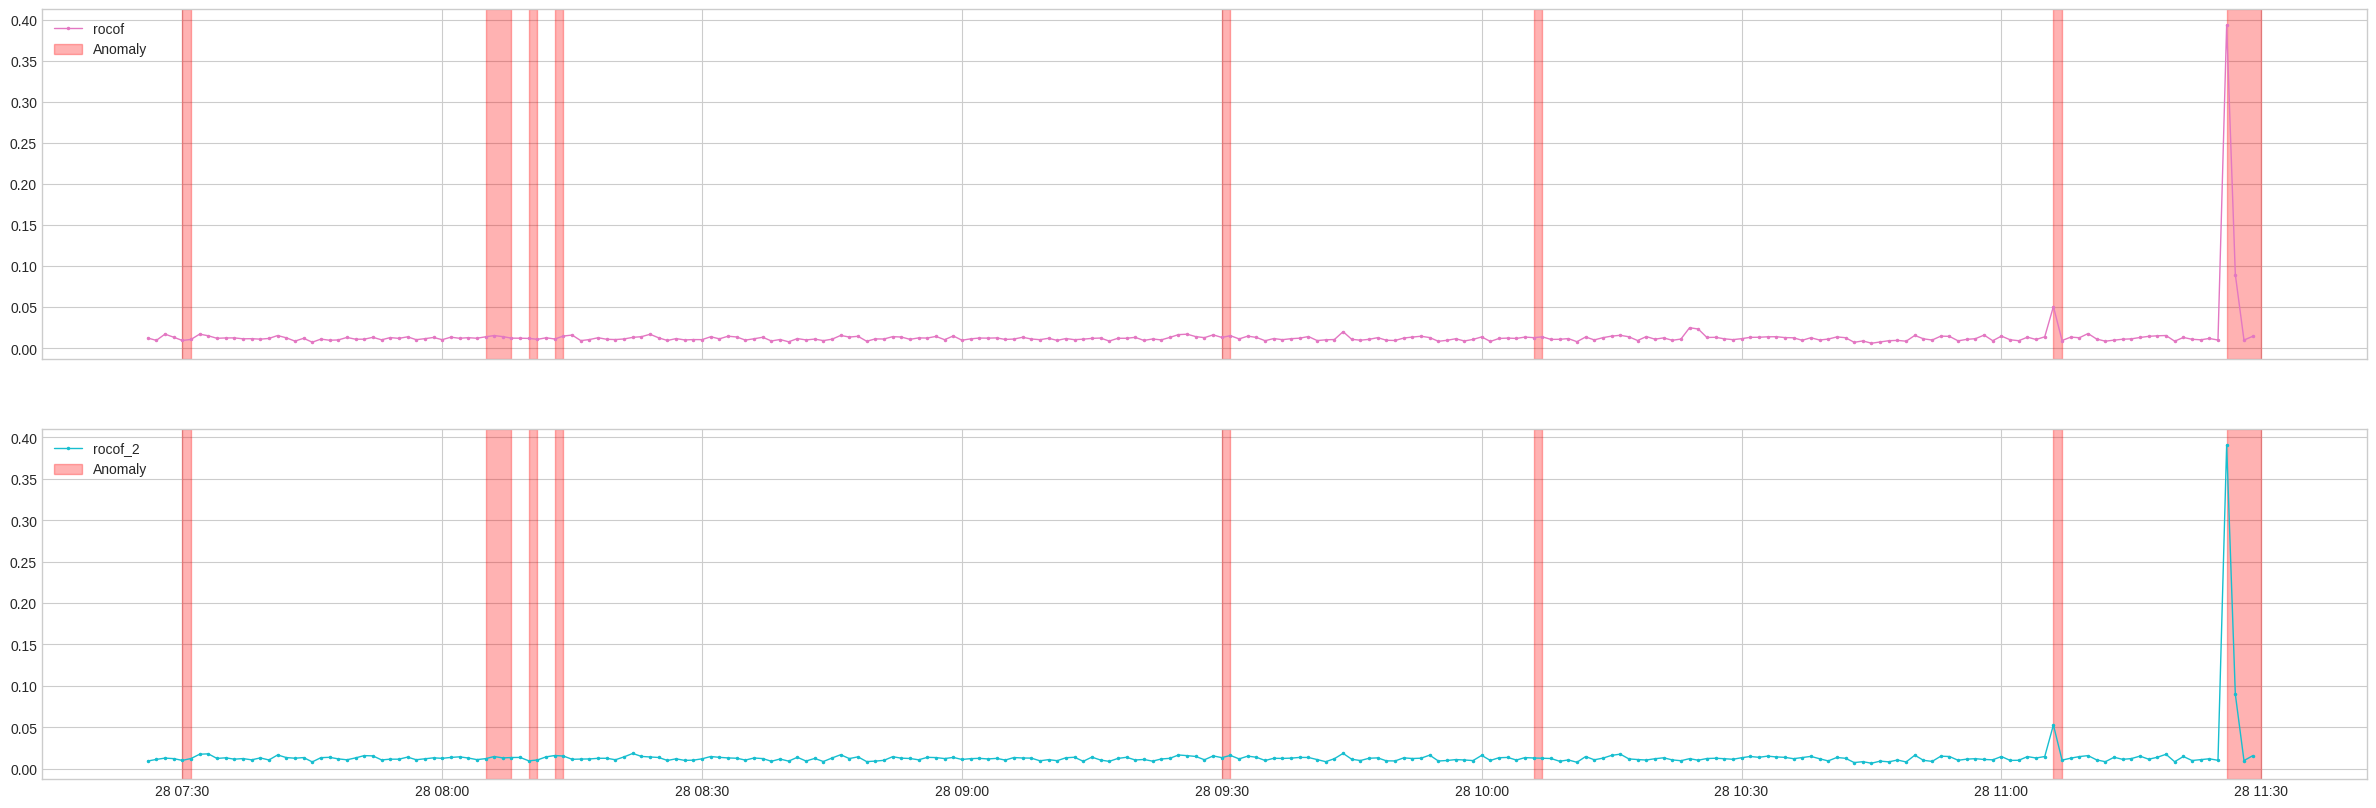

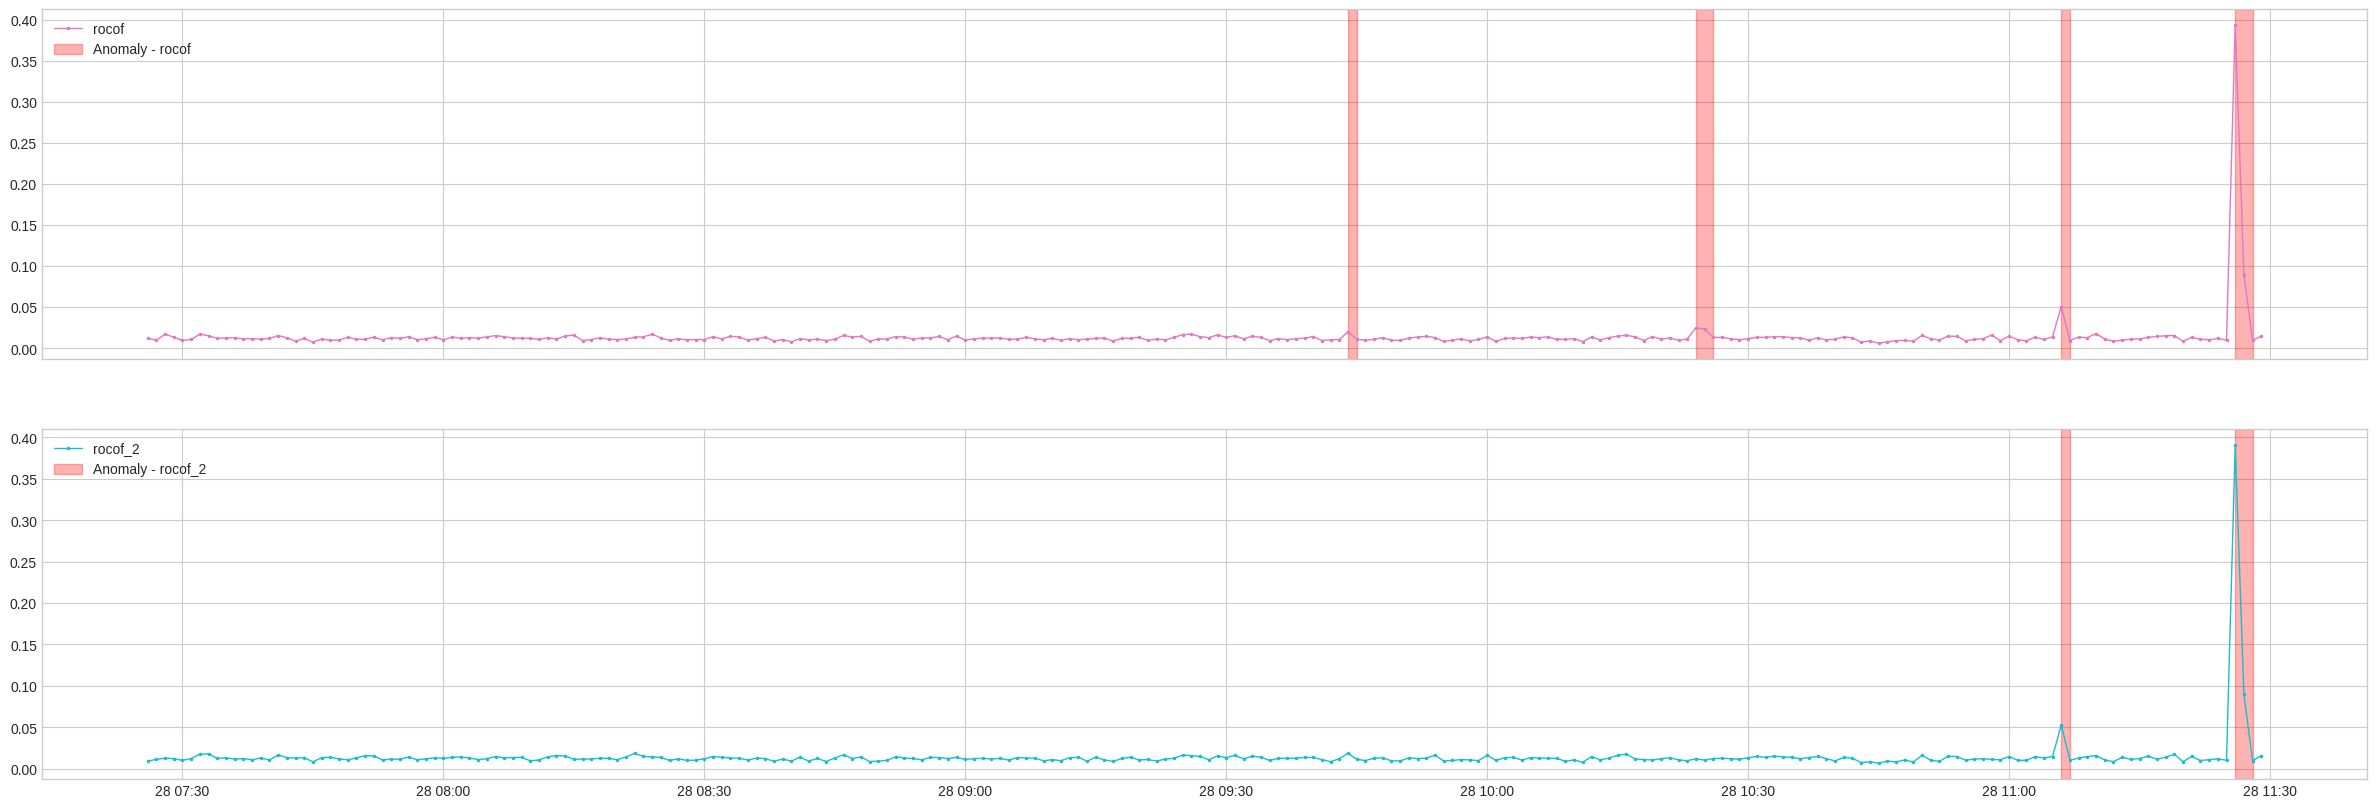

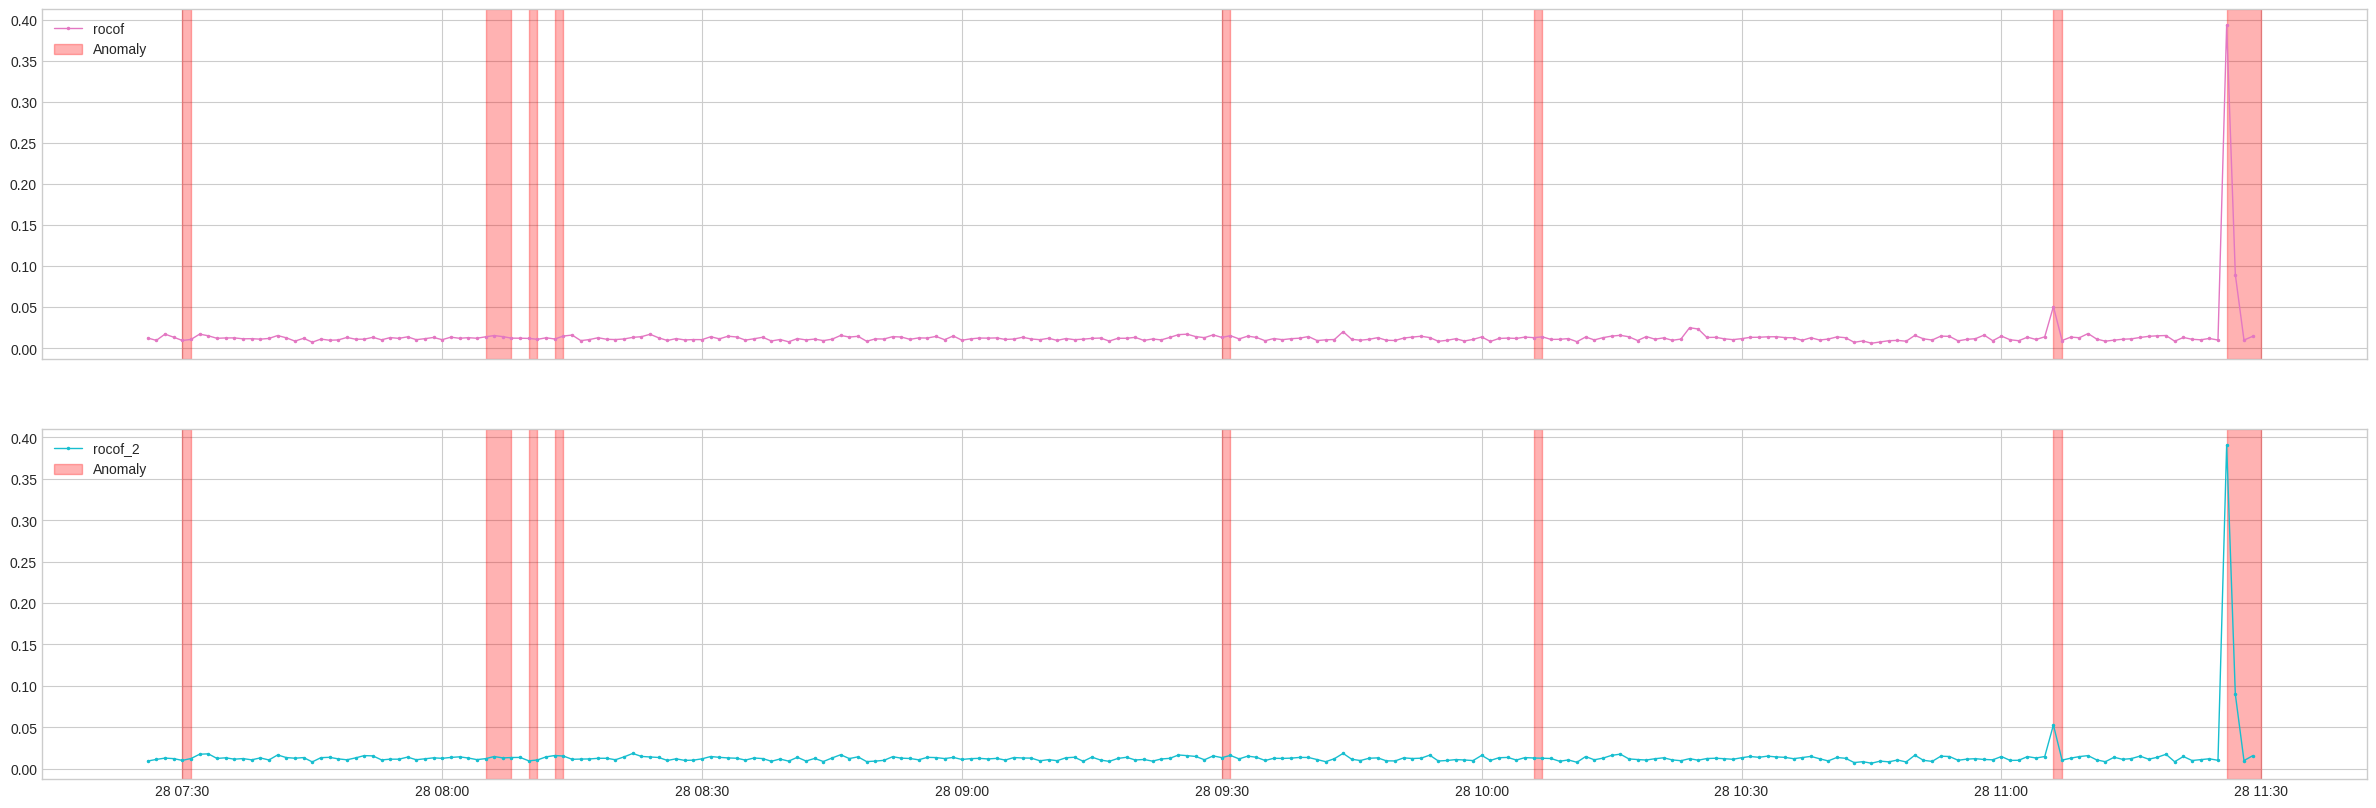

<Figure size 3000x1000 with 0 Axes>

In [ ]:
from adtk.detector import SeasonalAD
from adtk.detector import QuantileAD
from adtk.detector import OutlierDetector
from adtk.detector import GeneralizedESDTestAD
from adtk.detector import MinClusterDetector
from adtk.detector import PcaAD
from adtk.data import validate_series
from adtk.visualization import plot
from sklearn.ensemble import IsolationForest

import warnings
import matplotlib.pyplot as plt

contaminantes = 0.05

detectores = [
    SeasonalAD(freq=24),
    QuantileAD(high=0.99, low=0.01),
    OutlierDetector(IsolationForest(contamination=contaminantes, random_state=42)),
    GeneralizedESDTestAD(),
    MinClusterDetector(IsolationForest(contamination=contaminantes, random_state=42)),
    PcaAD()
]

anomalias = pd.DataFrame()
serie_tot = pd.DataFrame()

for evento in eventos:
  df = medidas(parquets, evento)
  series = validate_series(df)
  #if serie_tot.empty:
  #  serie_tot = series
  #else:
  #  serie_tot = pd.concat([serie_tot, series], axis=0)

  for det in detectores:
    nomeDetector = det.__class__.__name__
    y_anom = det.fit_detect(series)
    anomalias = y_anom
    #if anomalias.empty:
    #  anomalias = y_anom
    #else:
    #  anomalias = pd.concat([anomalias, y_anom], axis=0)

    #verificando se existe a coluna no dataframe. Caso existir, popular a variavel curveColumns
    curveColumns = []
    if 'rocof' in series.columns:
      curveColumns.append('rocof')
    if 'rocof_2' in series.columns:
      curveColumns.append('rocof_2')

    warnings.filterwarnings('ignore')
    print('Nome detector:', nomeDetector, '\nEvento:', evento)
    plot(series, anomaly=anomalias, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group=curveColumns, figsize=(30,10))
    print('=================================================')

ADTK com métricas

Nome detector: SeasonalAD 
Evento: 2021-04-08 18:34:00
Erro de tamanho inconsistente para o detector SeasonalAD no evento 2021-04-08 18:34:00
Nome detector: QuantileAD 
Evento: 2021-04-08 18:34:00
Erro de tamanho inconsistente para o detector QuantileAD no evento 2021-04-08 18:34:00
Nome detector: OutlierDetector 
Evento: 2021-04-08 18:34:00
Nome detector: GeneralizedESDTestAD 
Evento: 2021-04-08 18:34:00
Erro de tamanho inconsistente para o detector GeneralizedESDTestAD no evento 2021-04-08 18:34:00
Nome detector: MinClusterDetector 
Evento: 2021-04-08 18:34:00
Nome detector: PcaAD 
Evento: 2021-04-08 18:34:00
Nome detector: SeasonalAD 
Evento: 2021-05-28 11:06:00
Erro de tamanho inconsistente para o detector SeasonalAD no evento 2021-05-28 11:06:00
Nome detector: QuantileAD 
Evento: 2021-05-28 11:06:00
Erro de tamanho inconsistente para o detector QuantileAD no evento 2021-05-28 11:06:00
Nome detector: OutlierDetector 
Evento: 2021-05-28 11:06:00
Nome detector: GeneralizedESDTestAD 


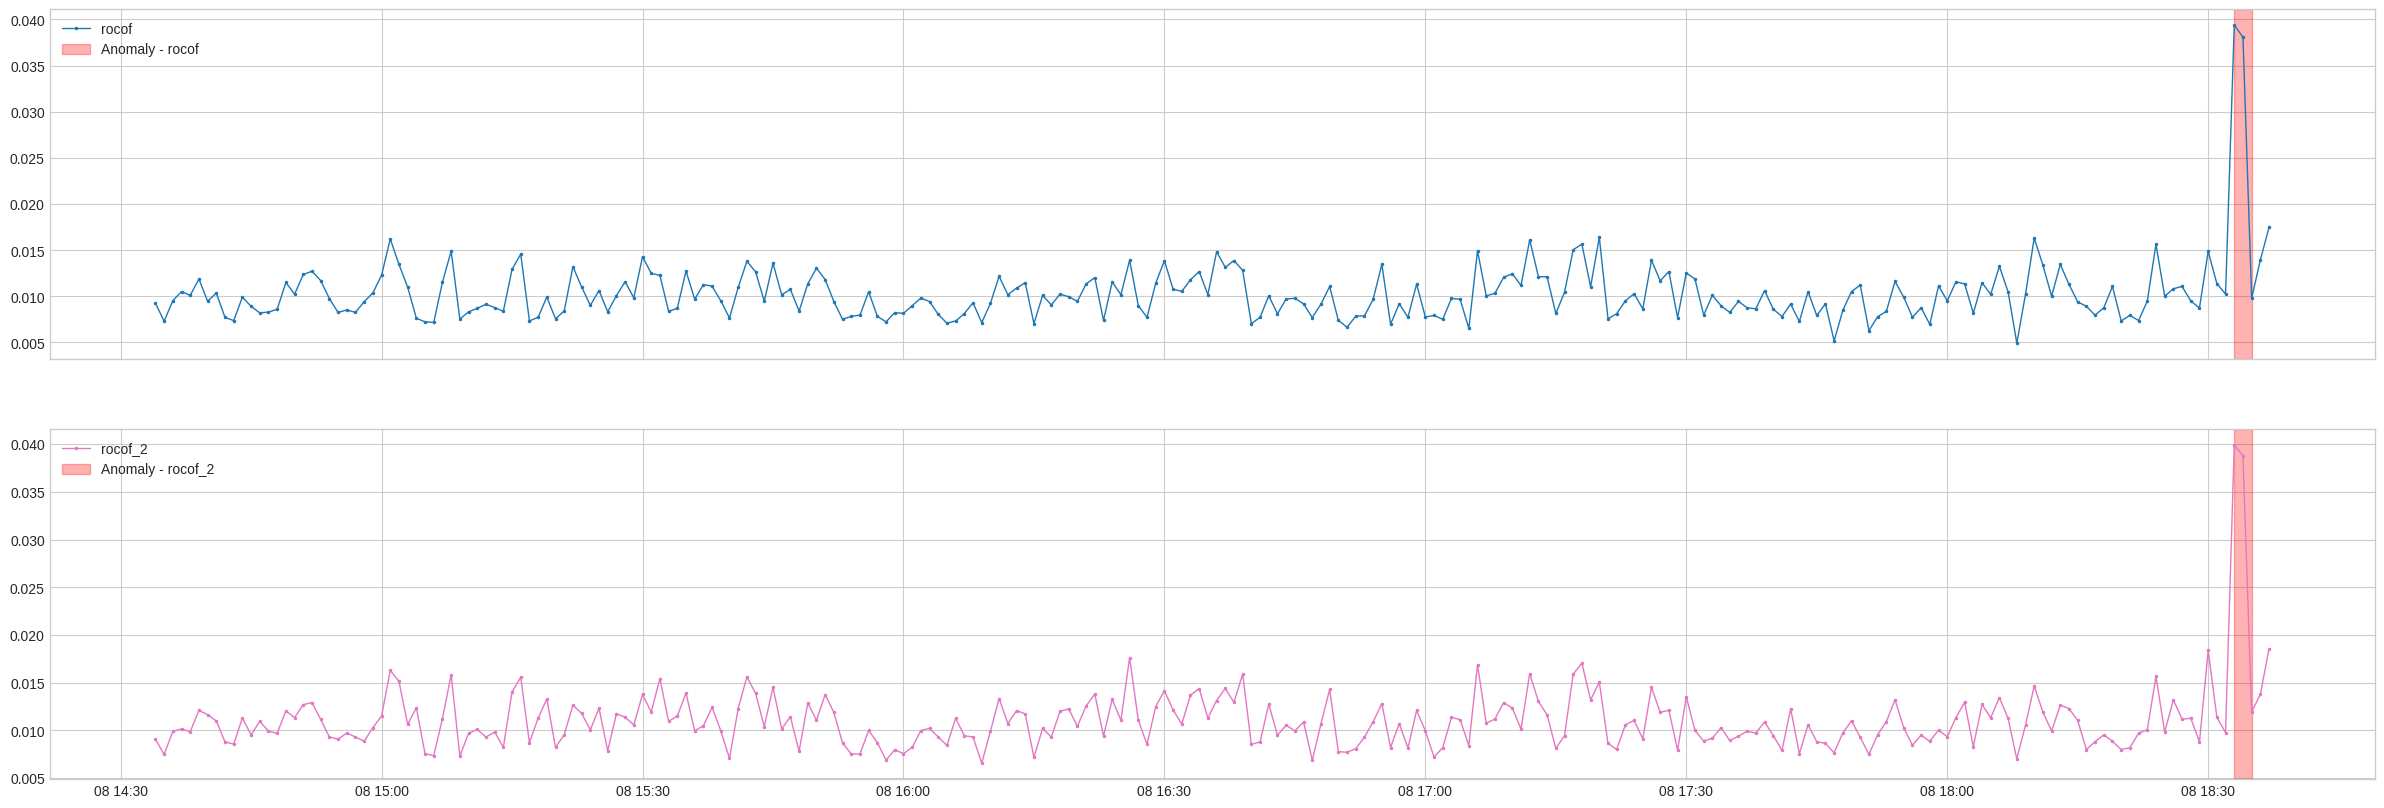

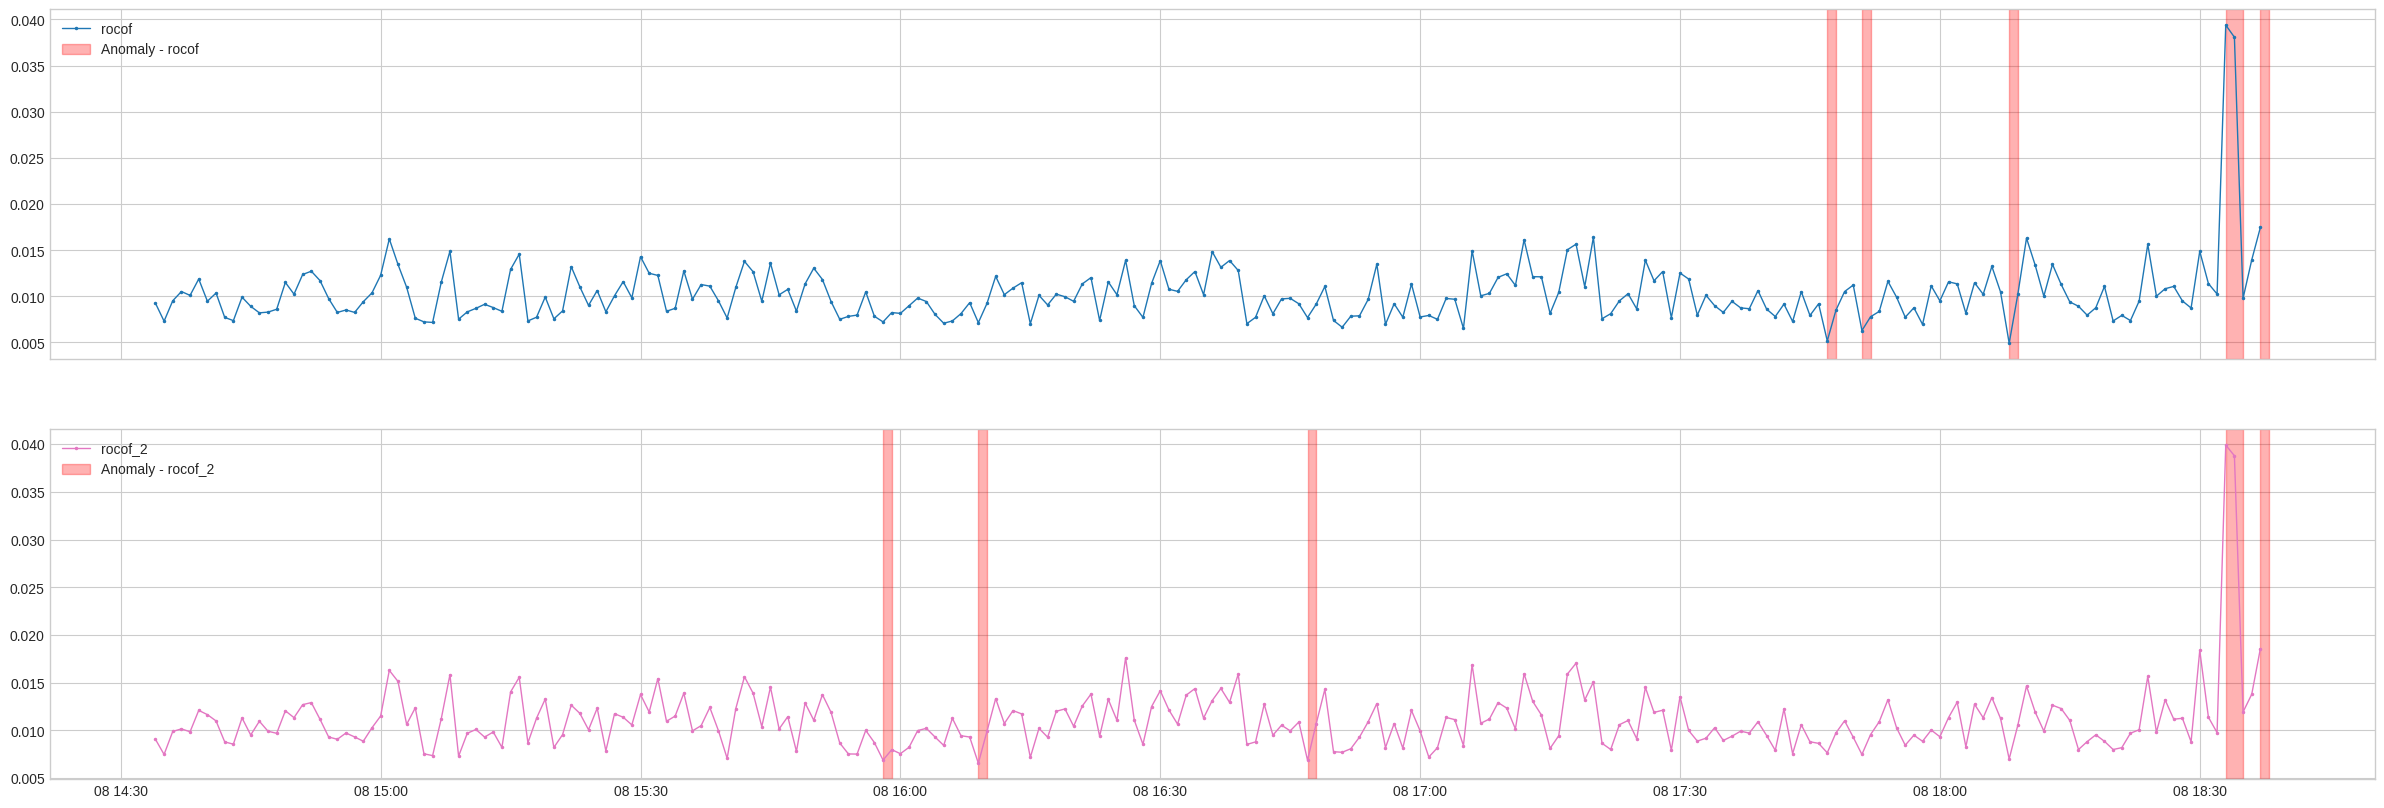

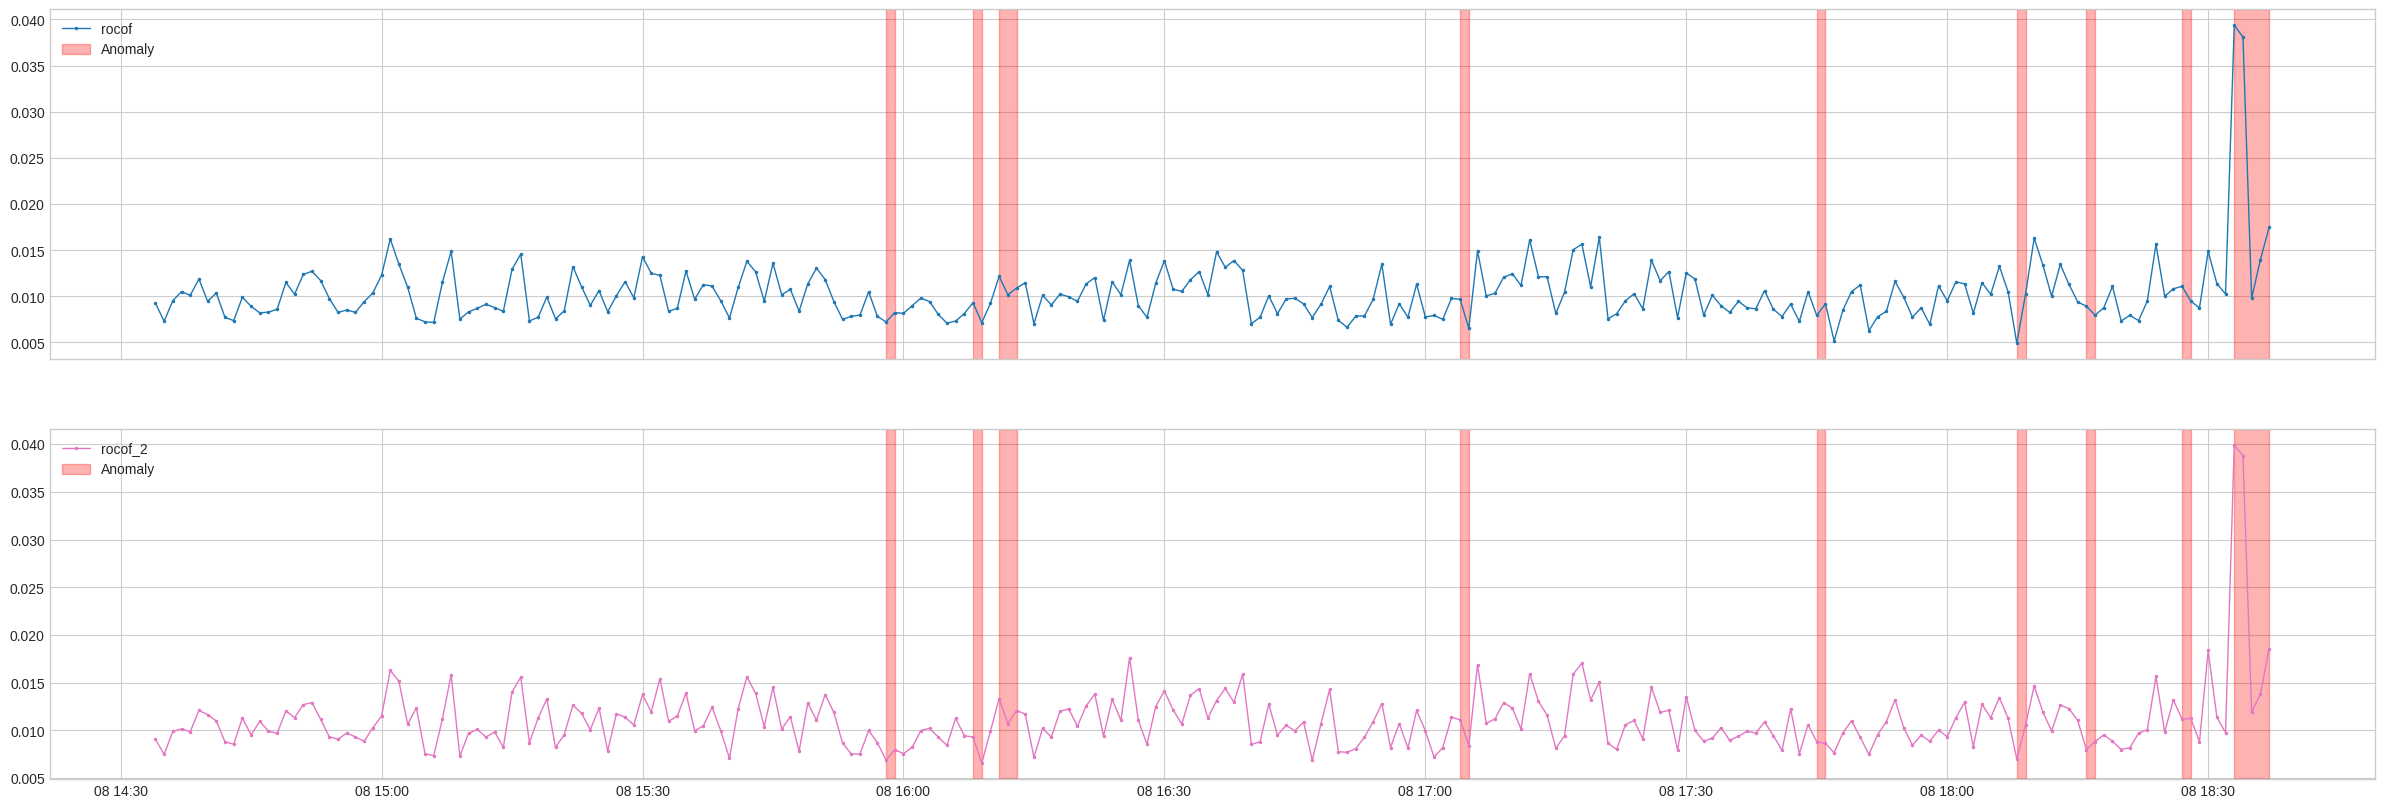

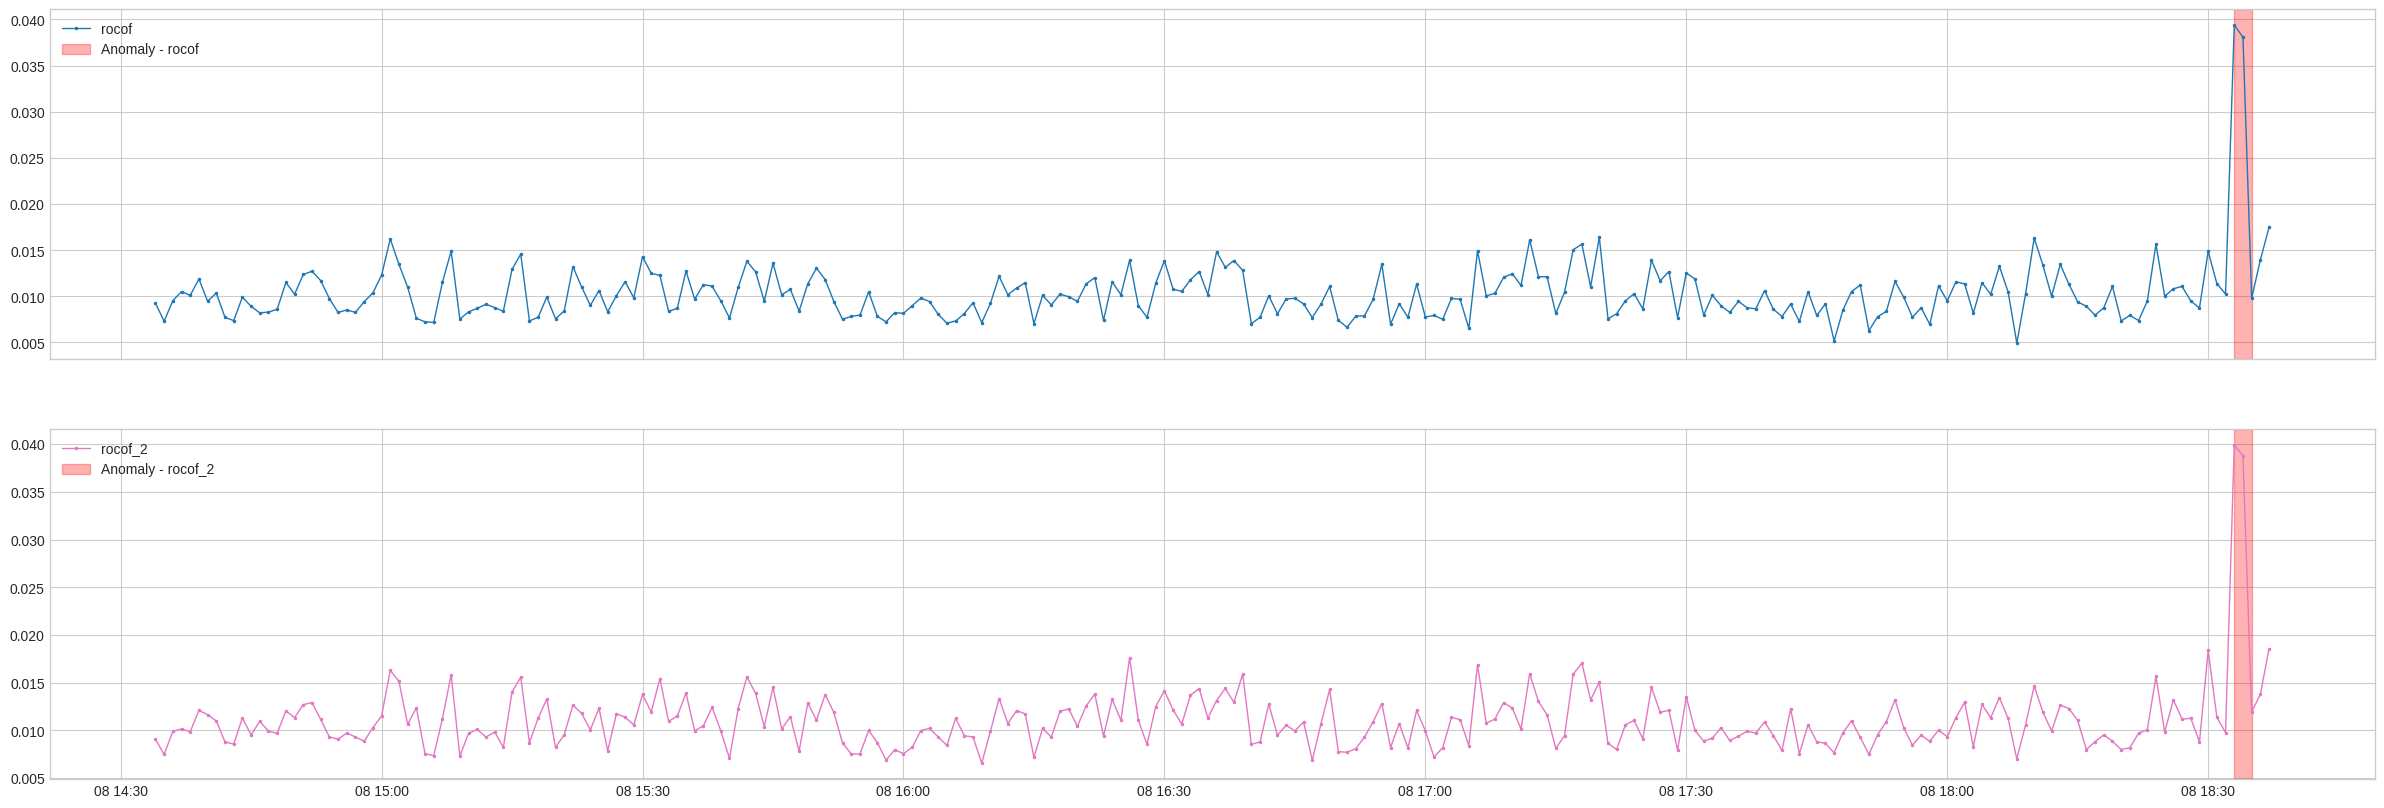

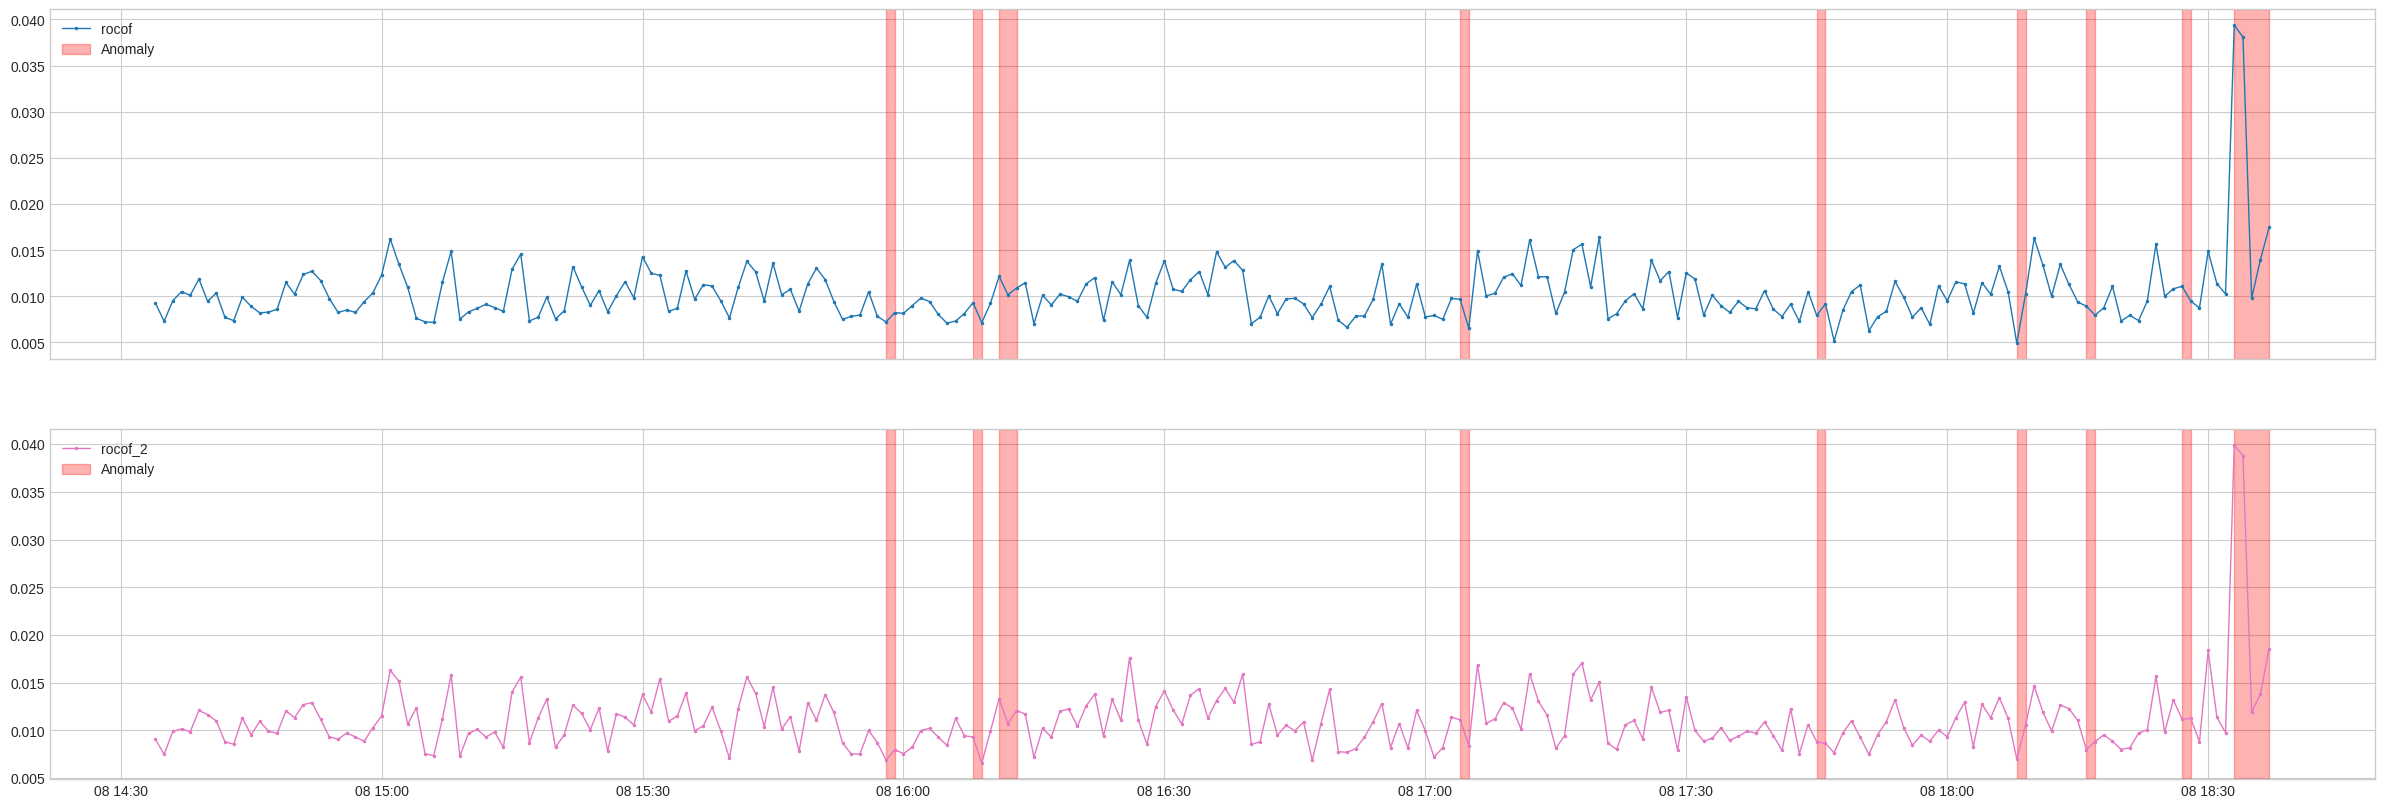

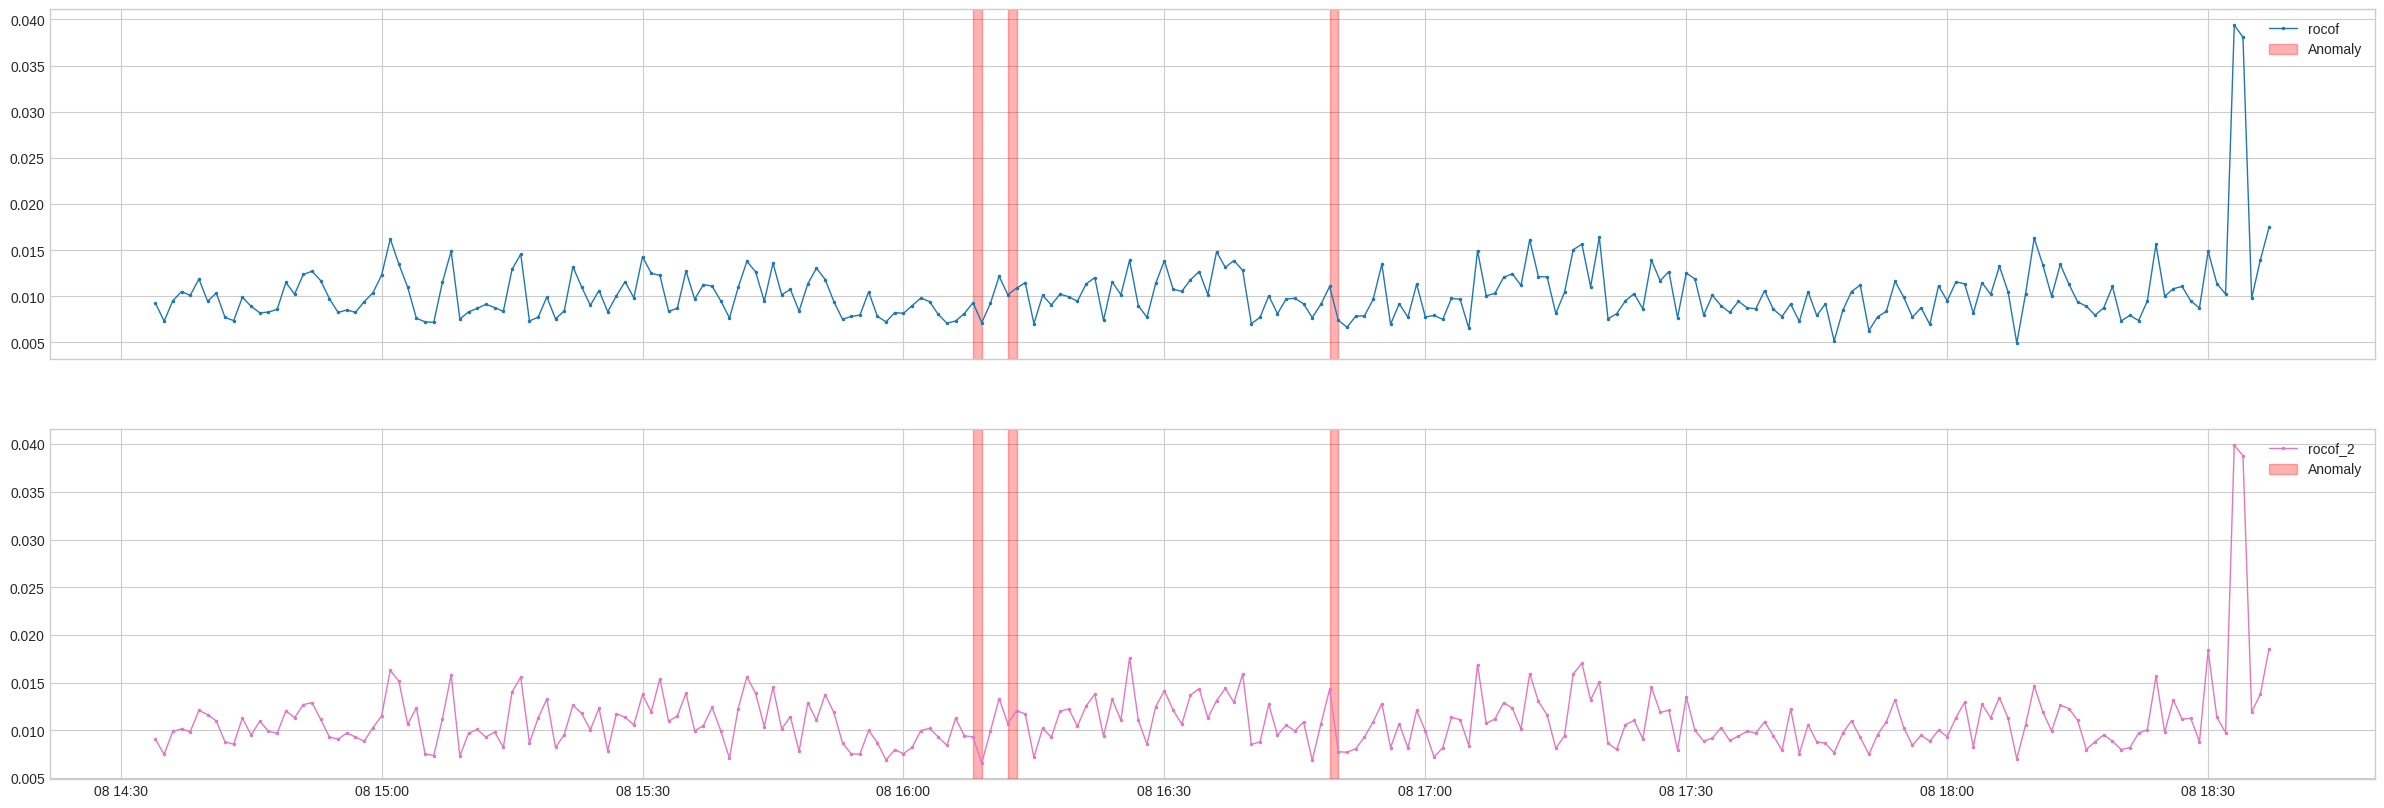

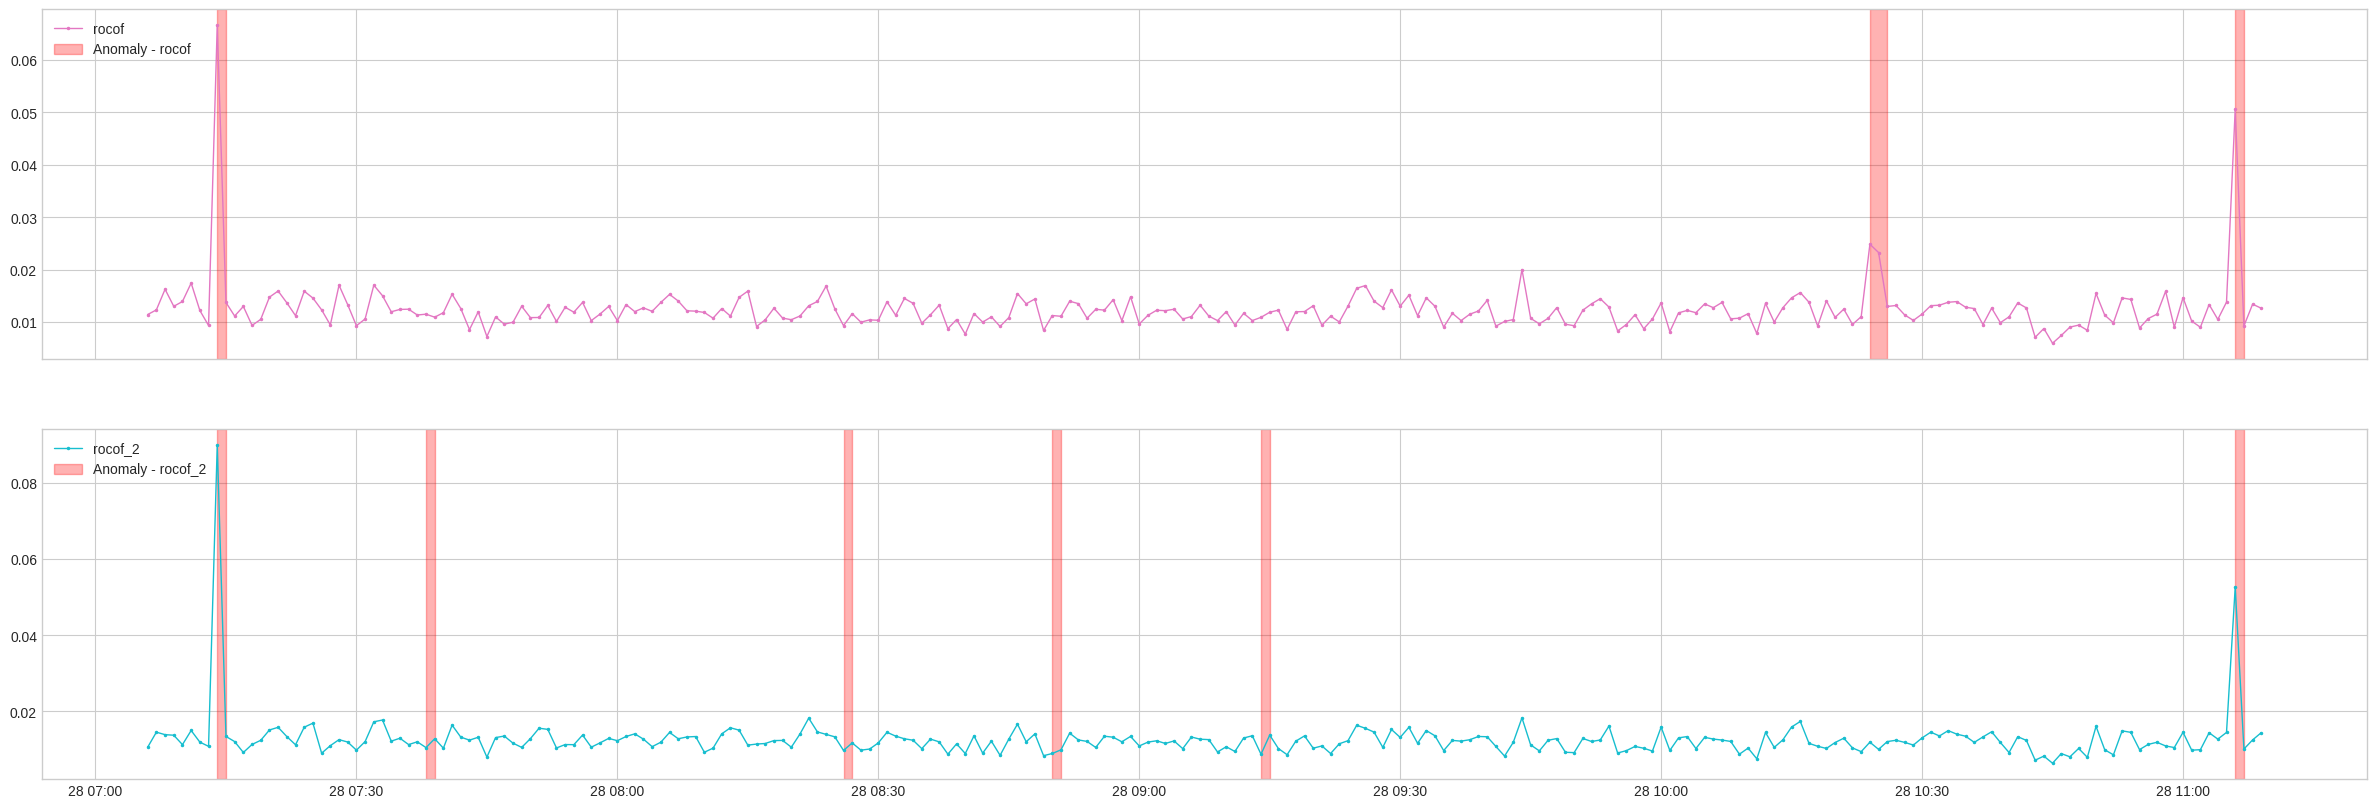

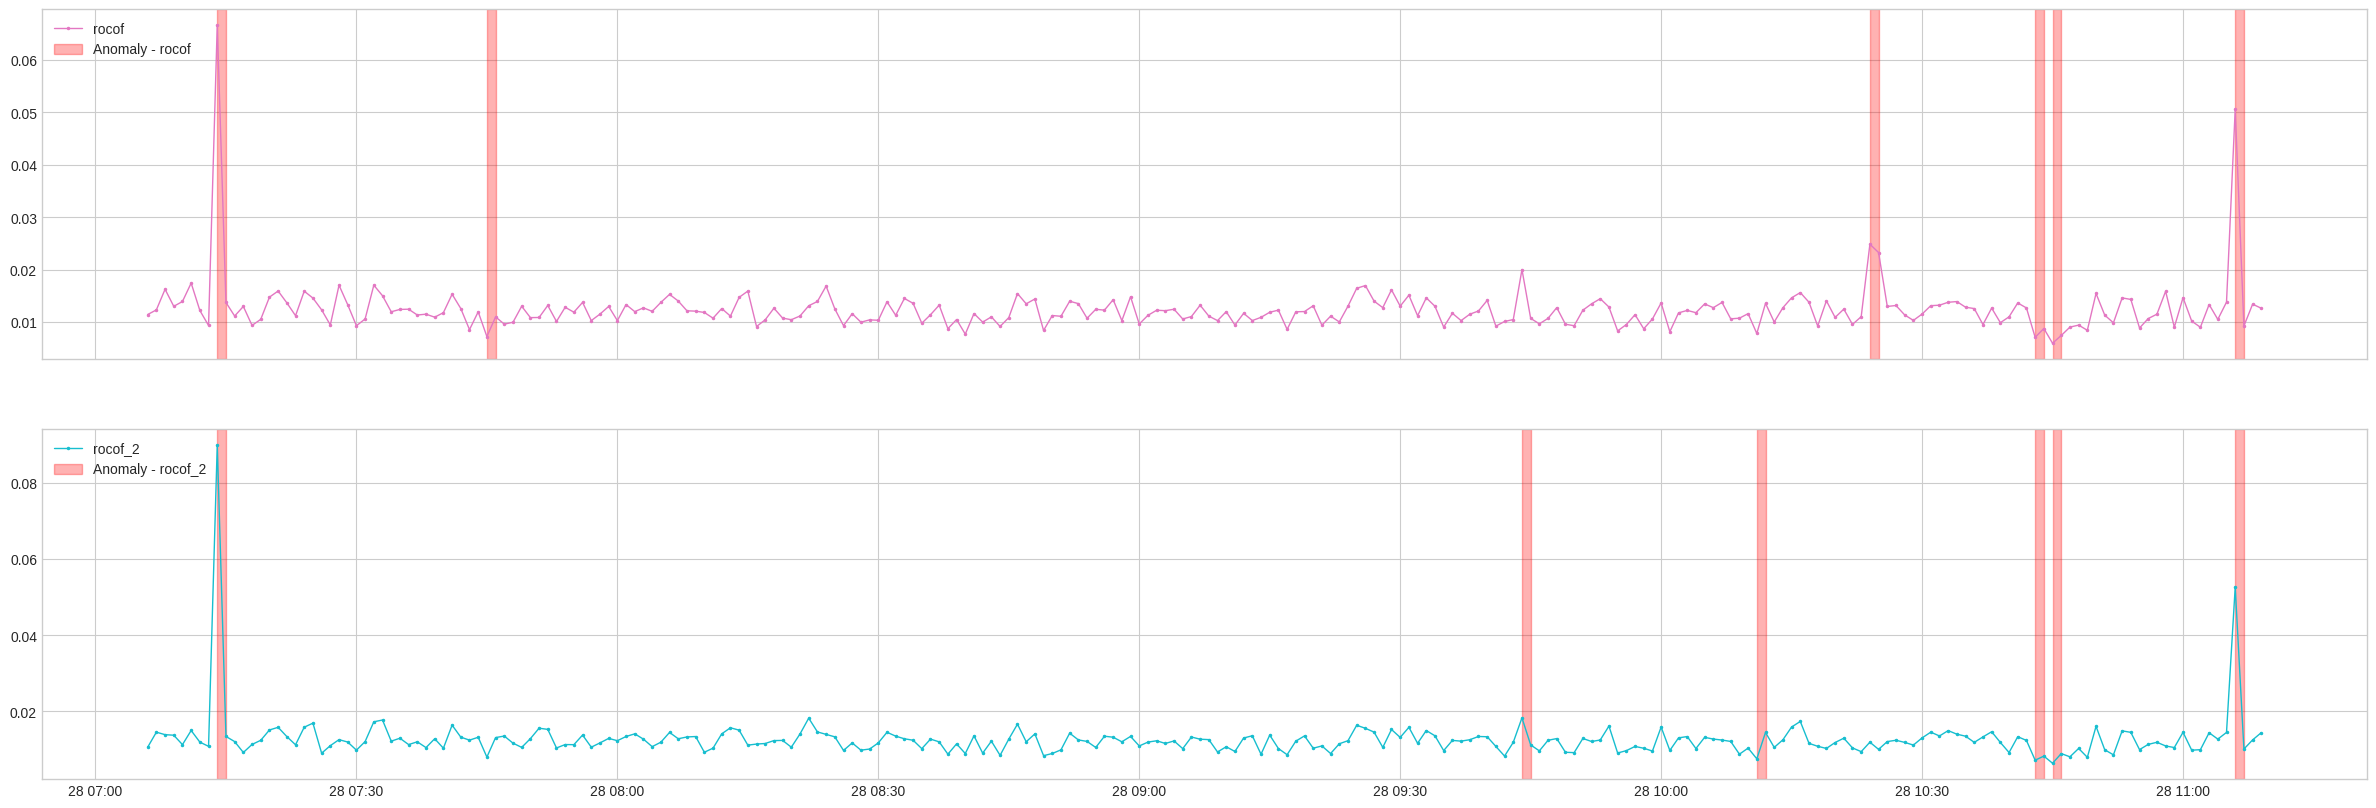

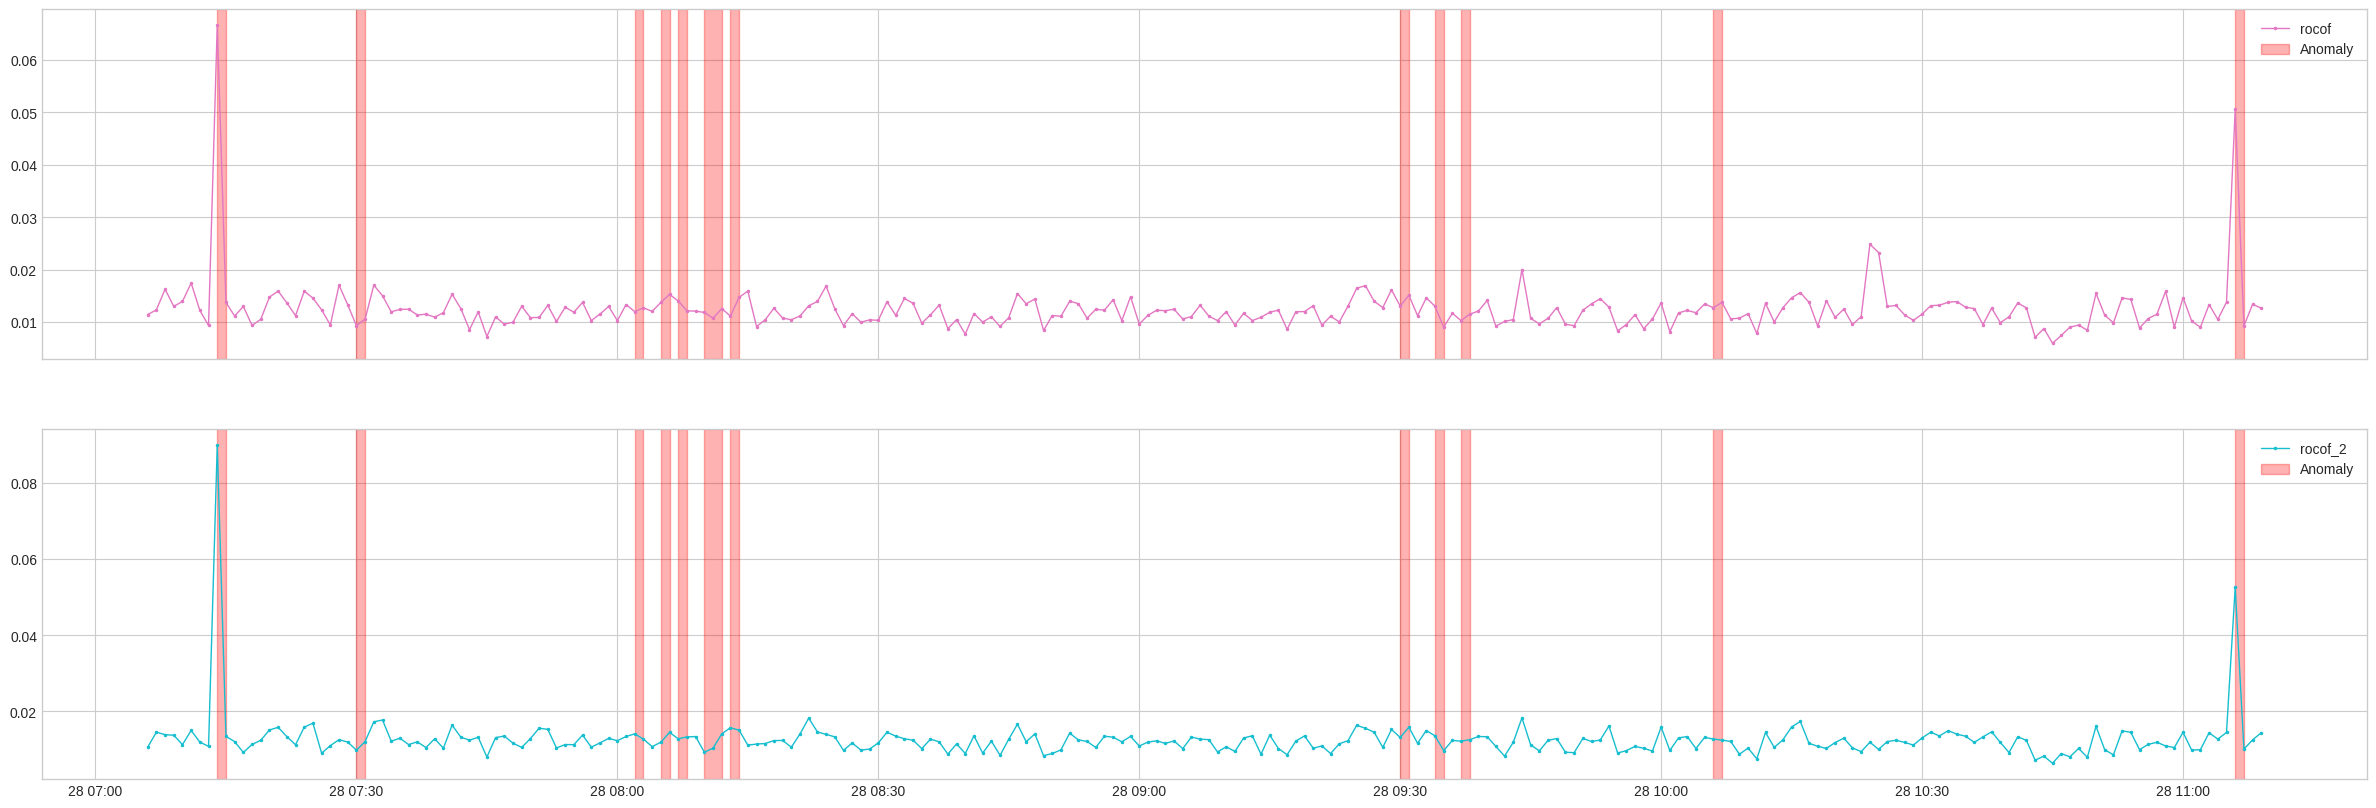

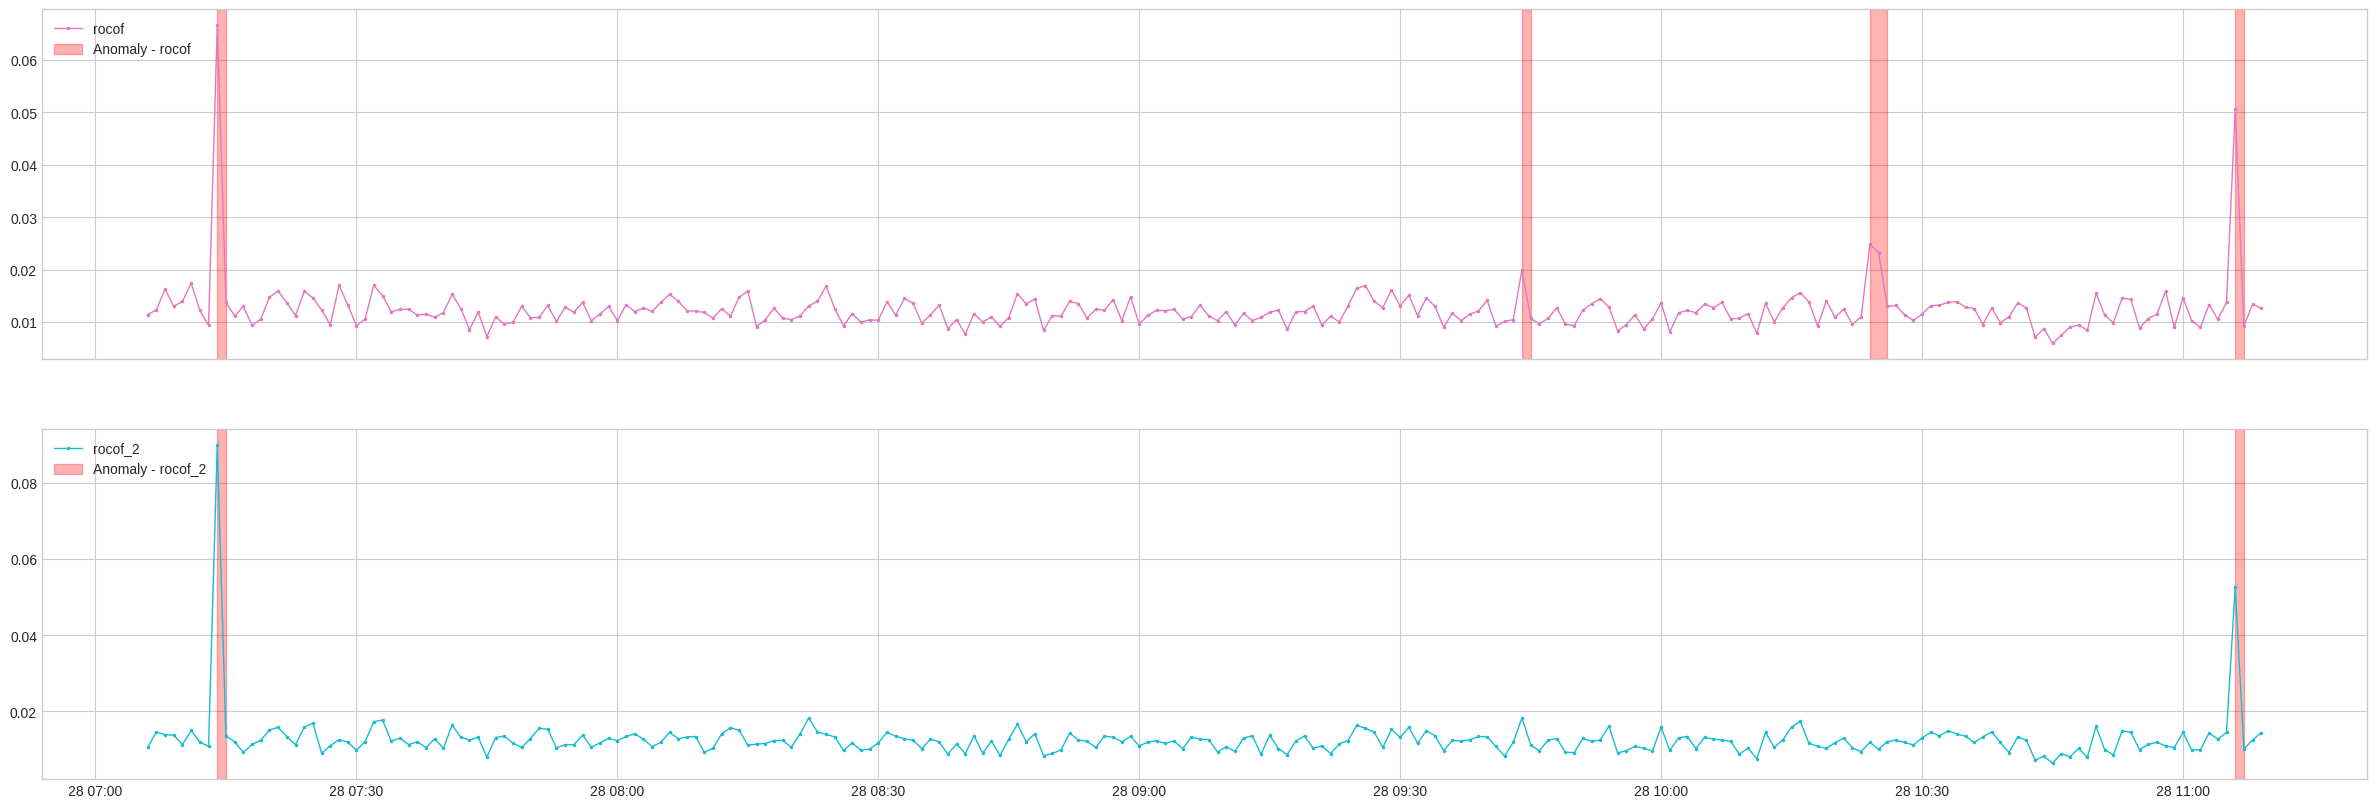

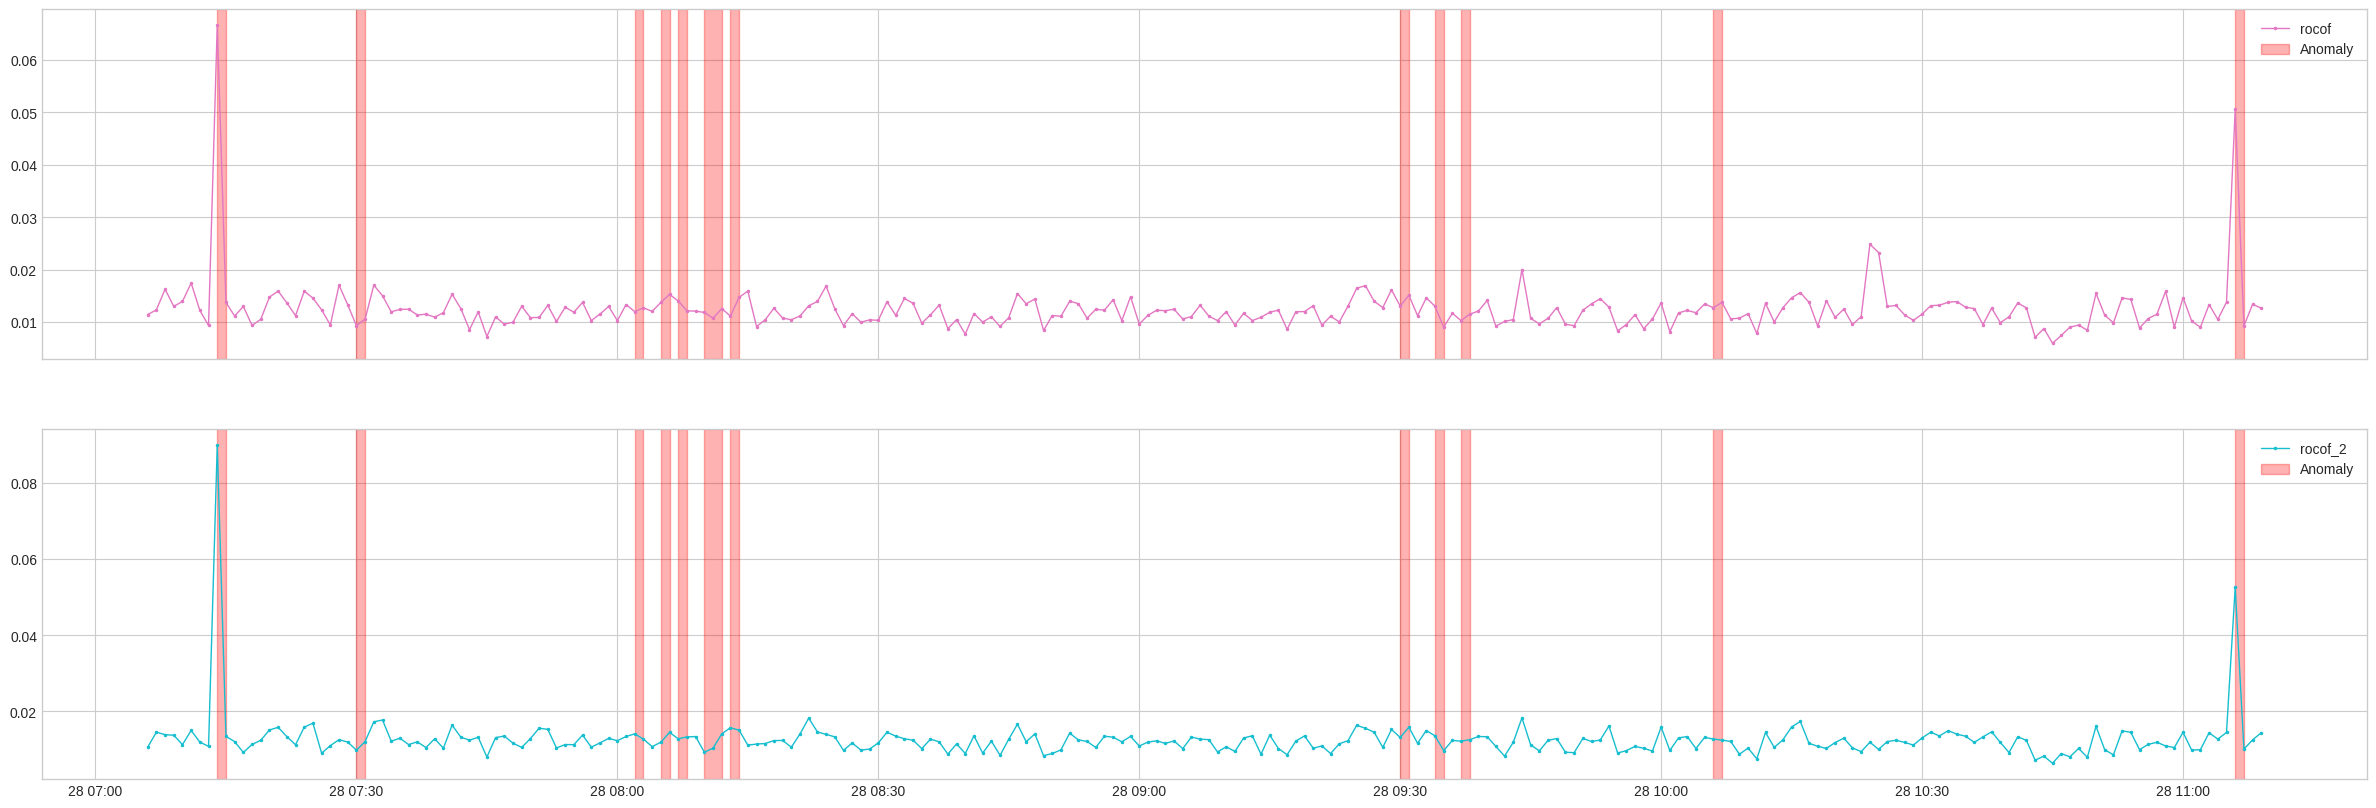

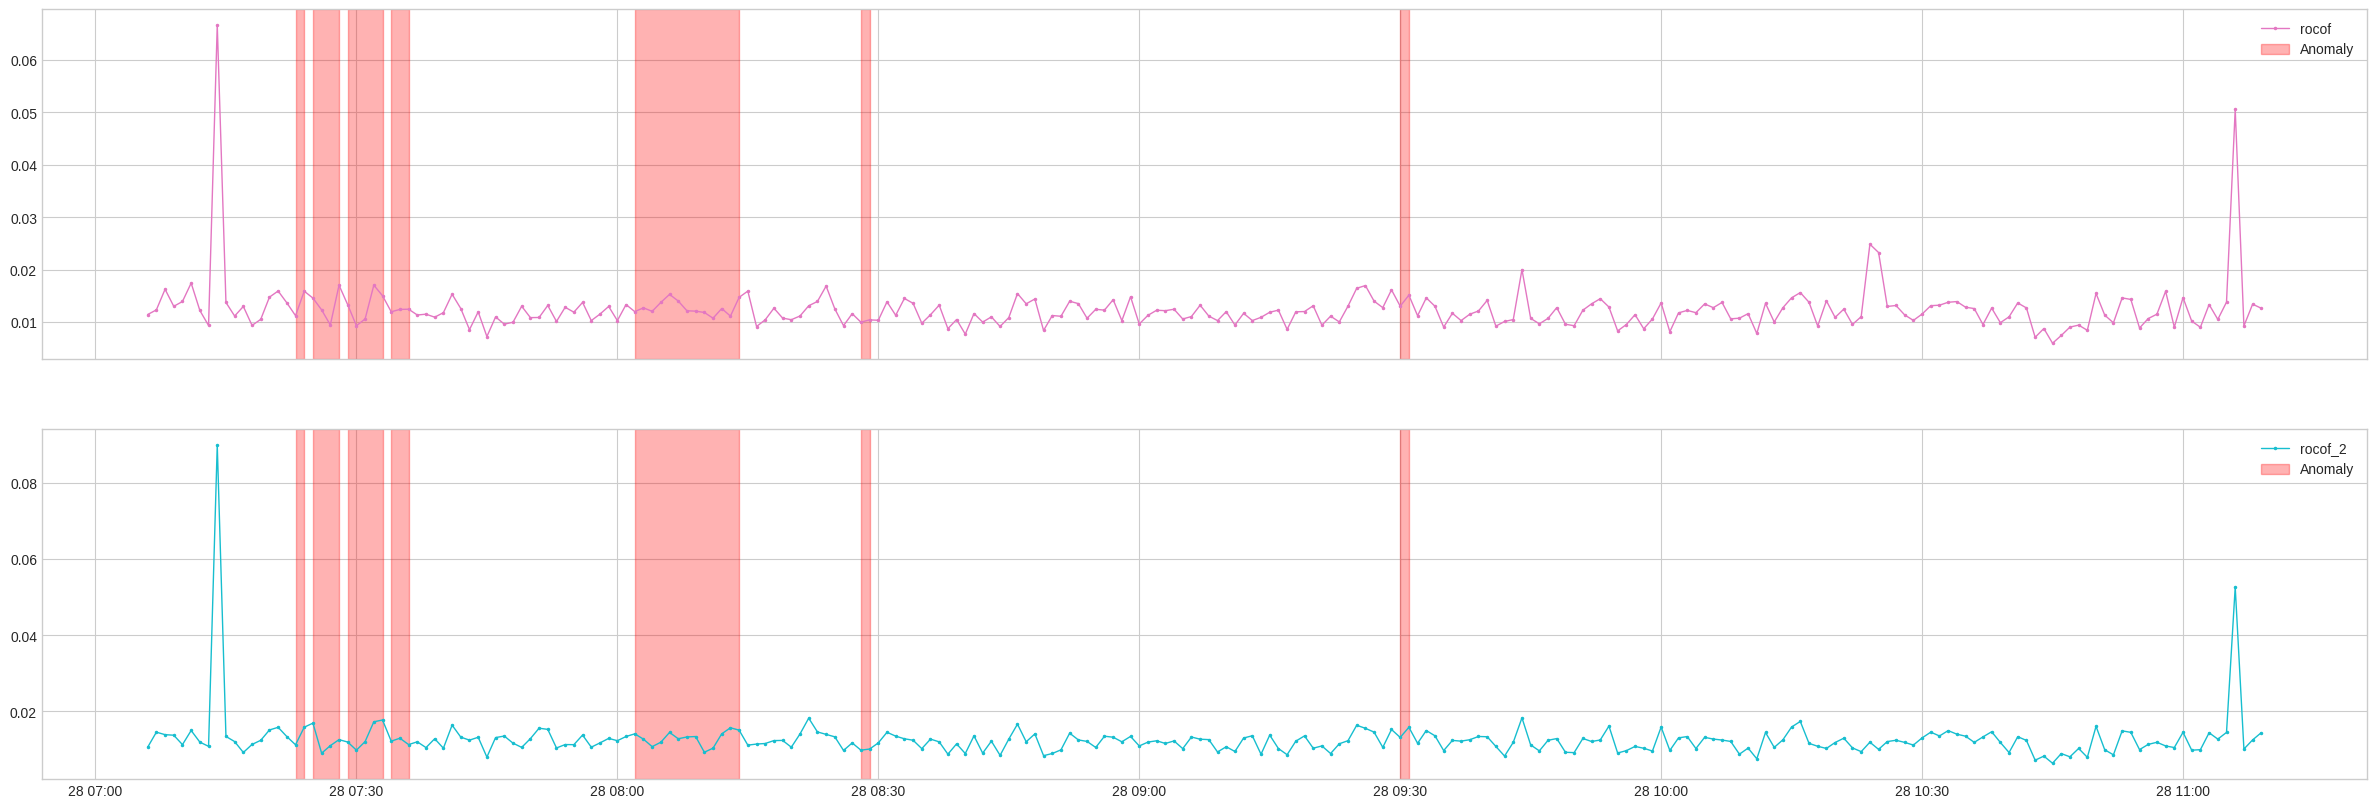

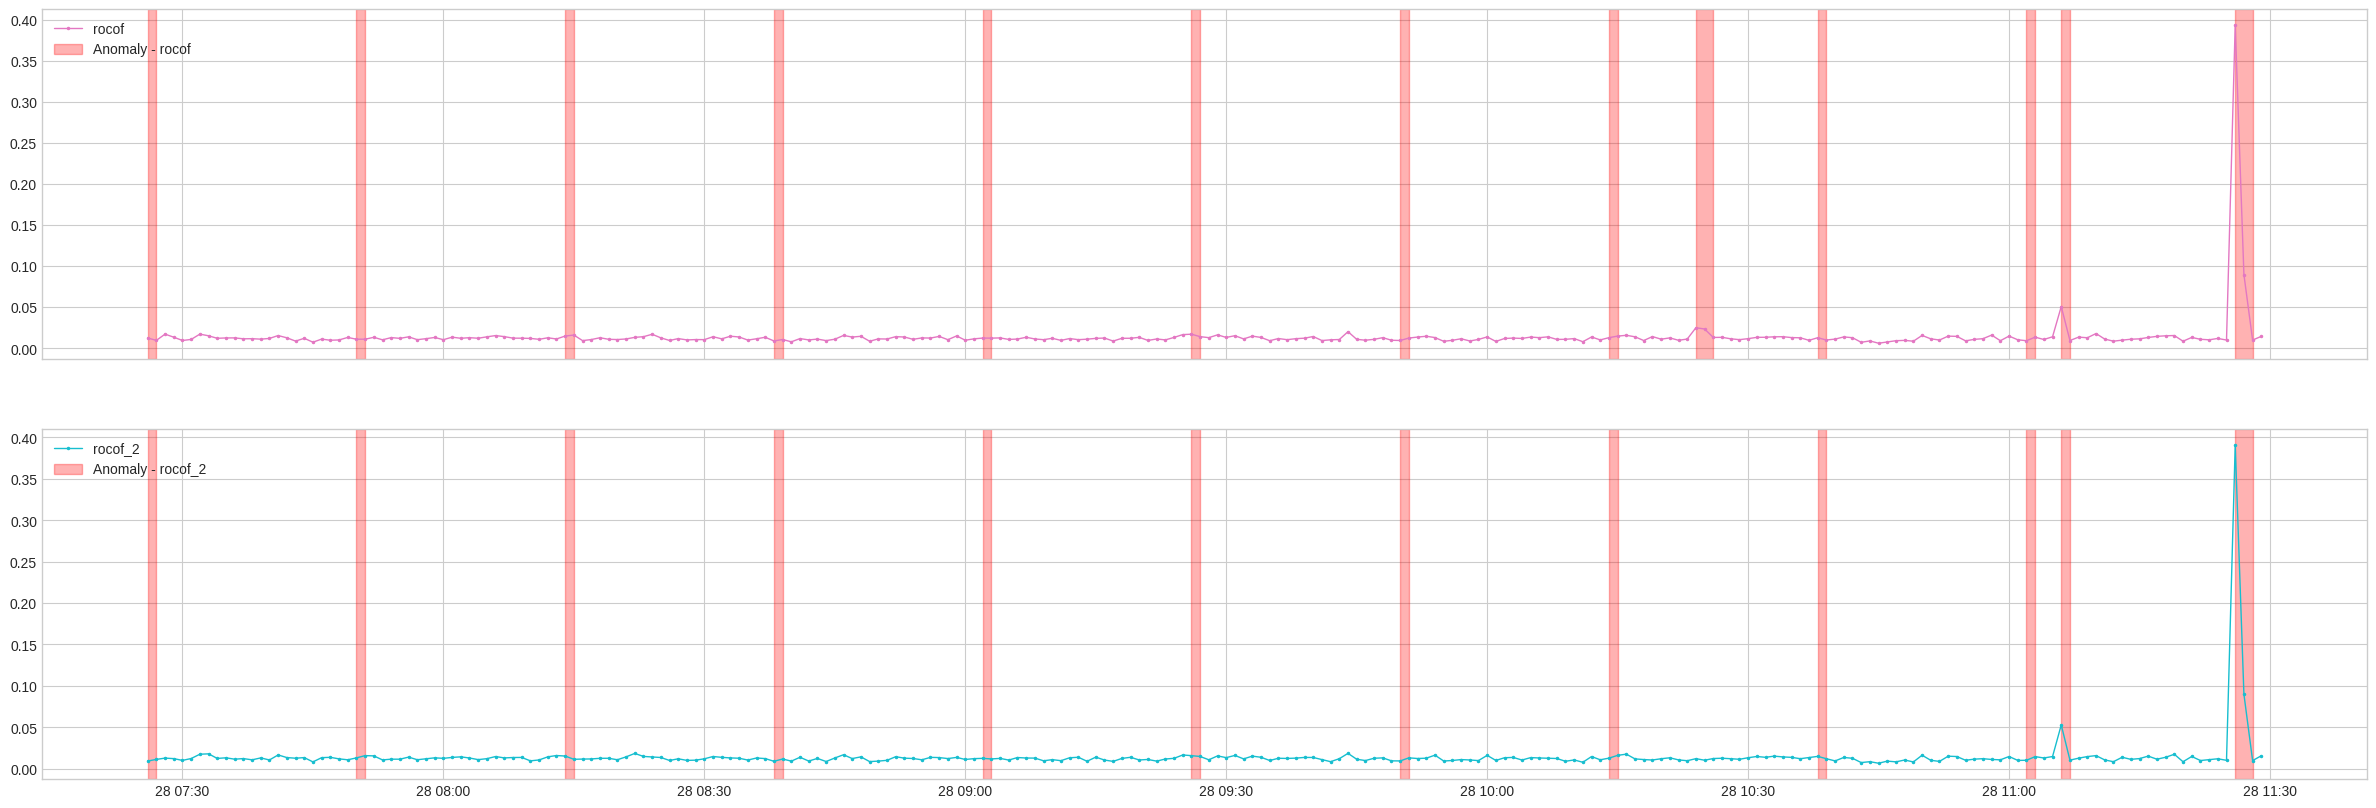

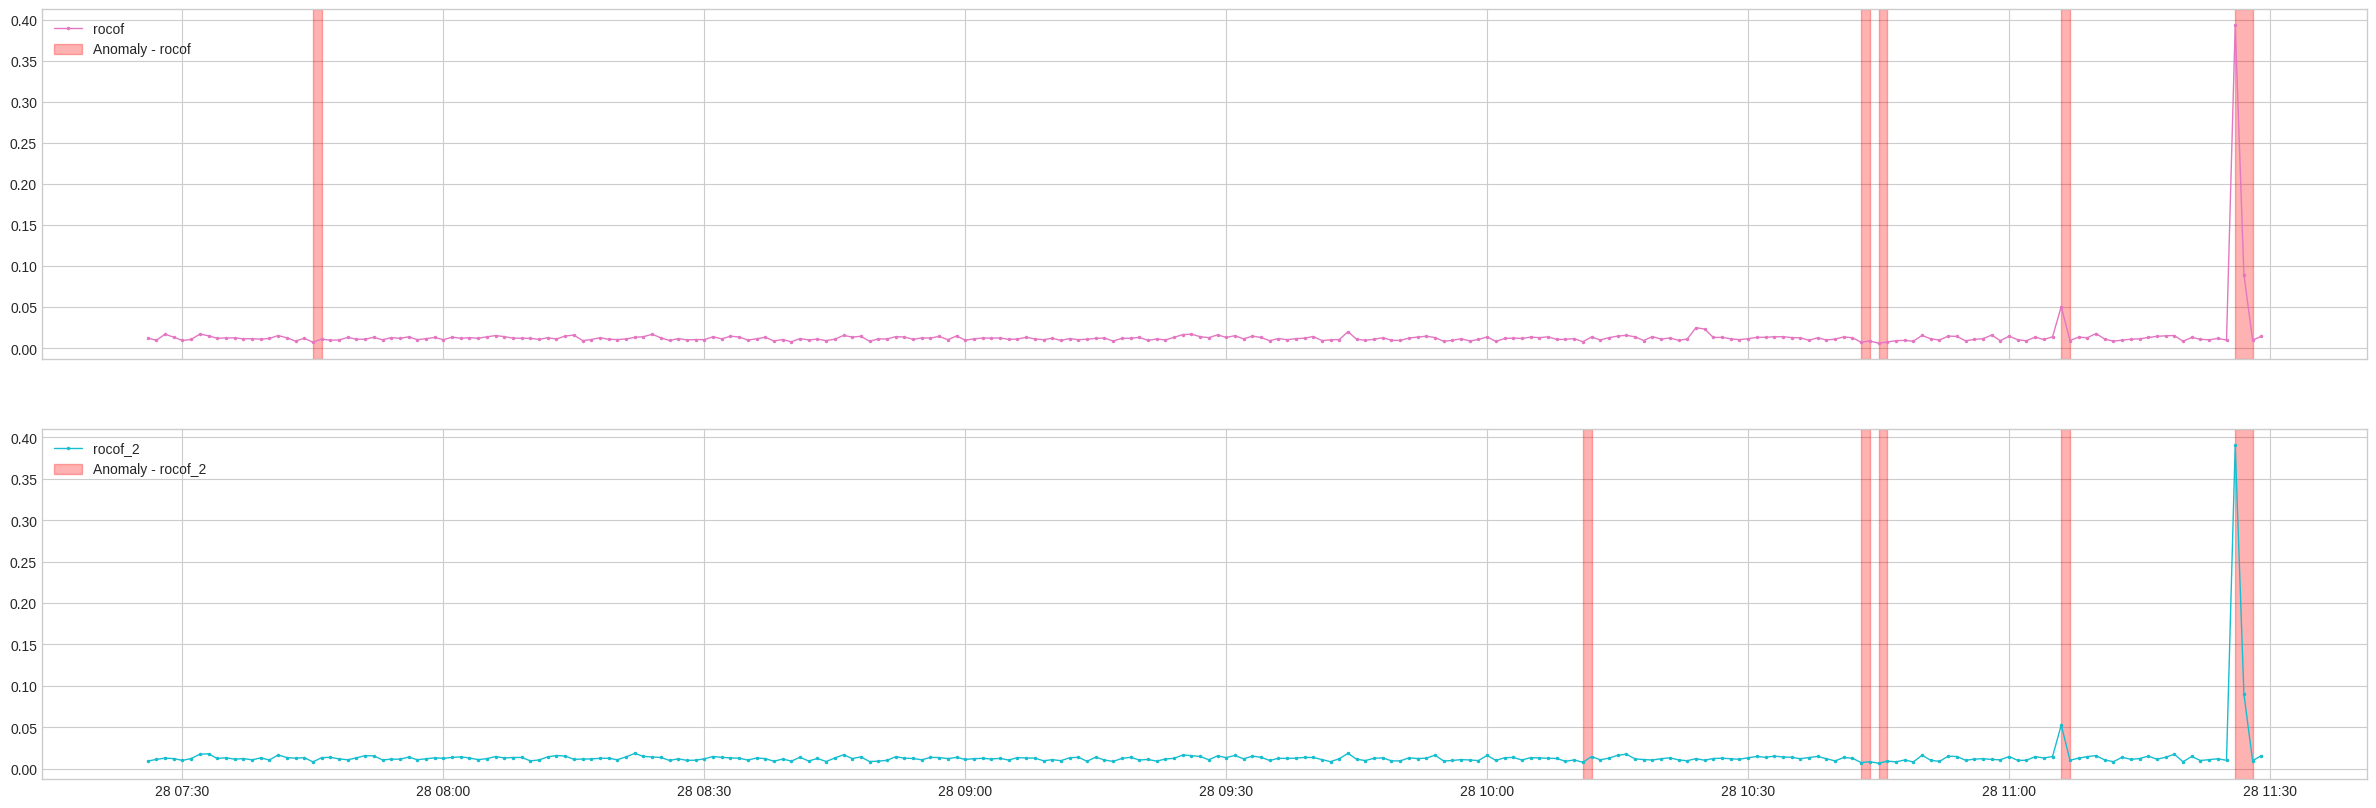

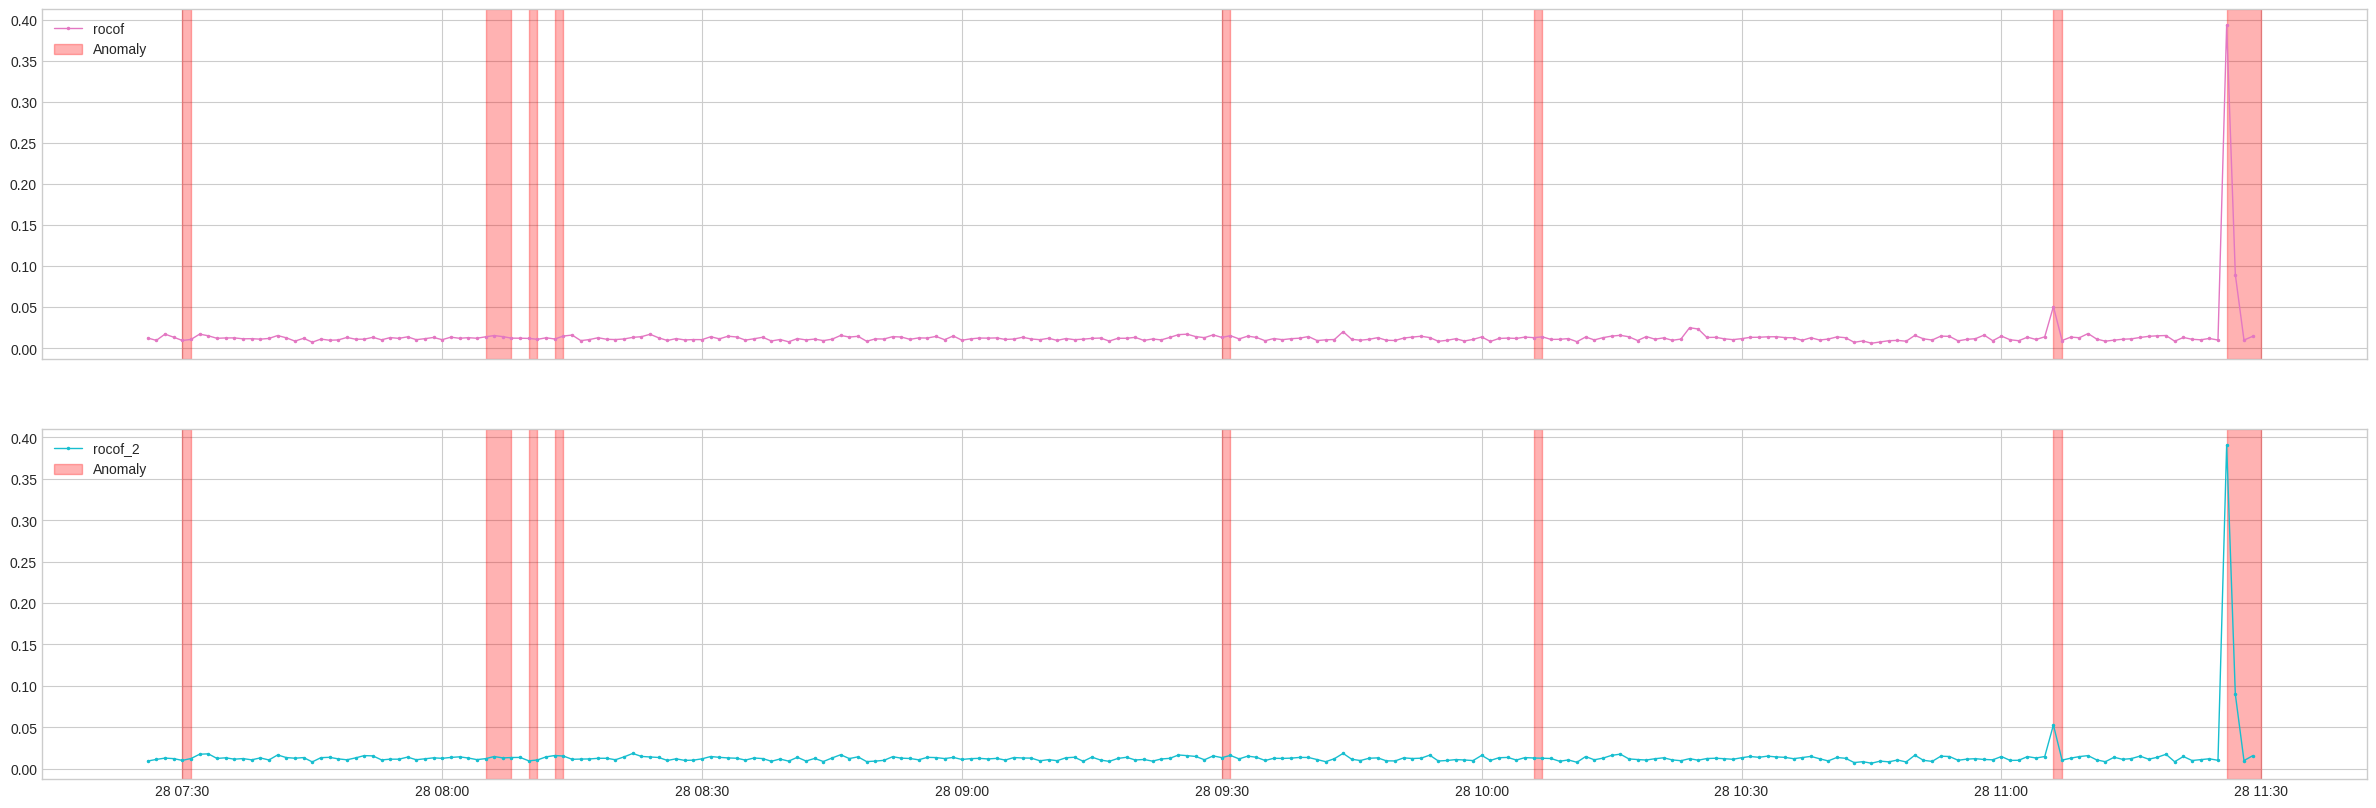

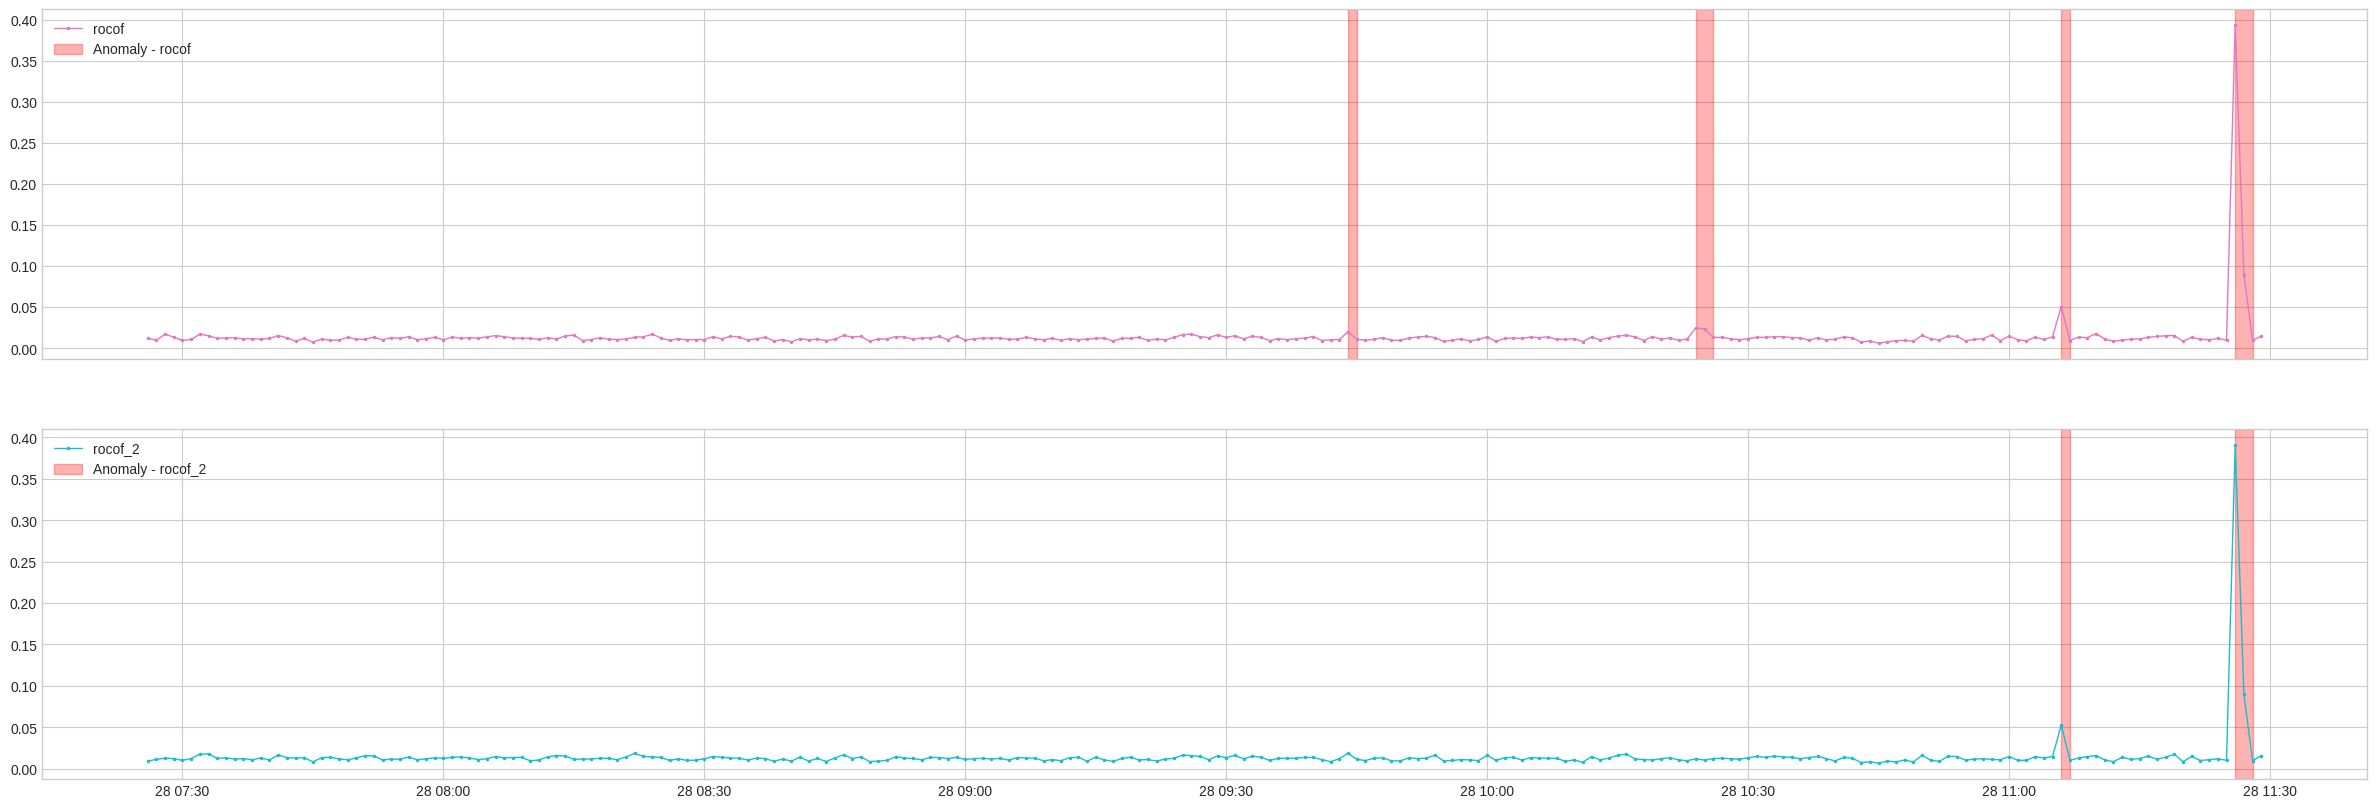

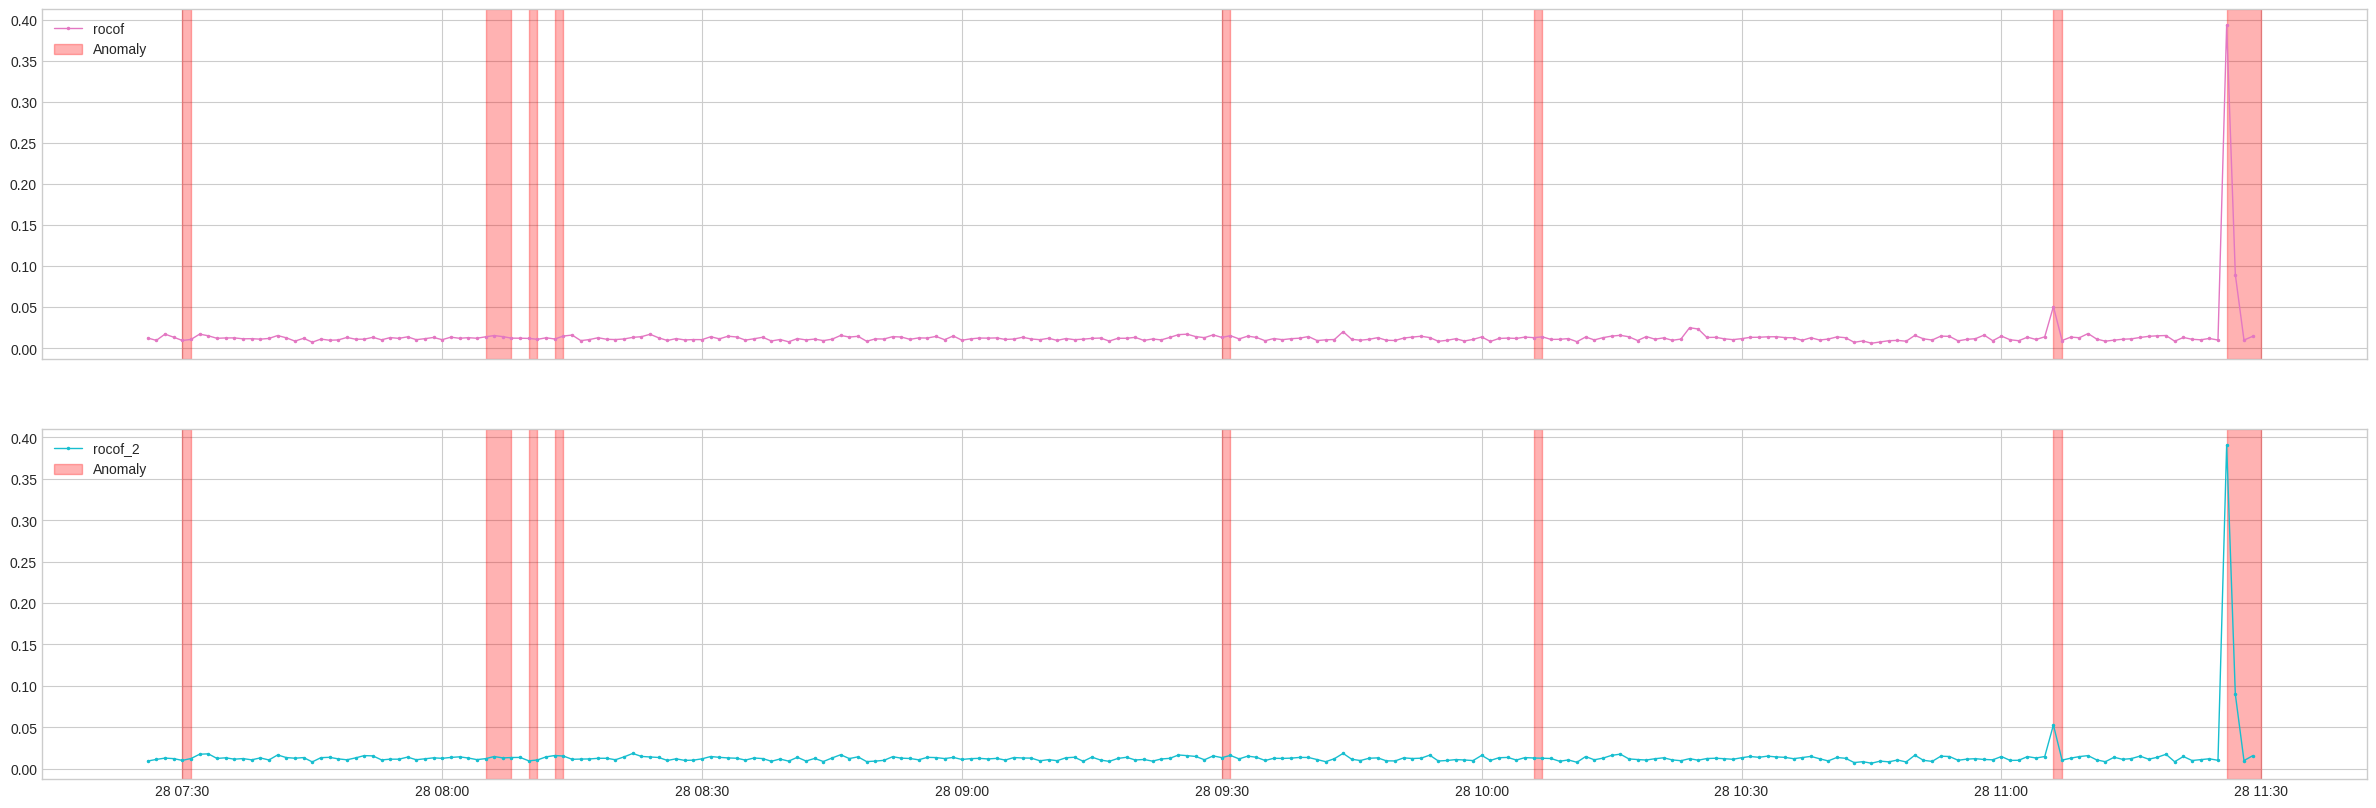

In [ ]:
from adtk.detector import SeasonalAD
from adtk.detector import QuantileAD
from adtk.detector import OutlierDetector
from adtk.detector import GeneralizedESDTestAD
from adtk.detector import MinClusterDetector
from adtk.detector import PcaAD
from adtk.data import validate_series
from adtk.visualization import plot
from sklearn.ensemble import IsolationForest
from sklearn import metrics

import warnings
import matplotlib.pyplot as plt
import time

contaminantes = 0.05

detectores = [
    SeasonalAD(freq=24),
    QuantileAD(high=0.99, low=0.01),
    OutlierDetector(IsolationForest(contamination=contaminantes, random_state=42)),
    GeneralizedESDTestAD(),
    MinClusterDetector(IsolationForest(contamination=contaminantes, random_state=42)),
    PcaAD()
]

metricas = []

anomalias = pd.DataFrame()
serie_tot = pd.DataFrame()

for evento in eventos:
  df = medidas(parquets, evento)
  series = validate_series(df)
  # faixa de tempo do evento para avaliação
  faixa = df.index.to_series().between(evento-timedelta(minutes=30),evento+timedelta(minutes=30))
  # somente tutor na faixa de tempo
  y_true = df[df.columns[-1]][faixa].values

  for det in detectores:
    nomeDetector = det.__class__.__name__
    inicio_treino = time.time()
    series.name = nomeDetector

    y_anom = det.fit_detect(series)
    anomalias = y_anom

    fim_treino = time.time()
    tempo_treino = fim_treino - inicio_treino

    #verificando se existe a coluna no dataframe. Caso existir, popular a variavel curveColumns
    curveColumns = []
    if 'rocof' in series.columns:
      curveColumns.append('rocof')
    if 'rocof_2' in series.columns:
      curveColumns.append('rocof_2')

    warnings.filterwarnings('ignore')
    if not anomalias.empty and curveColumns:
      print('Nome detector:', nomeDetector, '\nEvento:', evento)
      plot(series, anomaly=anomalias, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group=curveColumns, figsize=(30,10))
      print('=================================================')

    #Filtrando as anomalias detectadas para a mesma faixa de tempo que y_true
    y_pred = y_anom[faixa].astype(int)

    # Convertendo y_pred para array NumPy, se for um DataFrame
    if isinstance(y_pred, pd.DataFrame):
      y_pred = y_pred.values

    # Certifique-se de que y_pred é uma série unidimensional
    if y_pred.ndim > 1:
      y_pred = y_pred.ravel()  # Achatando y_pred para uma dimensão

    temErro = False
    # Verificando se y_true e y_pred têm o mesmo tamanho
    if len(y_true) != len(y_pred):
      print(f"Erro de tamanho inconsistente para o detector {nomeDetector} no evento {evento}")
      temErro = True
      #continue

    # Verifique se y_true e y_pred são binários
    if not set(y_true).issubset({0, 1}) or not set(y_pred).issubset({0, 1}):
      print(f"Erro: y_true ou y_pred não são binários para o detector {nomeDetector} no evento {evento}")
      temErro = True
      #continue

    # Calculando métricas
    if not temErro:
      bac = metrics.balanced_accuracy_score(y_true, y_pred)
      f1s = metrics.f1_score(y_true, y_pred)
      fms = metrics.fowlkes_mallows_score(y_true, y_pred)
      mis = metrics.adjusted_mutual_info_score(y_true, y_pred)
      cps = metrics.completeness_score(y_true, y_pred)
      hgs = metrics.homogeneity_score(y_true, y_pred)

      prc = metrics.precision_score(y_true, y_pred)
      rec = metrics.recall_score(y_true, y_pred)
    else:
      bac = 0
      f1s = 0
      fms = 0
      mis = 0
      cps = 0
      hgs = 0

      prc = 0
      rec = 0

    # Armazenando métricas
    dn = {
        'Evento': evento,
        'Detector': nomeDetector,
        'Acurácia Balanceada': round(bac * 100, 2),
        'F1': round(f1s * 100, 2),
        'Precisão':round(prc*100,2),
        'Recall':round(rec*100,2),
        'FMS': round(fms * 100, 2),
        'MIS': round(mis * 100, 2),
        'CPS': round(cps * 100, 2),
        'HGS': round(hgs * 100, 2),
        'Tempo treinamento (s)': round(tempo_treino,4),
        'y_true': y_true.tolist(),
        'y_pred': y_pred.tolist(),
    }
    metricas.append(dn)

dfm = pd.DataFrame(data=metricas)
print(dfm)

In [ ]:
dfm.to_excel('metricas_anomalias_adtk.xlsx')